# Developing an Image Classifier Using Synthetic Data from CAD Models
### Part II of Berkeley PCMLAI - Final Capstone Project
#### A.Morato

The first part of the project focused on building an artificial dataset of images from CAD models. This second part of the analysis delves into the initial question and aims to provide a concrete answer.

The analysis is based on the YOLO (You Only Look Once) computer vision model (version 8), which combines bounding box prediction and object classification into a single tool. The choice was driven by two main reasons: (i) it is widely used by other research groups, providing a wealth of available literature, and (ii) it is suitable for industrial applications.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
import shutil
import yaml
import wandb
import matplotlib.pyplot as plt
import namegenerator
import random

from ultralytics import YOLO
from pathlib import Path
from utils import load_yaml, count_types
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from wandb.integration.ultralytics import add_wandb_callback
from PIL import Image as PilImage
from IPython.display import Image, display

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


### Preliminary Operations and Ancillary Functions
This section gathers functions and settings used throughout the entire analysis.

In [2]:
# The load_labels function maps image filenames to their corresponding labels from .txt files in a specified directory
def load_labels(labels_path):
    labels = {}
    for filename in os.listdir(labels_path):
        if filename.endswith('.txt'):
            with open(os.path.join(labels_path, filename), 'r') as f:
                label = f.read().strip()
                image_filename_png = filename.replace('.txt', '.png')
                image_filename_jpg = filename.replace('.txt', '.jpg')
                image_filename_jpeg = filename.replace('.txt', '.jpeg')
                labels[image_filename_png] = label
                labels[image_filename_jpg] = label
                labels[image_filename_jpeg] = label
    return labels

In [3]:
# Function to randomly pick n images from the folder
def pick_random_files(files, n):
    random.shuffle(files)
    return files[:n]

In [4]:
# Function to randomly pick n samples from a group of files, keeping the classes balanced
def balance_classes(files, labels, n):
    # Group files by their labels
    class_files = {}
    for file in files:
        label = labels[file]
        if label not in class_files:
            class_files[label] = []
        class_files[label].append(file)
    
    # Shuffle the files in each class
    for label in class_files:
        random.shuffle(class_files[label])

    # Calculate how many samples to pick per class
    n_classes = len(class_files)
    samples_per_class = n // n_classes
    remaining_samples = n % n_classes
    
    balanced_files = []
    
    # Pick the calculated number of samples from each class
    for label in class_files:
        balanced_files.extend(class_files[label][:samples_per_class])
    
    # Distribute the remaining samples (if any) across the classes
    if remaining_samples > 0:
        remaining_class_files = []
        for label in class_files:
            remaining_class_files.extend(class_files[label][samples_per_class:])
        random.shuffle(remaining_class_files)
        balanced_files.extend(remaining_class_files[:remaining_samples])
    
    return balanced_files

In [5]:
# Function to copy and transfer files
def copy_files(files, source_dir, dest_dir, labels_path):
    for file in tqdm(files):
        # Handle different image extensions
        file_stem = Path(file).stem  # Get the base name of the file without extension
        label_file = f"{file_stem}.txt"

        if not os.path.exists(os.path.join(labels_path, label_file)):
            print(f"Label file not found: {label_file}")
            continue
        
        shutil.copy(os.path.join(source_dir, file), dest_dir)
        shutil.copy(os.path.join(labels_path, label_file), dest_dir)

In [6]:
# The .yaml file in a YOLOv8 model specifies main configuration settings (e.g. dataset paths, class names, training parameters)
yaml_path = 'train_configs/test_training.yaml'
params = load_yaml(yaml_path)

In [7]:
# Set the directory for Weights & Biases logs and artifacts to the specified path from the YAML configuration
os.environ['WANDB_DIR'] = params.wandb_dir

In [8]:
# Definitions of files paths

# Define paths for CAD images and their corresponding labels
images_path = params.input.images_path
labels_path = params.input.labels_path

# Define paths for real training images for each class (+ backgrounds)
train_QD_path  = params.input.train_QD_path
train_QF_path  = params.input.train_QF_path
train_QFA_path = params.input.train_QFA_path
train_SD_path  = params.input.train_SD_path
train_SHD_path = params.input.train_SHD_path
train_background_path = params.input.train_background_path

# Define paths for real validation data for each class (+ backgrounds)
val_QD_path  = params.input.val_QD_path
val_QF_path  = params.input.val_QF_path
val_QFA_path = params.input.val_QFA_path
val_SD_path  = params.input.val_SD_path
val_SHD_path = params.input.val_SHD_path
val_background_path = params.input.val_background_path

# Define path for labels associated with real images
pics_labels_path = params.input.pics_labels_path

# Define directories for saving training and validation data (working directories for the classifier model)
train_path = params.train
val_path = params.val

In [9]:
# Create directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

### 1. A Fully Synthetic Model

The first step of the analysis is building an ideal model, fully based on synthetic data. The train-validation dataset (with an 80-20% ratio) coincides with the CAD dataset developed in the first part of the project. Since this is my first time using the YOLO framework, the validation dataset also consists of artificial images to test the correctness of the structure.

In [10]:
# Percentage of CAD images to be allocated for validation
val_size = 0.2

In [11]:
# Delete all files in training and validation folders
for path in [train_path, val_path]:
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))

In [12]:
# Artificial CAD images
image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpeg', '.jpg'))]

In [13]:
# Create a list of labels for stratification (to be sure split of dataset is balanced)
labels = []
for file in image_files:
    label_file = os.path.join(labels_path, file.replace('.png', '.txt'))
    with open(label_file, 'r') as f:
        class_id = int(f.readline().split()[0])  # Assuming the first entry in the label file is the class ID
        labels.append(class_id)

In [14]:
# Perform the train-test split with stratification
train_files, val_files = train_test_split(image_files, test_size=val_size, random_state=42, stratify=labels)

In [15]:
# Transfer of the two collections of images to train and validation folders
copy_files(train_files, images_path, train_path, labels_path)
copy_files(val_files, images_path, val_path, labels_path)

100%|██████████| 960/960 [00:51<00:00, 18.78it/s]


In [16]:
# The YAML file in a YOLOv8 model typically contains configuration settings for training, such as paths to the training and validation datasets, model parameters (like the number of classes), augmentation settings, and other training hyperparameters.
# This configuration file is defined here 

n_classes = 5 # Number of classes of magnets

yaml_content = f"""
train: {params.train}
val: {params.val}

nc: {n_classes}
names: {['QF','QD','QFA','SD','SHD']} 
"""
with open(params.yolo_yaml_path, 'w') as f:
    f.write(yaml_content)

Instantiate a YOLO model for object detection. The model is initialized with a standard pre-trained YOLOv8n model located at the specified path. The 'task' parameter is set to 'detect', indicating that this model will be used for object detection. This model aims not only to classify objects but also to understand their spatial positions. 'detect' seems to be the most appropriate choice, rather than the simpler 'classifier' option.

In [18]:
# Create a YOLO based Model
# 'detect' option is enabled
model_fullCAD = YOLO('/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt', task='detect', verbose=False)

In [19]:
run_name=f'fullCAD_{namegenerator.gen()}'

This initial run is configured with conservative settings. Since I don't anticipate issues in producing a reliable model from ideal data, I haven't strictly followed the recommendations in the YOLO documentation. The suggested values are epochs ≥ 100 and a learning rate < 0.1. To expedite the analysis, I've relaxed these values. The image size (imgsz) is set to 1024 (as the CAD images have a resolution of 1024x768), and device specifies the use of multiple GPUs (0, 1, 2, 3) for distributed training, allowing the workload to be shared across four GPUs for faster processing. These four GPUs are located in a specific node of the NERSC supercomputer 'Perlmutter,' which has been assigned to me.

In [20]:
# Train the model

print(80*'=')
print(80*'=')
print(f"Training model {run_name}")
print(80*'=')

model_fullCAD.train(
    data=params.yolo_yaml_path, 
    lr0=0.1,
    epochs=20,  
    val=True,
    imgsz=1024,
    batch=64,
    device=[0, 1, 2, 3],
    name=run_name,
    project='alsu_magnet_classifier',
    save_dir='/global/homes/a/amorato/alsu_magnet_classifier/training_output/',
    )

Training model fullCAD_lanky-tangerine-akita
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=20, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=fullCAD_lanky-tangerine-akita, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fals

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240829_165859-shd7num7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fullCAD_lanky-tangerine-akita
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/shd7num7


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val... 960 images, 0 backgrounds, 0 corrupt: 100%|██████████| 960/960 [00:01<00:00, 605.06it/s]


val: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache
Plotting labels to alsu_magnet_classifier/fullCAD_lanky-tangerine-akita/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/fullCAD_lanky-tangerine-akita
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.11G      1.005       3.77      1.691         47       1024: 100%|██████████| 60/60 [00:27<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.75it/s]


                   all        960        960      0.662      0.356      0.651      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.13G     0.4905      1.921      1.207         38       1024: 100%|██████████| 60/60 [00:08<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.54it/s]


                   all        960        960      0.853      0.613      0.843      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.13G     0.4607      1.369      1.172         34       1024: 100%|██████████| 60/60 [00:08<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.58it/s]


                   all        960        960      0.791      0.791      0.842      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.13G     0.4646      1.012      1.167         39       1024: 100%|██████████| 60/60 [00:08<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.32it/s]


                   all        960        960      0.732      0.823      0.906      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.13G     0.4245      0.784      1.122         31       1024: 100%|██████████| 60/60 [00:08<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.38it/s]


                   all        960        960      0.869      0.857      0.952       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.12G     0.4056     0.6304      1.122         35       1024: 100%|██████████| 60/60 [00:08<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.10it/s]


                   all        960        960       0.98      0.984      0.994      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.12G     0.3738     0.5495      1.074         36       1024: 100%|██████████| 60/60 [00:08<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.40it/s]


                   all        960        960      0.911      0.906      0.959      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.12G     0.3713     0.5025      1.082         43       1024: 100%|██████████| 60/60 [00:08<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.73it/s]


                   all        960        960      0.885      0.887      0.976      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.12G     0.3537     0.4472      1.061         29       1024: 100%|██████████| 60/60 [00:08<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.47it/s]


                   all        960        960      0.993      0.994      0.995      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.12G     0.3462     0.4233      1.066         36       1024: 100%|██████████| 60/60 [00:08<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.76it/s]


                   all        960        960      0.997          1      0.995      0.991
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.12G     0.2064     0.3144     0.9217         16       1024: 100%|██████████| 60/60 [00:10<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.72it/s]


                   all        960        960      0.997      0.998      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.12G      0.175     0.2578     0.8773         16       1024: 100%|██████████| 60/60 [00:08<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.75it/s]


                   all        960        960      0.981      0.986      0.995      0.989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.12G     0.1603      0.219     0.8587         16       1024: 100%|██████████| 60/60 [00:08<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.28it/s]


                   all        960        960      0.999          1      0.995       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.12G     0.1484      0.203      0.852         16       1024: 100%|██████████| 60/60 [00:08<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.41it/s]


                   all        960        960      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.12G     0.1376     0.1764     0.8265         16       1024: 100%|██████████| 60/60 [00:08<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.40it/s]


                   all        960        960      0.996          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.12G     0.1305     0.1639     0.8315         16       1024: 100%|██████████| 60/60 [00:08<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.66it/s]


                   all        960        960      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.12G     0.1176     0.1503     0.8124         16       1024: 100%|██████████| 60/60 [00:08<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.85it/s]


                   all        960        960      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.12G     0.1071     0.1396      0.803         16       1024: 100%|██████████| 60/60 [00:08<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.86it/s]


                   all        960        960      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.12G     0.0966      0.128     0.8032         16       1024: 100%|██████████| 60/60 [00:08<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.93it/s]


                   all        960        960      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.12G    0.09131     0.1239      0.791         16       1024: 100%|██████████| 60/60 [00:08<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:02<00:00, 10.89it/s]


                   all        960        960          1          1      0.995      0.995

20 epochs completed in 0.073 hours.
Optimizer stripped from alsu_magnet_classifier/fullCAD_lanky-tangerine-akita/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/fullCAD_lanky-tangerine-akita/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/fullCAD_lanky-tangerine-akita/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.73it/s]


                   all        960        960          1          1      0.995      0.995
                    QF        192        192          1          1      0.995      0.995
                    QD        192        192          1          1      0.995      0.995
                   QFA        192        192          1          1      0.995      0.995
                    SD        192        192          1          1      0.995      0.995
                   SHD        192        192          1          1      0.995      0.995
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to alsu_magnet_classifier/fullCAD_lanky-tangerine-akita


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
wandb:                  lr/pg1 ▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
wandb:                  lr/pg2 ▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
wandb:        metrics/mAP50(B) ▁▅▅▆▇█▇█████████████
wandb:     metrics/mAP50-95(B) ▁▃▄▆▆█▇▇████████████
wandb:    metrics/precision(B) ▁▅▄▂▅█▆▆████████████
wandb:       metrics/recall(B) ▁▄▆▆▆█▇▇████████████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁
wandb:          train/cls_loss █▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▄��▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁
wandb:            val/box_loss ▆█▇▄▄▃▃▃▃▂▂▂▃▁▁▁▁▁▁▁
wandb:            val/cls_loss █▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            val/dfl_loss ▆█▆▃▄▃▂▂▃▂▁▂▂▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 4e-05
wandb:                  lr/pg1 4e-05
wandb: 

The YOLOv8 framework automatically generates visualizations, like the confusion matrix and PR curve, during training and validation. These visualizations help in evaluating model performance across classes and understanding precision-recall trade-offs.

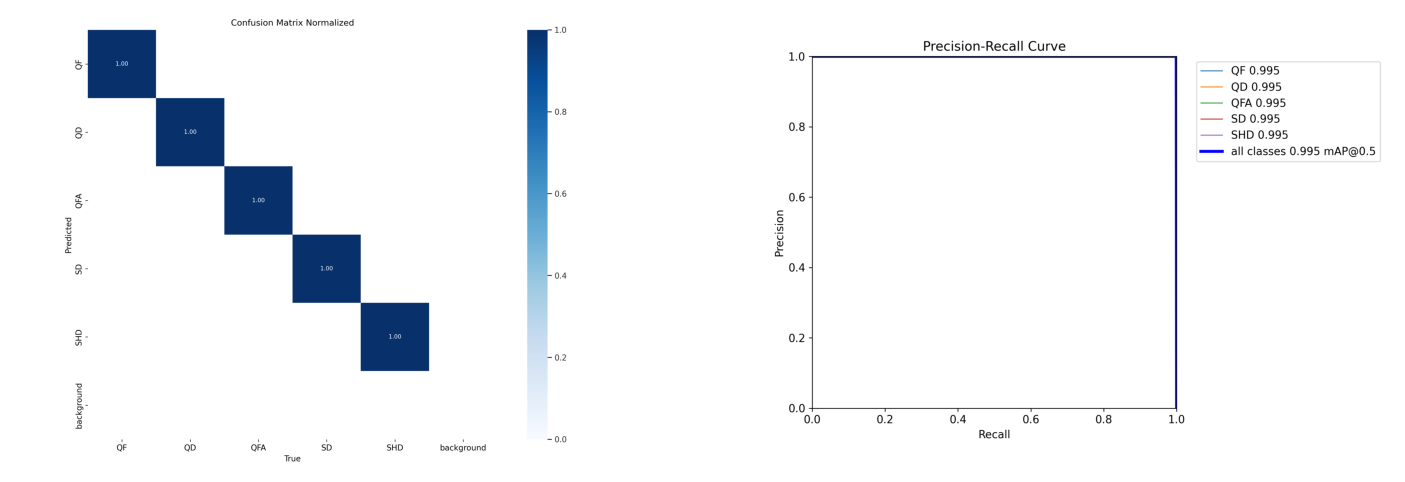

In [24]:
# Define paths to the confusion matrix and PR curve images for the last run
image_path_0 = f'alsu_magnet_classifier/{run_name}/confusion_matrix_normalized.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/PR_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)

# Create a figure to display both images side by side
plt.figure(figsize=(18, 6))

# Display the first image (confusion matrix) on the left
plt.subplot(1, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (PR curve) on the right
plt.subplot(1, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Show the images
plt.show()

In order to understand the quality of the trained YOLO model, other graphs are considered. In particular Precision/Confidence, Recall/Confidence and F1 Confidence. In the context of these graphs, confidence is a threshold that determines which predictions are considered "positive" by the model. For instance, a confidence threshold of 0.5 might mean that the model only considers a prediction valid if it is at least 50% confident in that prediction. By varying this threshold, you can observe how the model's performance changes in terms of recall, precision, and F1 score.

- Recall: This measures the ability of the model to correctly identify all relevant instances (true positives).
- Precision: This measures the accuracy of the positive predictions.
- F1 Score: This is the harmonic mean of precision and recall, providing a single metric that balances both concerns.

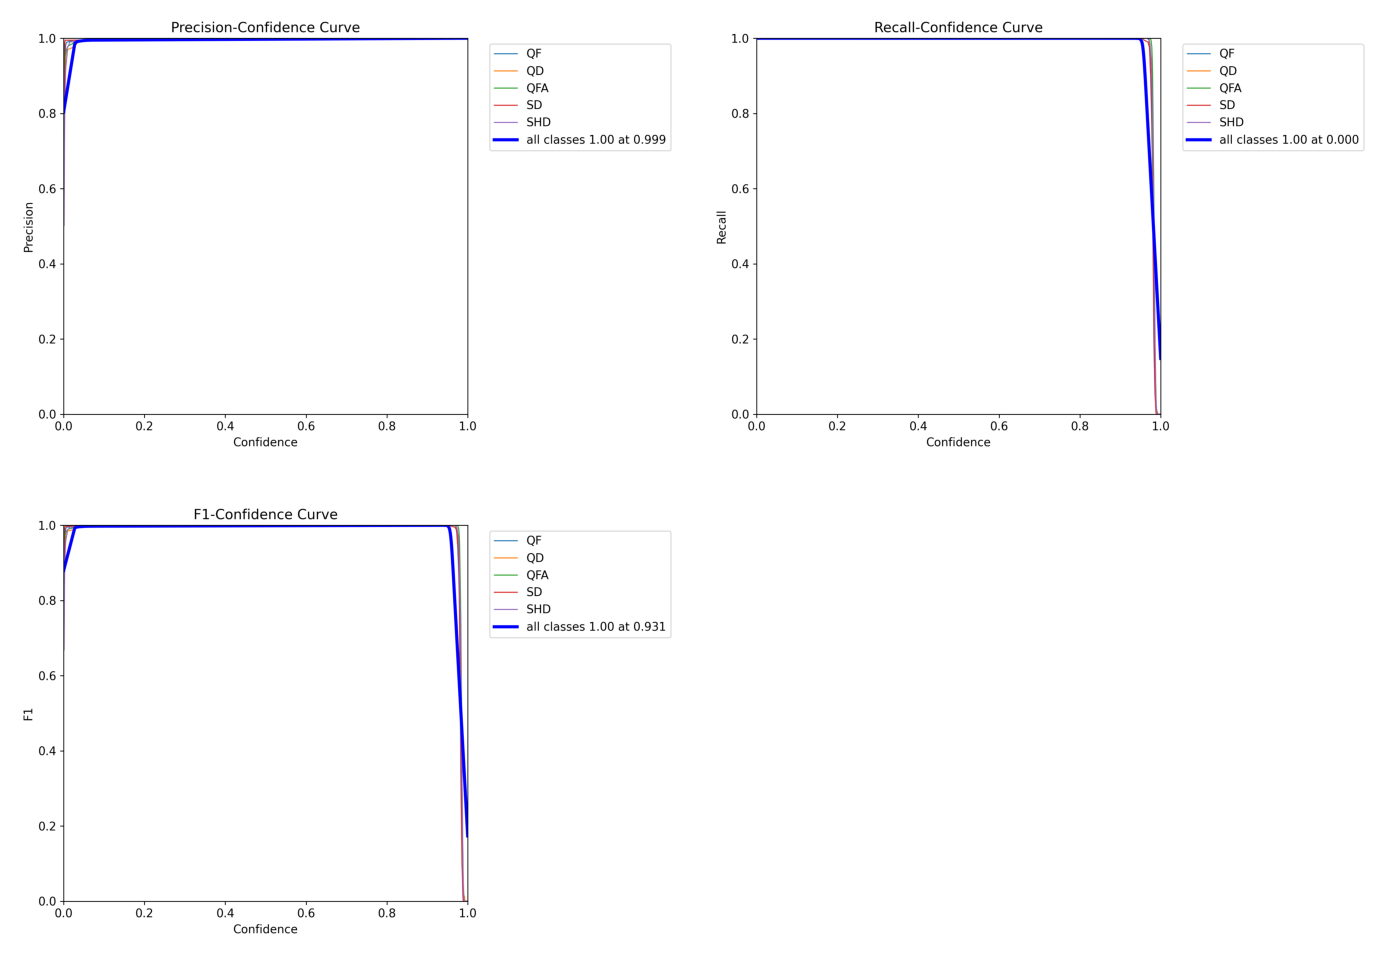

In [27]:
# Define paths to the performance graphs
image_path_0 = f'alsu_magnet_classifier/{run_name}/P_curve.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/R_curve.png'
image_path_2 = f'alsu_magnet_classifier/{run_name}/F1_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)
image2 = PilImage.open(image_path_2)

# Create a figure to display both images side by side
plt.figure(figsize=(14, 10))

# Display the first image (P curve)
plt.subplot(2, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (R curve)
plt.subplot(2, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Display the third image (F1 curve)
plt.subplot(2, 2, 3)
plt.imshow(image2)
plt.axis('off')  # Hide the axes

plt.tight_layout()

# Show the images
plt.show()

If the visual graphs provided by the YOLO framework need to be verified, the model's numerical validation metrics can be accessed and used. This point has been somewhat confusing for me. After some research, it appears that in YOLOv8, after training a model with the validation option enabled (val=True), you might expect to directly access the validation metrics from the training results. However, a separate validation function needs to be called to access all the model's metrics. In this case, the confusion matrix is extracted and then plotted using a heatmap, with the confusion matrix left unnormalized to highlight the symmetrical distribution of samples among classes. Lastly, regarding the 'background' class: this is something specific to YOLO; it is a default class introduced to indicate images that do not contain any objects.

In [28]:
run_name = run_name + '_VAL'

In [29]:
# Validate the model and save metrics
results_fullCAD = model_fullCAD.val(name=run_name)

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 960 images, 0 backgrounds, 0 corrupt: 100%|██████████| 960/960 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


                   all        960        960          1          1      0.995      0.995
                    QF        192        192          1          1      0.995      0.995
                    QD        192        192          1          1      0.995      0.995
                   QFA        192        192          1          1      0.995      0.995
                    SD        192        192          1          1      0.995      0.995
                   SHD        192        192          1          1      0.995      0.995
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to alsu_magnet_classifier/fullCAD_lanky-tangerine-akita_VAL


In [30]:
# Access the matrix data from the ConfusionMatrix object
cm_fullCAD = results_fullCAD.confusion_matrix.matrix

# Check the shape of the confusion matrix
print(cm_fullCAD.shape)
print(cm_fullCAD)

(6, 6)
[[        192           0           0           0           0           0]
 [          0         192           0           0           0           0]
 [          0           0         192           0           0           0]
 [          0           0           0         192           0           0]
 [          0           0           0           0         192           0]
 [          0           0           0           0           0           0]]


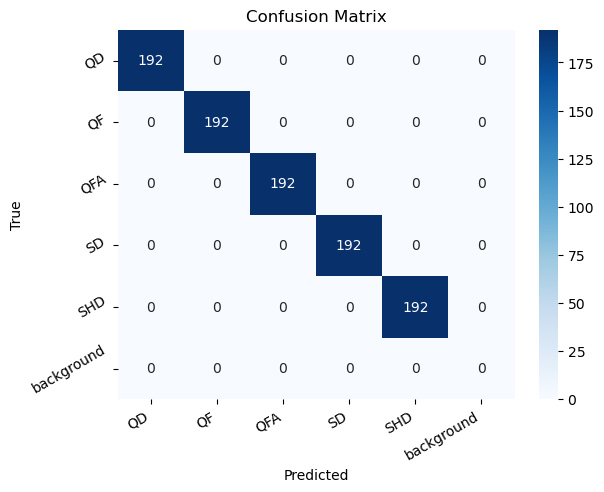

In [31]:
# Define the class names
class_names = ['QD', 'QF', 'QFA', 'SD', 'SHD', 'background']

# Plot the confusion matrix using seaborn
sns.heatmap(cm_fullCAD, annot=True, fmt='.0f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Rotate the x and y labels by 30 degrees and align the final parts of them
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=30, ha='right')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In addition to the standard metrics, mAP50 is also considered. A literature review suggests that mAP50 is a key metric in evaluating the effectiveness of a YOLO detector, as it provides a clear and balanced indication of how well the model performs in detecting and localizing objects across different classes. The numerica metrics (together with the confusion matrix and graphs above) cofirms the model is working perfectly.

In [34]:
fullCAD_precision = results_fullCAD.box.mp
fullCAD_recall = results_fullCAD.box.mr
fullCAD_mAP50 = results_fullCAD.box.map50
fullCAD_f1 = 2 * (fullCAD_precision * fullCAD_recall) / (fullCAD_precision + fullCAD_recall)

In [35]:
print("Full CAD model summary:")
print(f"Precision: {fullCAD_precision:.3f}")
print(f"Recall: {fullCAD_recall:.3f}")
print(f"mAP50: {fullCAD_mAP50:.3f}")
print(f"F1: {fullCAD_f1:.3f}")

Full CAD model summary:
Precision: 1.000
Recall: 1.000
mAP50: 0.995
F1: 1.000


### 2. Apply the Ideal Model to Real-World Images

The ideal model, trained in the previous paragraph using a collection of artificial images, is now applied to a collection of real images. To achieve this, the validation dataset needs to be updated.

In [40]:
n_real_val = 40  # Num Real Images in Val (per class)

In [41]:
# Delete all files in validation folder
for path in [val_path]:
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))

In [42]:
# Validation Dataset (Real Images)
all_val_QD_files = [f for f in os.listdir(val_QD_path) if f.endswith('.jpg')]
all_val_QF_files = [f for f in os.listdir(val_QF_path) if f.endswith('.jpg')]
all_val_QFA_files = [f for f in os.listdir(val_QFA_path) if f.endswith('.jpg')]
all_val_SD_files = [f for f in os.listdir(val_SD_path) if f.endswith('.jpg')]
all_val_SHD_files = [f for f in os.listdir(val_SHD_path) if f.endswith('.jpg')]
all_val_background_files = [f for f in os.listdir(val_background_path) if f.endswith('.jpg')]

pics_labels = load_labels(pics_labels_path)

In [43]:
# Random pick across the classes
val_QD_files = pick_random_files(all_val_QD_files, n_real_val)
val_QF_files = pick_random_files(all_val_QF_files, n_real_val)
val_QFA_files = pick_random_files(all_val_QFA_files, n_real_val)
val_SD_files = pick_random_files(all_val_SD_files, n_real_val)
val_SHD_files = pick_random_files(all_val_SHD_files, n_real_val)
val_background_files = pick_random_files(all_val_background_files, n_real_val)

In [44]:
# Copy files to the validation folder
copy_files(val_QD_files, val_QD_path, val_path, pics_labels_path)
copy_files(val_QF_files, val_QF_path, val_path, pics_labels_path)
copy_files(val_QFA_files, val_QFA_path, val_path, pics_labels_path)
copy_files(val_SD_files, val_SD_path, val_path, pics_labels_path)
copy_files(val_SHD_files, val_SHD_path, val_path, pics_labels_path)
copy_files(val_background_files, val_background_path, val_path, pics_labels_path)

100%|██████████| 40/40 [00:02<00:00, 14.47it/s]


In [45]:
run_name = run_name + '_Real'

In [46]:
# Validate the model and save metrics
results_fullCAD_Real = model_fullCAD.val(name=run_name)

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 344.08it/s]


val: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.19s/it]


                   all        240        377      0.428     0.0184    0.00882    0.00378
                    QF         40         40          1          0          0          0
                    QD         60         61          1          0          0          0
                   QFA         76         76      0.142     0.0921     0.0415     0.0177
                    SD         99        141          0          0    0.00259    0.00117
                   SHD         59         59          0          0          0          0
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/fullCAD_lanky-tangerine-akita_VAL_Real


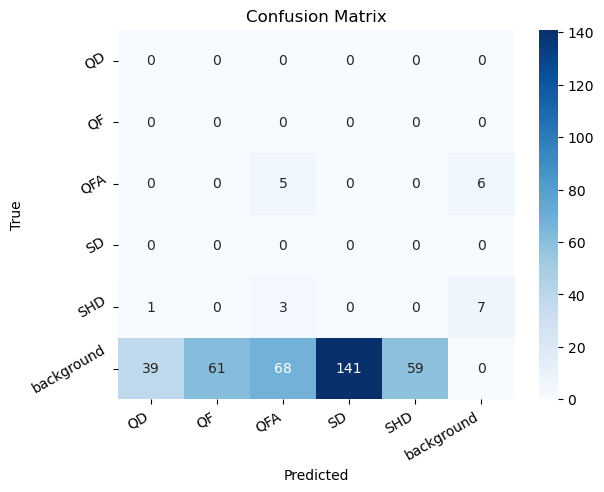

In [47]:
# Access the matrix data from the ConfusionMatrix object
cm_fullCAD_Real = results_fullCAD_Real.confusion_matrix.matrix

# Define the class names
class_names = ['QD', 'QF', 'QFA', 'SD', 'SHD', 'background']

# Plot the confusion matrix using seaborn
sns.heatmap(cm_fullCAD_Real, annot=True, fmt='.0f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Rotate the x and y labels by 30 degrees and align the final parts of them
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=30, ha='right')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Metrics or the ideal model validated with real images
fullCAD_Real_precision = results_fullCAD_Real.box.mp
fullCAD_Real_recall = results_fullCAD_Real.box.mr
fullCAD_Real_mAP50 = results_fullCAD_Real.box.map50
fullCAD_Real_f1 = 2 * (fullCAD_Real_precision * fullCAD_Real_recall) / (fullCAD_Real_precision + fullCAD_Real_recall)

In [49]:
print("Full CAD model summary:")
print(f"Precision: {fullCAD_Real_precision:.3f}")
print(f"Recall: {fullCAD_Real_recall:.3f}")
print(f"mAP50: {fullCAD_Real_mAP50:.3f}")
print(f"F1: {fullCAD_Real_f1:.3f}")

Full CAD model summary:
Precision: 0.428
Recall: 0.018
mAP50: 0.009
F1: 0.035


The confusion matrix immediately reveals very poor performance. The model, trained solely with synthetic CAD images, performs poorly when validated with a set of real-world images. Among the other metrics, the overall precision doesn’t seem too bad. Some classes, like QD and QF, have a precision of 1. However, the high precision for QF and QD indicates that the model is not making false positive errors for these classes, but it might not be making many predictions for these classes at all. Precision here is a misleading parameter; this is why it’s crucial to consider both precision and recall together (or more holistic metrics, like F1) to get a complete picture of the model’s performance.

### 3. A Fully Real Model: How Good Could This Classifier Be?

The previous paragraph demonstrated that a complete dataset of CAD images does not perform well when applied to a collection of real pictures. Therefore, I attempted to train a similar model using a collection of real pictures. To avoid overfitting, I collected the training and validation images in different sessions, creating two distinct datasets; the two collections of pictures are independent of each other. Each class of magnets has an available collection of approximately 100 real pictures.

In [50]:
n_real_train = 100  # Num Real Images in Train (per class)
n_real_val = 40  # Num Real Images in Val (per class)

In [51]:
# Delete all files in training and validation folders
for path in [train_path, val_path]:
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))

In [52]:
# Adding real-world images

#Train Dataset
all_train_QD_files = [f for f in os.listdir(train_QD_path) if f.endswith('.jpg')]
all_train_QF_files = [f for f in os.listdir(train_QF_path) if f.endswith('.jpg')]
all_train_QFA_files = [f for f in os.listdir(train_QFA_path) if f.endswith('.jpg')]
all_train_SD_files = [f for f in os.listdir(train_SD_path) if f.endswith('.jpg')]
all_train_SHD_files = [f for f in os.listdir(train_SHD_path) if f.endswith('.jpg')]
all_train_background_files = [f for f in os.listdir(train_background_path) if f.endswith('.jpg')]

#Val Dataset
all_val_QD_files = [f for f in os.listdir(val_QD_path) if f.endswith('.jpg')]
all_val_QF_files = [f for f in os.listdir(val_QF_path) if f.endswith('.jpg')]
all_val_QFA_files = [f for f in os.listdir(val_QFA_path) if f.endswith('.jpg')]
all_val_SD_files = [f for f in os.listdir(val_SD_path) if f.endswith('.jpg')]
all_val_SHD_files = [f for f in os.listdir(val_SHD_path) if f.endswith('.jpg')]
all_val_background_files = [f for f in os.listdir(val_background_path) if f.endswith('.jpg')]

pics_labels = load_labels(pics_labels_path)

In [53]:
# Random Pick across the classes

# Preparing random images for train/val
train_QD_files = pick_random_files(all_train_QD_files, n_real_train)
train_QF_files = pick_random_files(all_train_QF_files, n_real_train)
train_QFA_files = pick_random_files(all_train_QFA_files, n_real_train)
train_SD_files = pick_random_files(all_train_SD_files, n_real_train)
train_SHD_files = pick_random_files(all_train_SHD_files, n_real_train)
train_background_files = pick_random_files(all_train_background_files, n_real_train)

val_QD_files = pick_random_files(all_val_QD_files, n_real_val)
val_QF_files = pick_random_files(all_val_QF_files, n_real_val)
val_QFA_files = pick_random_files(all_val_QFA_files, n_real_val)
val_SD_files = pick_random_files(all_val_SD_files, n_real_val)
val_SHD_files = pick_random_files(all_val_SHD_files, n_real_val)
val_background_files = pick_random_files(all_val_background_files, n_real_val)

In [54]:
# Copy files to their respective directories 
copy_files(train_QD_files, train_QD_path, train_path, pics_labels_path)
copy_files(train_QF_files, train_QF_path, train_path, pics_labels_path)
copy_files(train_QFA_files, train_QFA_path, train_path, pics_labels_path)
copy_files(train_SD_files, train_SD_path, train_path, pics_labels_path)
copy_files(train_SHD_files, train_SHD_path, train_path, pics_labels_path)
copy_files(train_background_files, train_background_path, train_path, pics_labels_path)

copy_files(val_QD_files, val_QD_path, val_path, pics_labels_path)
copy_files(val_QF_files, val_QF_path, val_path, pics_labels_path)
copy_files(val_QFA_files, val_QFA_path, val_path, pics_labels_path)
copy_files(val_SD_files, val_SD_path, val_path, pics_labels_path)
copy_files(val_SHD_files, val_SHD_path, val_path, pics_labels_path)
copy_files(val_background_files, val_background_path, val_path, pics_labels_path)

100%|██████████| 40/40 [00:04<00:00,  9.63it/s]


In [55]:
model_fullReal = YOLO('/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt', task='detect', verbose=False)

In [56]:
run_name=f'fullReal_{namegenerator.gen()}'

Given the increasing complexity of the task, I prefer to follow Ultralytics' recommendations at this point. I’ve set a higher number of epochs (100) and a much lower learning rate (0.01)

In [57]:
# Train the model

print(80*'=')
print(80*'=')
print(f"Training model {run_name}")
print(80*'=')

model_fullReal.train(
    data=params.yolo_yaml_path, 
    lr0=0.01,
    epochs=100,  
    val=True,
    imgsz=1024,
    batch=64,
    device=[0, 1, 2, 3],
    name=run_name,
    project='alsu_magnet_classifier',
    save_dir='/global/homes/a/amorato/alsu_magnet_classifier/training_output/',
    )

Training model fullReal_baggy-dandelion-owl
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=fullReal_baggy-dandelion-owl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240829_173458-bw5q2wni
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fullReal_baggy-dandelion-owl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/bw5q2wni


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 527.20it/s]


val: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache
Plotting labels to alsu_magnet_classifier/fullReal_baggy-dandelion-owl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/fullReal_baggy-dandelion-owl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.21G      1.812      4.416      1.849         41       1024: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]


                   all        240        336    0.00525      0.664    0.00906    0.00376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.21G      1.536      4.206      1.723         47       1024: 100%|██████████| 9/9 [00:01<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.05it/s]


                   all        240        336      0.005      0.844     0.0882     0.0549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.22G      1.127      3.454      1.367         40       1024: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]


                   all        240        336    0.00469      0.916      0.258      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.24G      0.977      2.708      1.288         24       1024: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.28it/s]


                   all        240        336     0.0055      0.946      0.351      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.24G     0.9263      2.214      1.218         27       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.97it/s]


                   all        240        336      0.973     0.0368      0.467      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.22G     0.8327      1.747      1.138         36       1024: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.63it/s]


                   all        240        336      0.927     0.0789        0.5      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.22G     0.8467       1.67      1.135         36       1024: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.45it/s]


                   all        240        336      0.932       0.12      0.444      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.24G     0.8031       1.49      1.107         22       1024: 100%|██████████| 9/9 [00:01<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.80it/s]


                   all        240        336       0.79      0.284      0.524      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.17G       0.78      1.405      1.107         41       1024: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.20it/s]


                   all        240        336      0.546      0.161      0.285      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.21G     0.7949      1.414      1.138         26       1024: 100%|██████████| 9/9 [00:01<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.02it/s]


                   all        240        336      0.523      0.322       0.38      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.24G     0.7707      1.197      1.075         51       1024: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.56it/s]


                   all        240        336      0.685      0.491      0.622      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.24G      0.784      1.123       1.07         38       1024: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.22it/s]


                   all        240        336      0.654      0.407      0.429      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.24G     0.7722      1.133      1.084         46       1024: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


                   all        240        336      0.644      0.536      0.621      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.22G     0.7625      1.063      1.068         52       1024: 100%|██████████| 9/9 [00:01<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.27it/s]


                   all        240        336      0.558      0.351       0.37      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.22G     0.6962     0.9643      1.052         33       1024: 100%|██████████| 9/9 [00:01<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.36it/s]


                   all        240        336      0.547      0.412       0.43      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.22G     0.6934     0.9871      1.048         29       1024: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.14it/s]


                   all        240        336      0.655      0.417      0.499      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.26G     0.6862     0.9059      1.036         26       1024: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.31it/s]


                   all        240        336       0.64      0.562      0.603      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.24G     0.6622     0.8474      1.014         58       1024: 100%|██████████| 9/9 [00:01<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.73it/s]


                   all        240        336       0.51      0.456      0.466       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.19G       0.67     0.8421      1.021         69       1024: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.29it/s]


                   all        240        336      0.628       0.42      0.473      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.22G     0.6733     0.7801      1.014         34       1024: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.02it/s]


                   all        240        336      0.751      0.557      0.708      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.23G     0.6633     0.8014      1.031         24       1024: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.27it/s]


                   all        240        336      0.785      0.658      0.727      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.25G     0.6603     0.8089      1.031         21       1024: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.22it/s]


                   all        240        336      0.727      0.645      0.658      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.21G     0.6601     0.7187      1.023         51       1024: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.57it/s]

                   all        240        336      0.825      0.723      0.831      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.24G     0.6272     0.7417      1.026         25       1024: 100%|██████████| 9/9 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.34it/s]


                   all        240        336      0.728      0.707      0.771      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.22G     0.6293     0.7049      1.006         26       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.76it/s]


                   all        240        336      0.803      0.753      0.828      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.23G     0.6028     0.6738      1.002         28       1024: 100%|██████████| 9/9 [00:01<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.29it/s]


                   all        240        336      0.815      0.696       0.81      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.22G     0.6049     0.6435      1.005         28       1024: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.45it/s]


                   all        240        336      0.793      0.782      0.833      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.21G     0.6319     0.6699      1.037         29       1024: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.34it/s]


                   all        240        336      0.813      0.756      0.833      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.22G     0.6371     0.6155     0.9834         45       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.51it/s]


                   all        240        336      0.768      0.749      0.809      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.17G     0.6126     0.6204      0.999         27       1024: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.99it/s]


                   all        240        336      0.819      0.816      0.856       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.23G     0.5724     0.5772     0.9793         25       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.92it/s]


                   all        240        336      0.769      0.652      0.767      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.22G     0.5945     0.5847      1.003         30       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.03it/s]


                   all        240        336      0.685      0.638      0.723      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.24G      0.597      0.575     0.9847         37       1024: 100%|██████████| 9/9 [00:01<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.79it/s]


                   all        240        336      0.776      0.589       0.67      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.25G     0.5907     0.5533      1.002         35       1024: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.08it/s]


                   all        240        336      0.776      0.589      0.688      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.24G     0.5956     0.5227     0.9705         39       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.22it/s]


                   all        240        336      0.759      0.669      0.744      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.23G     0.5568     0.5128     0.9573         29       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.14it/s]


                   all        240        336      0.834      0.814      0.859      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.21G     0.5707     0.5388     0.9775         40       1024: 100%|██████████| 9/9 [00:01<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.34it/s]


                   all        240        336      0.779      0.764      0.797      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.24G     0.5794     0.5303     0.9705         36       1024: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.04it/s]


                   all        240        336      0.844      0.808      0.876      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.23G     0.5633     0.5023     0.9497         44       1024: 100%|██████████| 9/9 [00:01<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.15it/s]


                   all        240        336       0.88      0.733      0.846      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.25G     0.5574     0.4739     0.9559         33       1024: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.92it/s]


                   all        240        336       0.81      0.661      0.734      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.25G     0.5389     0.4878     0.9559         34       1024: 100%|██████████| 9/9 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]


                   all        240        336      0.878      0.753      0.837      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.22G      0.537     0.4707     0.9486         27       1024: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.95it/s]


                   all        240        336      0.882      0.795      0.874      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.24G      0.522     0.4776     0.9377         28       1024: 100%|██████████| 9/9 [00:01<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.59it/s]


                   all        240        336      0.856      0.699      0.824      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.24G       0.51     0.4536     0.9468         11       1024: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.95it/s]


                   all        240        336      0.842      0.662       0.79       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.24G     0.5262     0.4594     0.9621         36       1024: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.44it/s]


                   all        240        336      0.813      0.657      0.763       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.24G     0.5165     0.4507     0.9383         32       1024: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


                   all        240        336      0.784      0.755      0.803      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.17G     0.5374     0.4572     0.9456         28       1024: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.43it/s]


                   all        240        336      0.854      0.711      0.821      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.24G     0.5189     0.4293     0.9513         41       1024: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.69it/s]


                   all        240        336      0.793      0.743      0.801      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.22G     0.5031     0.4244     0.9357         19       1024: 100%|██████████| 9/9 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]


                   all        240        336      0.839      0.809      0.887      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.18G     0.5513     0.4634     0.9481         29       1024: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.11it/s]


                   all        240        336       0.86      0.774      0.854      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.23G     0.5279     0.4221     0.9499         33       1024: 100%|██████████| 9/9 [00:01<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.05it/s]


                   all        240        336      0.901      0.809      0.899      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.23G     0.4995     0.4161     0.9556         44       1024: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.91it/s]


                   all        240        336      0.872      0.803      0.863      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       5.2G     0.4587     0.3981     0.9203         36       1024: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


                   all        240        336       0.84      0.756      0.845      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.25G      0.501     0.4288     0.9446         18       1024: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


                   all        240        336      0.816      0.762      0.822      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.22G     0.4721     0.4221     0.9349         45       1024: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.59it/s]


                   all        240        336      0.875      0.798      0.886       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.21G     0.5019     0.4078     0.9437         36       1024: 100%|██████████| 9/9 [00:01<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


                   all        240        336      0.893      0.811      0.879      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.22G     0.4911     0.3864     0.9304         37       1024: 100%|██████████| 9/9 [00:01<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]


                   all        240        336      0.833      0.802      0.841      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.23G      0.473     0.4029      0.918         32       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.88it/s]


                   all        240        336      0.901      0.782      0.903      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.24G     0.4721     0.3821     0.9214         19       1024: 100%|██████████| 9/9 [00:01<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.97it/s]


                   all        240        336      0.904      0.765       0.86      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.22G     0.4682     0.3822     0.9229         46       1024: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


                   all        240        336      0.857      0.771      0.823      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.22G     0.4646     0.3746     0.9083         41       1024: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.30it/s]


                   all        240        336      0.844      0.805      0.877      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.21G      0.483     0.3871     0.9118         29       1024: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.20it/s]

                   all        240        336      0.892       0.77       0.86      0.671


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.22G     0.4791     0.3776     0.9278         46       1024: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.26it/s]


                   all        240        336      0.937      0.796      0.888       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.21G     0.4594     0.3716     0.9048         45       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        336      0.892        0.8       0.86       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.25G     0.4607     0.3692     0.9042         45       1024: 100%|██████████| 9/9 [00:01<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.40it/s]


                   all        240        336       0.88       0.83        0.9      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.21G     0.4825     0.3804     0.9272         33       1024: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.09it/s]


                   all        240        336      0.909      0.827      0.907      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.24G     0.4542      0.358     0.9264         30       1024: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.00it/s]


                   all        240        336      0.899      0.823      0.892      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.21G      0.474     0.3789      0.941         20       1024: 100%|██████████| 9/9 [00:01<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.32it/s]


                   all        240        336      0.893      0.823       0.87      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.22G     0.4629     0.3565     0.9497         37       1024: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]


                   all        240        336      0.864      0.818      0.868      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.24G     0.4495     0.3523     0.9093         26       1024: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]


                   all        240        336      0.867      0.834      0.866      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.24G     0.4434     0.3363     0.9055         43       1024: 100%|██████████| 9/9 [00:01<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.96it/s]


                   all        240        336      0.905      0.826      0.886      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.23G     0.4435     0.3366     0.9137         21       1024: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


                   all        240        336      0.918      0.818      0.885      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.22G     0.4624     0.3543     0.9229         47       1024: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        336       0.92      0.808      0.889      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.21G      0.433     0.3293     0.8848         31       1024: 100%|██████████| 9/9 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.45it/s]


                   all        240        336      0.856      0.678      0.763      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.21G     0.4387     0.3447     0.9031         28       1024: 100%|██████████| 9/9 [00:01<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.23it/s]


                   all        240        336      0.896      0.788      0.859       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.22G     0.4287     0.3289     0.8948         31       1024: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.56it/s]


                   all        240        336      0.915      0.775      0.868      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.25G     0.4404     0.3513     0.9201         33       1024: 100%|██████████| 9/9 [00:01<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.93it/s]


                   all        240        336      0.846      0.753      0.819      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.23G     0.4537     0.3523     0.9164         51       1024: 100%|██████████| 9/9 [00:01<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        336      0.908      0.801      0.882      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.23G     0.4293     0.3264     0.9103         38       1024: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.91it/s]


                   all        240        336       0.89      0.793      0.894      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.22G     0.4462      0.337     0.9071         20       1024: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.99it/s]


                   all        240        336      0.896      0.796        0.9      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.22G     0.3932     0.3303     0.8858         29       1024: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        336      0.931      0.804       0.91      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.24G     0.4098     0.3242     0.9048         51       1024: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]


                   all        240        336      0.904      0.782       0.88      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.22G     0.4172     0.3072     0.9141         21       1024: 100%|██████████| 9/9 [00:01<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.53it/s]


                   all        240        336      0.942      0.783        0.9      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.22G      0.421     0.3236     0.8992         42       1024: 100%|██████████| 9/9 [00:01<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]


                   all        240        336      0.932      0.811      0.913      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.25G     0.4167     0.3097     0.8855         41       1024: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        336       0.92      0.829      0.915      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.24G     0.4452     0.3221     0.9018         39       1024: 100%|██████████| 9/9 [00:01<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        336       0.94      0.832      0.927      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       5.2G     0.4256     0.3314     0.8953         41       1024: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.08it/s]


                   all        240        336      0.935      0.819      0.915      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.24G     0.4155      0.299     0.8915         43       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


                   all        240        336      0.948      0.815      0.922      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.23G     0.3908     0.3023     0.8953         32       1024: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        336      0.914      0.827      0.915      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.26G     0.3999     0.2934     0.8908         41       1024: 100%|██████████| 9/9 [00:01<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]


                   all        240        336      0.933      0.818      0.911      0.711
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.13G     0.3854     0.3089     0.8679         20       1024: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.49it/s]


                   all        240        336      0.929      0.816      0.903      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.13G     0.3584     0.2796     0.8571         20       1024: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


                   all        240        336      0.901      0.826      0.901      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.13G     0.3589      0.286     0.8259         20       1024: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]


                   all        240        336      0.898      0.831      0.901      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.13G     0.3494     0.2757     0.8489         13       1024: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        336       0.92      0.839       0.92      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.16G     0.3657     0.2819     0.8552         12       1024: 100%|██████████| 9/9 [00:01<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.42it/s]


                   all        240        336      0.948      0.832      0.925      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.13G     0.3369     0.2627     0.8348         14       1024: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        336      0.947      0.835      0.929      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.13G     0.3422     0.2609     0.8302         31       1024: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        336       0.93      0.855      0.926      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.13G     0.3521      0.265     0.8431         15       1024: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


                   all        240        336      0.939       0.85      0.925      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.13G     0.3635     0.2768     0.8514         15       1024: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]


                   all        240        336      0.939      0.846      0.926       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.16G     0.3407     0.2545     0.8294         15       1024: 100%|██████████| 9/9 [00:01<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.76it/s]


                   all        240        336      0.949      0.832      0.927      0.744

100 epochs completed in 0.072 hours.
Optimizer stripped from alsu_magnet_classifier/fullReal_baggy-dandelion-owl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/fullReal_baggy-dandelion-owl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/fullReal_baggy-dandelion-owl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.05it/s]


                   all        240        336      0.947      0.835      0.929      0.754
                    QF         42         42      0.961      0.589      0.909      0.852
                    QD         57         57      0.891       0.93      0.918      0.716
                   QFA         65         65      0.937      0.831      0.893      0.522
                    SD         83        117       0.97       0.88       0.94      0.778
                   SHD         55         55      0.978      0.945      0.984      0.904
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to alsu_magnet_classifier/fullReal_baggy-dandelion-owl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▃▅▅▆▆▅▄▆▇▇▇▇▆▇▇▇▇▇██▇█▇█▇███▇▇█████████
wandb:     metrics/mAP50-95(B) ▁▃▄▅▅▅▄▄▅▇▆▇▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇██▇███
wandb:    metrics/precision(B) ▁▁█▇▆▆▆▅▇▇▇▇▇▇▇█▇▇▇▇█▇██▇██▇█▇▇█████████
wandb:       metrics/recall(B) ▆█▁▃▄▅▄▄▆��▆▇▆▅▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/cls_loss █▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁
wandb:            val/box_loss █▂▃▂▄▆▅▅▅▃▃▂▃▃▄▃▃▃▃▂▂▂▃▂▁▂▂▂▂▄▂▁▂▂

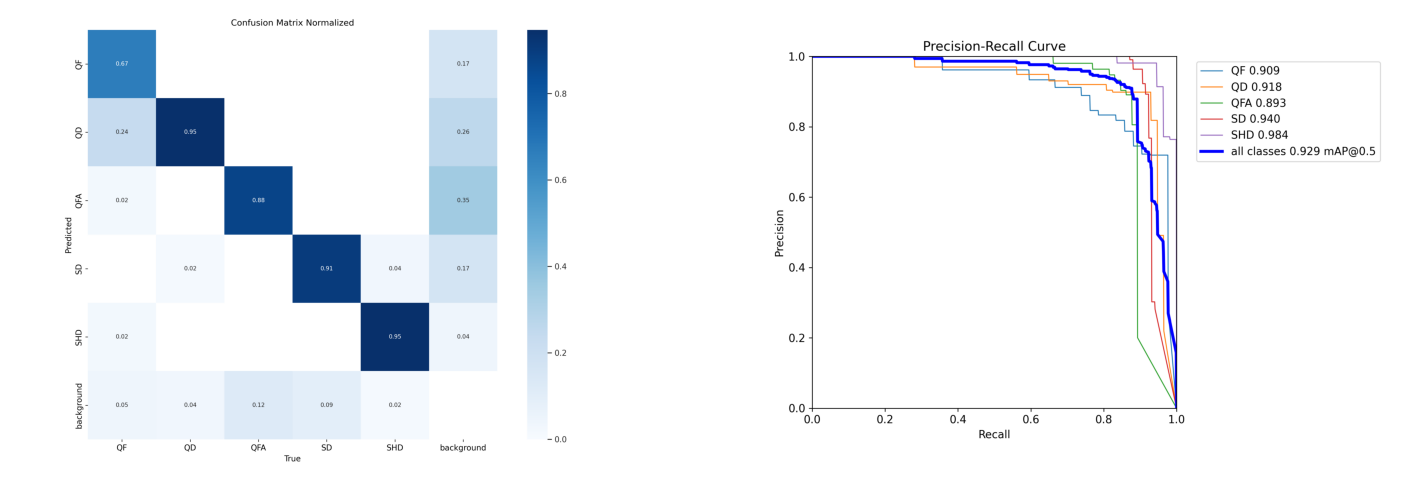

In [58]:
# Define paths to the confusion matrix and PR curve images for the last run
image_path_0 = f'alsu_magnet_classifier/{run_name}/confusion_matrix_normalized.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/PR_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)

# Create a figure to display both images side by side
plt.figure(figsize=(18, 6))

# Display the first image (confusion matrix) on the left
plt.subplot(1, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (PR curve) on the right
plt.subplot(1, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Show the images
plt.show()

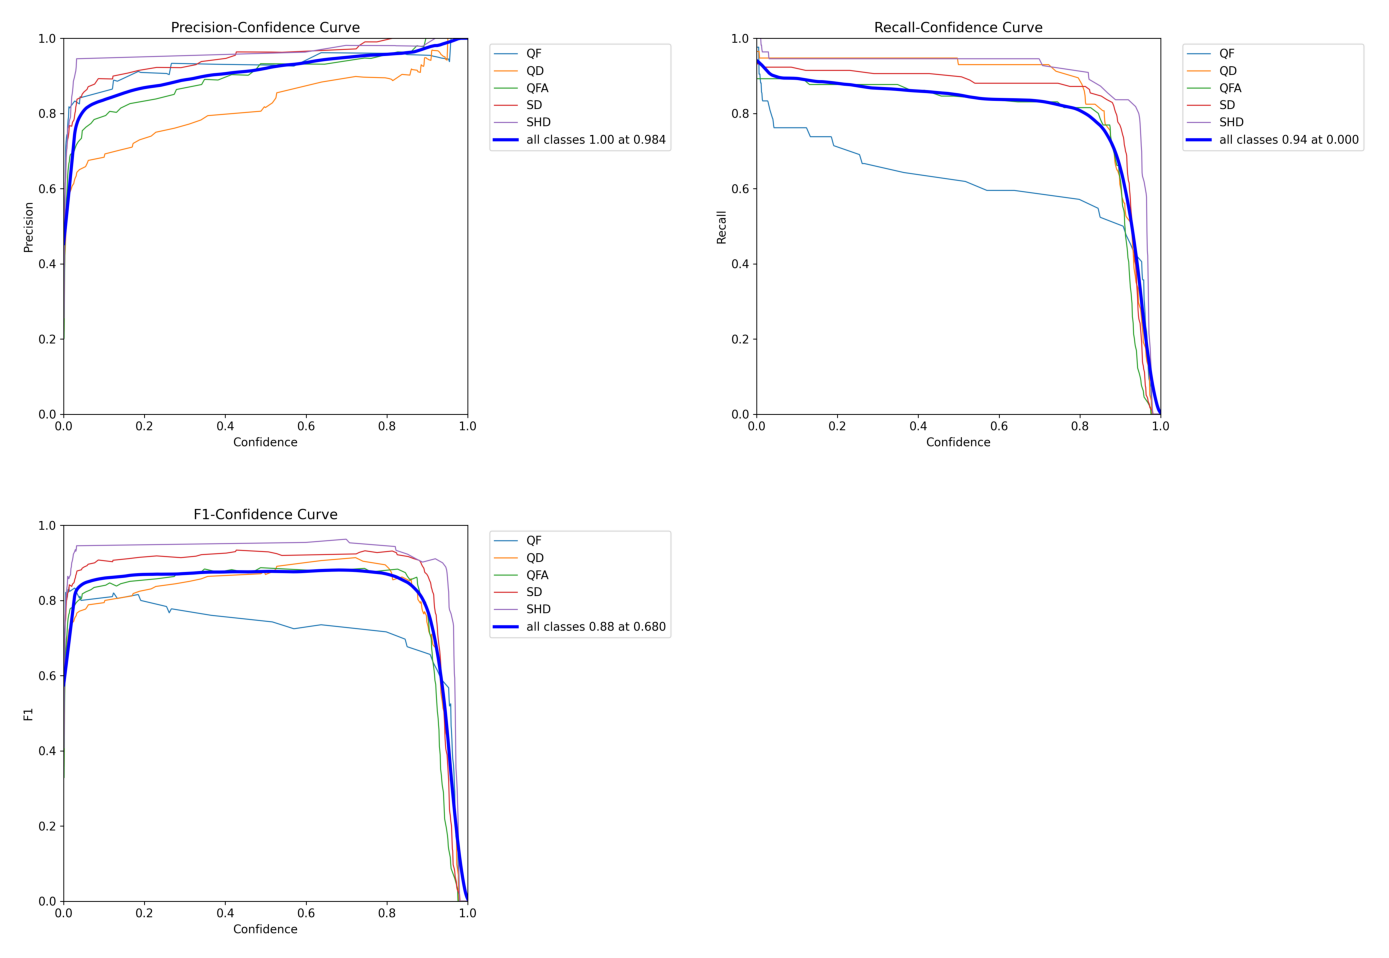

In [60]:
# Define paths to the performance graphs
image_path_0 = f'alsu_magnet_classifier/{run_name}/P_curve.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/R_curve.png'
image_path_2 = f'alsu_magnet_classifier/{run_name}/F1_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)
image2 = PilImage.open(image_path_2)

# Create a figure to display both images side by side
plt.figure(figsize=(14, 10))

# Display the first image (P curve)
plt.subplot(2, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (R curve)
plt.subplot(2, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Display the third image (F1 curve)
plt.subplot(2, 2, 3)
plt.imshow(image2)
plt.axis('off')  # Hide the axes

plt.tight_layout()

# Show the images
plt.show()

In [61]:
run_name = run_name + "_VAL" 

In [62]:
# Validate the model and save metrics
results_fullReal = model_fullReal.val(name=run_name)

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


                   all        240        336      0.947      0.835      0.929      0.754
                    QF         42         42      0.961      0.589       0.91      0.853
                    QD         57         57       0.89       0.93      0.918      0.716
                   QFA         65         65      0.936      0.831      0.893      0.523
                    SD         83        117      0.969       0.88       0.94      0.777
                   SHD         55         55      0.977      0.945      0.984      0.903
Speed: 0.4ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to alsu_magnet_classifier/fullReal_baggy-dandelion-owl_VAL


In [63]:
# Metrics or the model trained and validated with real images
fullReal_precision = results_fullReal.box.mp
fullReal_recall = results_fullReal.box.mr
fullReal_mAP50 = results_fullReal.box.map50
fullReal_f1 = 2 * (fullReal_precision * fullReal_recall) / (fullReal_precision + fullReal_recall)

In [64]:
print("Full Real model summary:")
print(f"Precision: {fullReal_precision:.3f}")
print(f"Recall: {fullReal_recall:.3f}")
print(f"mAP50: {fullReal_mAP50:.3f}")
print(f"F1: {fullReal_f1:.3f}")

Full Real model summary:
Precision: 0.947
Recall: 0.835
mAP50: 0.929
F1: 0.887


After the training process with real images, the validation using real images was successful. The performance values obtained here can be considered a benchmark. In principle, this could be regarded as the model to beat, or at least to approach.

### 4. A Small Full Real Model: Is There a Significant Drop in Performance?

The model investigated here is essentially the same as in the previous paragraph but with a much more limited set of training pictures. The training dataset consists of 5 photos per class, randomly selected. The validation dataset remains the same for reference. Five pictures is certainly a very limited number: the idea is to provide the model with a few field-taken pictures and observe how well it generalizes the information and abstracts a model.

In [69]:
n_real_train = 5  # Num Real Images in Train (per class)
n_real_val = 40  # Num Real Images in Val (per class)

In [70]:
# Delete all files in training and validation folders
for path in [train_path, val_path]:
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))

In [72]:
# Adding real-world images

#Train Dataset
all_train_QD_files = [f for f in os.listdir(train_QD_path) if f.endswith('.jpg')]
all_train_QF_files = [f for f in os.listdir(train_QF_path) if f.endswith('.jpg')]
all_train_QFA_files = [f for f in os.listdir(train_QFA_path) if f.endswith('.jpg')]
all_train_SD_files = [f for f in os.listdir(train_SD_path) if f.endswith('.jpg')]
all_train_SHD_files = [f for f in os.listdir(train_SHD_path) if f.endswith('.jpg')]
all_train_background_files = [f for f in os.listdir(train_background_path) if f.endswith('.jpg')]

#Val Dataset
all_val_QD_files = [f for f in os.listdir(val_QD_path) if f.endswith('.jpg')]
all_val_QF_files = [f for f in os.listdir(val_QF_path) if f.endswith('.jpg')]
all_val_QFA_files = [f for f in os.listdir(val_QFA_path) if f.endswith('.jpg')]
all_val_SD_files = [f for f in os.listdir(val_SD_path) if f.endswith('.jpg')]
all_val_SHD_files = [f for f in os.listdir(val_SHD_path) if f.endswith('.jpg')]
all_val_background_files = [f for f in os.listdir(val_background_path) if f.endswith('.jpg')]

pics_labels = load_labels(pics_labels_path)

In [73]:
# Random pick across the classes

# Preparing random images for train/val
train_QD_files = pick_random_files(all_train_QD_files, n_real_train)
train_QF_files = pick_random_files(all_train_QF_files, n_real_train)
train_QFA_files = pick_random_files(all_train_QFA_files, n_real_train)
train_SD_files = pick_random_files(all_train_SD_files, n_real_train)
train_SHD_files = pick_random_files(all_train_SHD_files, n_real_train)
train_background_files = pick_random_files(all_train_background_files, n_real_train)

val_QD_files = pick_random_files(all_val_QD_files, n_real_val)
val_QF_files = pick_random_files(all_val_QF_files, n_real_val)
val_QFA_files = pick_random_files(all_val_QFA_files, n_real_val)
val_SD_files = pick_random_files(all_val_SD_files, n_real_val)
val_SHD_files = pick_random_files(all_val_SHD_files, n_real_val)
val_background_files = pick_random_files(all_val_background_files, n_real_val)

In [74]:
# Copy files to their respective directories 
copy_files(train_QD_files, train_QD_path, train_path, pics_labels_path)
copy_files(train_QF_files, train_QF_path, train_path, pics_labels_path)
copy_files(train_QFA_files, train_QFA_path, train_path, pics_labels_path)
copy_files(train_SD_files, train_SD_path, train_path, pics_labels_path)
copy_files(train_SHD_files, train_SHD_path, train_path, pics_labels_path)
copy_files(train_background_files, train_background_path, train_path, pics_labels_path)

copy_files(val_QD_files, val_QD_path, val_path, pics_labels_path)
copy_files(val_QF_files, val_QF_path, val_path, pics_labels_path)
copy_files(val_QFA_files, val_QFA_path, val_path, pics_labels_path)
copy_files(val_SD_files, val_SD_path, val_path, pics_labels_path)
copy_files(val_SHD_files, val_SHD_path, val_path, pics_labels_path)
copy_files(val_background_files, val_background_path, val_path, pics_labels_path)

100%|██████████| 40/40 [00:03<00:00, 13.24it/s]


In [75]:
model_fullReal_5 = YOLO('/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt', task='detect', verbose=False)

In [76]:
run_name = f'fullReal_5_{namegenerator.gen()}'

Given the limited size of the training dataset (5 pictures per class + 5 for backgrounds, meaning 30 pictures in total), I reduce the size of the `batch` to 8. This allows the model to update its weights more frequently and can help in making the most out of such a limited amount of data.

In [77]:
# Train the model

print(80*'=')
print(80*'=')
print(f"Training model {run_name}")
print(80*'=')

model_fullReal_5.train(
    data=params.yolo_yaml_path, 
    lr0=0.01,
    epochs=100,  
    val=True,
    imgsz=1024,
    batch=8,
    device=[0, 1, 2, 3],
    name=run_name,
    project='alsu_magnet_classifier',
    save_dir='/global/homes/a/amorato/alsu_magnet_classifier/training_output/',
    )

Training model fullReal_5_sunny-orange-dunker
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=fullReal_5_sunny-orange-dunker, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=Fa

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240829_181226-b2bx35a8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fullReal_5_sunny-orange-dunker
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/b2bx35a8


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 326.57it/s]


val: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache
Plotting labels to alsu_magnet_classifier/fullReal_5_sunny-orange-dunker/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/fullReal_5_sunny-orange-dunker
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.724G      1.482      4.979       1.48          6       1024: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.30it/s]


                   all        240        362    0.00452      0.664    0.00843     0.0028

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.724G      1.755      4.609      1.714          6       1024: 100%|██████████| 4/4 [00:00<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.07it/s]


                   all        240        362    0.00492      0.647    0.00803    0.00298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.728G      1.828      4.221       1.77         10       1024: 100%|██████████| 4/4 [00:00<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.18it/s]


                   all        240        362     0.0053      0.653       0.01    0.00383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.778G      1.604      4.102      1.799         13       1024: 100%|██████████| 4/4 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.46it/s]


                   all        240        362    0.00623      0.673     0.0149    0.00626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.755G       1.38      4.689      1.637          2       1024: 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.88it/s]


                   all        240        362    0.00718      0.753     0.0285     0.0144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.757G      1.289      4.546      1.516          4       1024: 100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.32it/s]


                   all        240        362    0.00727      0.788     0.0396     0.0185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.778G      1.447      4.175      1.718         12       1024: 100%|██████████| 4/4 [00:00<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.96it/s]


                   all        240        362    0.00613      0.809     0.0649     0.0348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.757G      1.277      4.424      1.656          3       1024: 100%|██████████| 4/4 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.23it/s]


                   all        240        362    0.00573      0.827     0.0794     0.0463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.782G      1.262      4.025       1.53         24       1024: 100%|██████████| 4/4 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.49it/s]


                   all        240        362    0.00516       0.84     0.0946     0.0603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.778G      1.212      4.396      1.606         10       1024: 100%|██████████| 4/4 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.86it/s]


                   all        240        362    0.00495       0.86     0.0989     0.0608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      0.78G     0.9437      5.152      1.328          8       1024: 100%|██████████| 4/4 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.00it/s]


                   all        240        362    0.00479      0.871      0.112     0.0645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      0.78G     0.9737      4.216      1.488          7       1024: 100%|██████████| 4/4 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.21it/s]


                   all        240        362    0.00465      0.873      0.116     0.0692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.782G      1.098      3.645      1.412         17       1024: 100%|██████████| 4/4 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.58it/s]


                   all        240        362    0.00436      0.865      0.124     0.0774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.776G      1.095      3.745      1.379         15       1024: 100%|██████████| 4/4 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 35.73it/s]


                   all        240        362    0.00441      0.878       0.12     0.0758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.782G      1.033      4.137      1.384         22       1024: 100%|██████████| 4/4 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.47it/s]


                   all        240        362    0.00486      0.875      0.113      0.063

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.778G       1.26      3.659      1.574          6       1024: 100%|██████████| 4/4 [00:00<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.05it/s]


                   all        240        362    0.00486      0.875      0.113      0.063

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      0.78G      1.261      3.744      1.657          5       1024: 100%|██████████| 4/4 [00:00<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 31.96it/s]


                   all        240        362      0.701     0.0421       0.14     0.0778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.778G      1.158      5.657      1.578          5       1024: 100%|██████████| 4/4 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.87it/s]


                   all        240        362      0.553      0.122      0.184      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.782G     0.9343      3.291      1.297         11       1024: 100%|██████████| 4/4 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.04it/s]


                   all        240        362      0.553      0.122      0.184      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.782G      0.699       13.4     0.9948          0       1024: 100%|██████████| 4/4 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.81it/s]


                   all        240        362      0.277       0.19      0.202      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.782G      1.025      3.292      1.371         11       1024: 100%|██████████| 4/4 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.49it/s]


                   all        240        362      0.273      0.197      0.224      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.757G      1.118      3.847      1.361         14       1024: 100%|██████████| 4/4 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 31.42it/s]


                   all        240        362      0.273      0.197      0.224      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.782G       1.09       3.49      1.418          4       1024: 100%|██████████| 4/4 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.49it/s]


                   all        240        362      0.313      0.156      0.232      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.782G     0.9831      3.249      1.376          8       1024: 100%|██████████| 4/4 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.53it/s]


                   all        240        362      0.313      0.156      0.232      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.782G     0.9978      3.172      1.339          9       1024: 100%|██████████| 4/4 [00:00<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.78it/s]


                   all        240        362      0.329      0.121      0.232      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.782G      0.847      4.426       1.39          9       1024: 100%|██████████| 4/4 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 31.13it/s]


                   all        240        362      0.329      0.121      0.232      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.776G      1.222      3.487      1.682         11       1024: 100%|██████████| 4/4 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.02it/s]


                   all        240        362      0.401      0.166      0.245      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.778G      1.024      2.902      1.334          9       1024: 100%|██████████| 4/4 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 34.26it/s]


                   all        240        362      0.401      0.166      0.245      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.782G     0.9809      3.336      1.385          2       1024: 100%|██████████| 4/4 [00:00<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.69it/s]


                   all        240        362      0.308       0.26      0.246      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.778G       1.04      2.908      1.356          8       1024: 100%|██████████| 4/4 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.90it/s]


                   all        240        362      0.308       0.26      0.246      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.782G      0.772      4.395      1.245          8       1024: 100%|██████████| 4/4 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.36it/s]


                   all        240        362      0.295      0.372      0.265      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.778G      1.019      3.604      1.384          7       1024: 100%|██████████| 4/4 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.70it/s]


                   all        240        362      0.295      0.372      0.265      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.778G     0.7109      2.512      1.024          2       1024: 100%|██████████| 4/4 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.66it/s]


                   all        240        362      0.298       0.39        0.3       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      0.78G      0.941      2.861      1.334          6       1024: 100%|██████████| 4/4 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.72it/s]


                   all        240        362      0.298       0.39        0.3       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.782G     0.6831      2.569      1.105          3       1024: 100%|██████████| 4/4 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.53it/s]


                   all        240        362      0.321      0.412      0.328      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.782G     0.8294      3.146      1.285          6       1024: 100%|██████████| 4/4 [00:00<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.81it/s]


                   all        240        362      0.321      0.412      0.328      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.782G     0.6301      2.385      1.054          6       1024: 100%|██████████| 4/4 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.37it/s]


                   all        240        362      0.344      0.292      0.278      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.782G     0.6578      3.962      1.219         11       1024: 100%|██████████| 4/4 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 35.37it/s]


                   all        240        362      0.344      0.292      0.278      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.776G     0.9369      2.444      1.307          5       1024: 100%|██████████| 4/4 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 32.93it/s]


                   all        240        362      0.256      0.348      0.236      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      0.78G     0.8057      2.739      1.253          3       1024: 100%|██████████| 4/4 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.38it/s]


                   all        240        362      0.256      0.348      0.236      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.776G     0.8091      2.345      1.147         14       1024: 100%|██████████| 4/4 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.93it/s]


                   all        240        362      0.344      0.398      0.289      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.778G     0.9312      2.418      1.223         13       1024: 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.52it/s]


                   all        240        362      0.344      0.398      0.289      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.782G     0.8777      2.691        1.2          8       1024: 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 35.67it/s]


                   all        240        362       0.42      0.366      0.307      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      0.78G     0.9884      2.549      1.276         13       1024: 100%|██████████| 4/4 [00:00<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.68it/s]


                   all        240        362       0.42      0.366      0.307      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.776G     0.8283      2.011      1.123          8       1024: 100%|██████████| 4/4 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 30.54it/s]


                   all        240        362      0.367      0.378      0.314      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.782G     0.5769      2.778      1.027          5       1024: 100%|██████████| 4/4 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.78it/s]


                   all        240        362      0.367      0.378      0.314      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.776G     0.8405      2.121      1.222          9       1024: 100%|██████████| 4/4 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.22it/s]


                   all        240        362      0.327      0.324      0.297      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.782G     0.9734      2.119       1.18         13       1024: 100%|██████████| 4/4 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.88it/s]


                   all        240        362      0.327      0.324      0.297      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.782G     0.8539      2.244      1.165         20       1024: 100%|██████████| 4/4 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 39.62it/s]


                   all        240        362      0.282      0.343      0.297      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.782G      1.043      3.549      1.268         16       1024: 100%|██████████| 4/4 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.81it/s]


                   all        240        362      0.282      0.343      0.297      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.782G     0.9197      2.052       1.24         10       1024: 100%|██████████| 4/4 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.63it/s]


                   all        240        362      0.376      0.304      0.303      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      0.78G     0.8675      1.882       1.24         15       1024: 100%|██████████| 4/4 [00:00<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.15it/s]


                   all        240        362      0.376      0.304      0.303      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.778G      1.041      2.385       1.32          5       1024: 100%|██████████| 4/4 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.01it/s]


                   all        240        362      0.292      0.388      0.295      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.782G     0.8406      1.988       1.08         13       1024: 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.90it/s]


                   all        240        362      0.292      0.388      0.295      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.782G     0.8009      2.365      1.255          4       1024: 100%|██████████| 4/4 [00:00<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.03it/s]


                   all        240        362      0.293      0.334      0.267      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.782G     0.6656      1.961      1.139          8       1024: 100%|██████████| 4/4 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.39it/s]


                   all        240        362      0.293      0.334      0.267      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.778G     0.9688      1.956      1.303         12       1024: 100%|██████████| 4/4 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 39.10it/s]


                   all        240        362      0.285      0.396      0.285      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.776G     0.6803      2.025      1.038         13       1024: 100%|██████████| 4/4 [00:00<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 39.70it/s]


                   all        240        362      0.285      0.396      0.285      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.782G     0.7341      2.404      1.151          9       1024: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 40.05it/s]


                   all        240        362      0.346      0.368      0.308      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.778G     0.7274      2.373      1.248          3       1024: 100%|██████████| 4/4 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 40.13it/s]


                   all        240        362      0.346      0.368      0.308      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.782G     0.7648      1.846      1.145         15       1024: 100%|██████████| 4/4 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 39.98it/s]


                   all        240        362      0.358      0.391      0.347       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      0.78G     0.5102      2.433      1.025          4       1024: 100%|██████████| 4/4 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.85it/s]


                   all        240        362      0.358      0.391      0.347       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      0.78G     0.5084      1.962     0.9906         17       1024: 100%|██████████| 4/4 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.02it/s]


                   all        240        362      0.358      0.397      0.363      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.778G     0.8108      2.359      1.135          3       1024: 100%|██████████| 4/4 [00:00<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.82it/s]


                   all        240        362      0.358      0.397      0.363      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.776G     0.7504      3.796      1.133         12       1024: 100%|██████████| 4/4 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.46it/s]


                   all        240        362      0.485      0.339      0.377      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      0.78G      0.909      1.902      1.141          7       1024: 100%|██████████| 4/4 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 33.86it/s]


                   all        240        362      0.485      0.339      0.377      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.782G     0.7162      2.339      1.279          3       1024: 100%|██████████| 4/4 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.36it/s]


                   all        240        362      0.426      0.369      0.375      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.782G     0.5482      2.499      1.018         11       1024: 100%|██████████| 4/4 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.39it/s]


                   all        240        362      0.426      0.369      0.375      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.782G     0.6773      1.901      1.118         11       1024: 100%|██████████| 4/4 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.38it/s]


                   all        240        362      0.483      0.313      0.362       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.776G     0.6094      1.399     0.9632         10       1024: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.03it/s]


                   all        240        362      0.483      0.313      0.362       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      0.78G     0.6705      1.986      1.051          8       1024: 100%|██████████| 4/4 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.69it/s]


                   all        240        362      0.393      0.352      0.341      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.776G     0.5378      2.027      1.072         11       1024: 100%|██████████| 4/4 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.70it/s]


                   all        240        362      0.393      0.352      0.341      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.782G     0.6584       1.92      1.012          7       1024: 100%|██████████| 4/4 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.90it/s]


                   all        240        362      0.393      0.357      0.329      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.782G     0.7204      2.173      1.136          8       1024: 100%|██████████| 4/4 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.97it/s]


                   all        240        362      0.393      0.357      0.329      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      0.78G     0.6838      1.903      1.033         13       1024: 100%|██████████| 4/4 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.17it/s]


                   all        240        362      0.409      0.343       0.33       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.778G     0.6399      1.798      1.129          6       1024: 100%|██████████| 4/4 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.62it/s]


                   all        240        362      0.409      0.343       0.33       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.778G     0.8372        1.8      1.221          9       1024: 100%|██████████| 4/4 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.11it/s]


                   all        240        362      0.544      0.325      0.356      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.778G       0.57      1.917      1.023          6       1024: 100%|██████████| 4/4 [00:00<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.81it/s]


                   all        240        362      0.544      0.325      0.356      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.782G     0.7114      1.971      1.147          6       1024: 100%|██████████| 4/4 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.71it/s]


                   all        240        362      0.554      0.341      0.392      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.782G     0.6087      1.763      1.104          9       1024: 100%|██████████| 4/4 [00:00<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.46it/s]


                   all        240        362      0.554      0.341      0.392      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.782G     0.8012      2.434       1.26          4       1024: 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.41it/s]


                   all        240        362      0.571      0.349      0.422      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.782G     0.4429      1.628     0.9141          6       1024: 100%|██████████| 4/4 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.94it/s]


                   all        240        362      0.571      0.349      0.422      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.782G     0.5647      1.497       1.04          5       1024: 100%|██████████| 4/4 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.87it/s]


                   all        240        362      0.466      0.443       0.44      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.782G     0.6336      1.999       1.08          7       1024: 100%|██████████| 4/4 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.50it/s]


                   all        240        362      0.466      0.443       0.44      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.782G     0.4633      10.04      0.765          9       1024: 100%|██████████| 4/4 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.36it/s]


                   all        240        362      0.475      0.462      0.453      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.778G     0.6822      1.504      1.088         10       1024: 100%|██████████| 4/4 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.26it/s]


                   all        240        362      0.475      0.462      0.453      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.784G     0.6721      1.326      1.056         11       1024: 100%|██████████| 4/4 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.14it/s]


                   all        240        362      0.544      0.414      0.464      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.782G     0.5287      2.155      1.122         10       1024: 100%|██████████| 4/4 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 35.91it/s]


                   all        240        362      0.544      0.414      0.464      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.778G     0.7055      2.034      1.235          3       1024: 100%|██████████| 4/4 [00:00<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.15it/s]


                   all        240        362      0.549      0.423      0.465      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      0.78G      0.531      1.867      1.052          8       1024: 100%|██████████| 4/4 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 32.54it/s]


                   all        240        362      0.549      0.423      0.465      0.286
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.755G     0.6069      10.38     0.9236          4       1024: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.41it/s]


                   all        240        362      0.492      0.454      0.469      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.734G     0.4365      10.18     0.7386          5       1024: 100%|██████████| 4/4 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.28it/s]


                   all        240        362      0.492      0.454      0.469      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.732G     0.4916      10.04      0.803          5       1024: 100%|██████████| 4/4 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 39.14it/s]


                   all        240        362      0.466      0.458      0.462      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.732G     0.4285      10.29      0.835          5       1024: 100%|██████████| 4/4 [00:00<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 39.71it/s]


                   all        240        362      0.466      0.458      0.462      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.732G     0.3906      10.02     0.6814          5       1024: 100%|██████████| 4/4 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.54it/s]


                   all        240        362      0.467      0.478      0.459      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.784G     0.5479      3.243     0.9474          5       1024: 100%|██████████| 4/4 [00:00<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 37.33it/s]


                   all        240        362      0.467      0.478      0.459      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.782G     0.5383      3.563      1.184          2       1024: 100%|██████████| 4/4 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.05it/s]


                   all        240        362       0.43      0.497      0.447      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.782G     0.4669      10.38     0.9009          5       1024: 100%|██████████| 4/4 [00:00<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.80it/s]


                   all        240        362       0.43      0.497      0.447      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      0.78G     0.4137        3.1      0.956          2       1024: 100%|██████████| 4/4 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.21it/s]


                   all        240        362      0.416      0.485      0.442      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.732G     0.4178      10.26     0.8541          2       1024: 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 36.26it/s]


                   all        240        362      0.416      0.485      0.442      0.276

100 epochs completed in 0.072 hours.
Optimizer stripped from alsu_magnet_classifier/fullReal_5_sunny-orange-dunker/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/fullReal_5_sunny-orange-dunker/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/fullReal_5_sunny-orange-dunker/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:01<00:00, 38.61it/s]


                   all        240        362      0.544      0.414      0.464      0.287
                    QF         42         42      0.511      0.333      0.392      0.343
                    QD         58         59      0.335      0.393      0.289      0.127
                   QFA         66         66      0.718      0.424      0.558      0.253
                    SD         96        134      0.647      0.672      0.694      0.424
                   SHD         61         61      0.509      0.246      0.386      0.289
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to alsu_magnet_classifier/fullReal_5_sunny-orange-dunker


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg1 ▁▂▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg2 ▁▂▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▁▁▂▃▃▃▄▄▄▄▅▅▅▆▄▅▆▆▅▅▅▅▆▆▆▇▆▆▆▆▇▇███████
wandb:     metrics/mAP50-95(B) ▁▁▁▂▃▃▂▄▄▅▄▄▅▅▆▄▅▅▅▅▅▅▅▅▆▆▇▆▆▅▆▆▇▇██████
wandb:    metrics/precision(B) ▁▁▁▁▁▁▁█▄▅▅▆▅▅▅▄▅▆▅▄▆▅▅▅▅▅▆▇▆▆███▇██▇▇▆█
wandb:       metrics/recall(B) ▆▆▇████▁▂��▁▁▃▃▄▃▄▃▃▃▃▃▃▃▄▄▃▃▃▃▃▃▃▄▄▄▄▄▄▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▅▅▄▄▅▅▄▄▃▄▃▄▃▄▃▄▂▃▃▃▂▃▃▃▂▂▂▃▃▂▁▂▂▂▁▁▂▁
wandb:          train/cls_loss ▄▃▄▃▄▃▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▁▂▁▂▁▂██▃█
wandb:          train/dfl_loss ▆█▆▇▅▆▇▇▅▆▅▅▄▅▅▅▄▅▃▄▄▃▄▄▄▄▅▄▃▄▄▄▂▃▃▄▁▂▄▂
wandb:            val/box_loss █▇▃▁▂▁▃▂▂▂▂▂▃▃▃▄▅▅▆▇▆▆▆▆▅▅▄▄▅▅▅▄▄▃

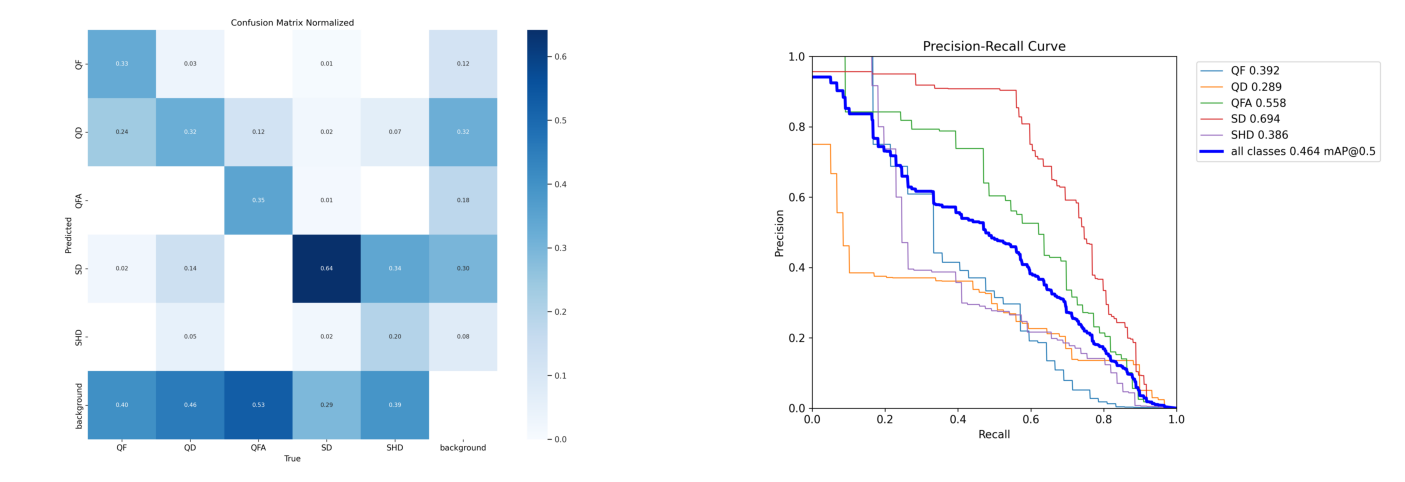

In [78]:
# Define paths to the confusion matrix and PR curve images for the last run
image_path_0 = f'alsu_magnet_classifier/{run_name}/confusion_matrix_normalized.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/PR_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)

# Create a figure to display both images side by side
plt.figure(figsize=(18, 6))

# Display the first image (confusion matrix) on the left
plt.subplot(1, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (PR curve) on the right
plt.subplot(1, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Show the images
plt.show()

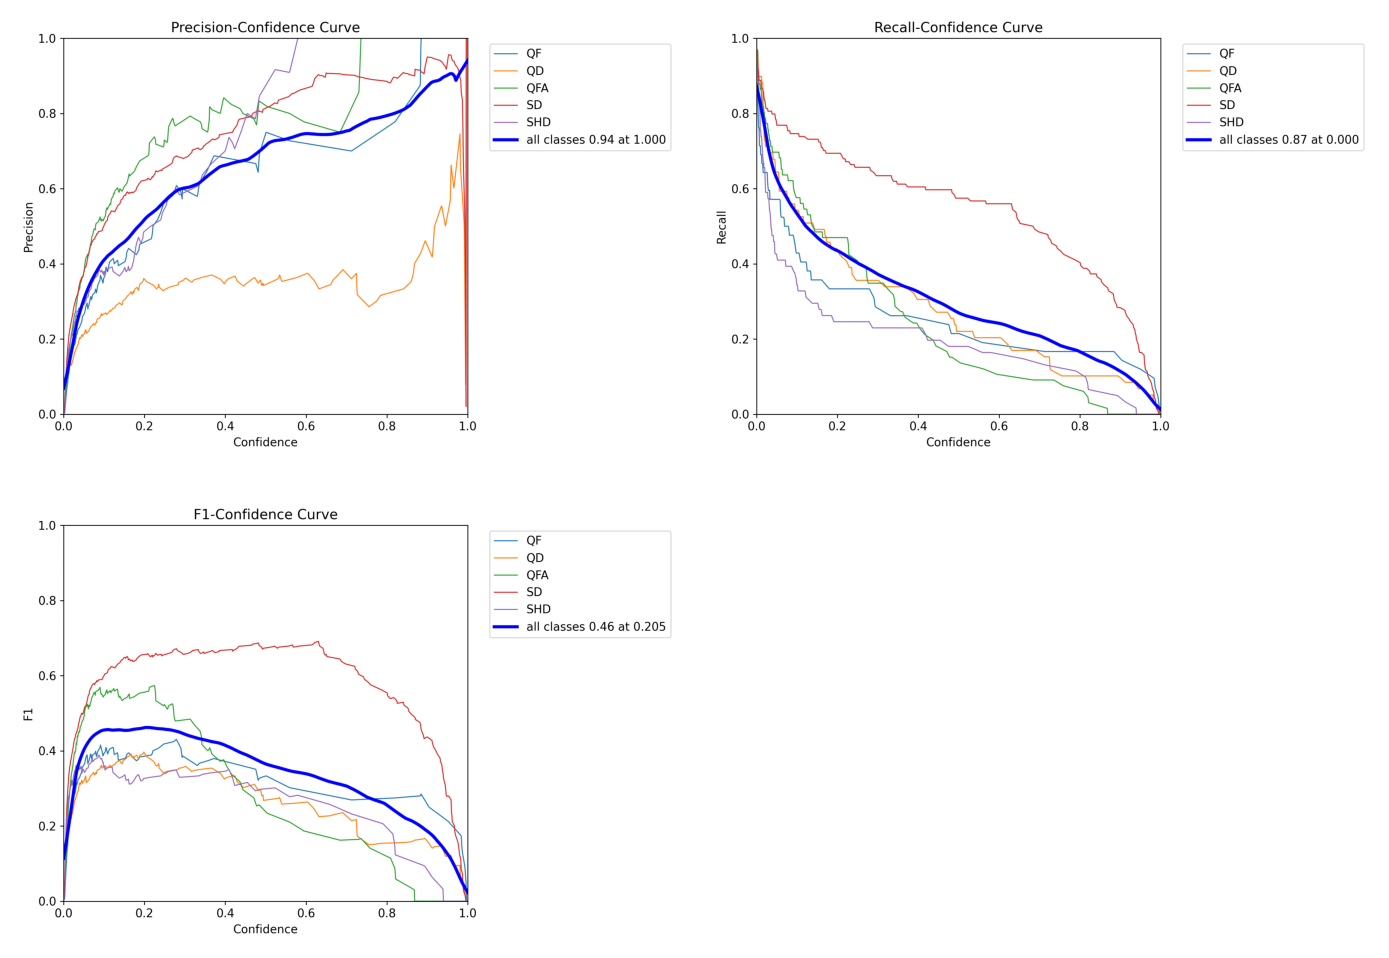

In [79]:
# Define paths to the performance graphs
image_path_0 = f'alsu_magnet_classifier/{run_name}/P_curve.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/R_curve.png'
image_path_2 = f'alsu_magnet_classifier/{run_name}/F1_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)
image2 = PilImage.open(image_path_2)

# Create a figure to display both images side by side
plt.figure(figsize=(14, 10))

# Display the first image (P curve)
plt.subplot(2, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (R curve)
plt.subplot(2, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Display the third image (F1 curve)
plt.subplot(2, 2, 3)
plt.imshow(image2)
plt.axis('off')  # Hide the axes

plt.tight_layout()

# Show the images
plt.show()

In [80]:
run_name = run_name + "_VAL" 

In [81]:
# Validate the model and save metrics
results_fullReal_5 = model_fullReal_5.val(name=run_name)

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:06<00:00,  4.80it/s]


                   all        240        362      0.546       0.41      0.464      0.286
                    QF         42         42      0.521      0.333      0.392      0.341
                    QD         58         59      0.335      0.385       0.29      0.128
                   QFA         66         66      0.716       0.42      0.558      0.252
                    SD         96        134      0.646      0.664      0.695      0.423
                   SHD         61         61      0.512      0.246      0.387      0.286
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to alsu_magnet_classifier/fullReal_5_sunny-orange-dunker_VAL


In [82]:
# Metrics or the model trained with 5 real images per class
fullReal_5_precision = results_fullReal_5.box.mp
fullReal_5_recall = results_fullReal_5.box.mr
fullReal_5_mAP50 = results_fullReal_5.box.map50
fullReal_5_f1 = 2 * (fullReal_5_precision * fullReal_5_recall) / (fullReal_5_precision + fullReal_5_recall)

In [171]:
print("Full Real (Reduced) Model Summary:")
print(f"Precision: {fullReal_5_precision:.3f}")
print(f"Recall: {fullReal_5_recall:.3f}")
print(f"mAP50: {fullReal_5_mAP50:.3f}")
print(f"F1: {fullReal_5_f1:.3f}")

Full Real (Reduced) Model Summary:
Precision: 0.546
Recall: 0.410
mAP50: 0.464
F1: 0.468


The limited training dataset exhibits a dramatic drop in performance. While this model itself may not be of particular interest, it is intriguing to see if its metrics can improve by reinforcing the model with artificial CAD data, as investigated in the next paragraph.

### 5. A Limited Real Dataset Reinforced with a Set of CAD Images

This is the same model of paragraph 4, but with the addition of 150 random CAD images. The CAD images are picked while keeping a good balance among classes. 150 is an arbitrary choice: the real pictures involved in the training are 30 (5 * 5 classes + 5 backgrounds). A factor 5 is selected to determine how many CAD images have to be loaded.

In [84]:
n_train = 150 # Num CAD Images in Train (total number)

n_real_train = 5  # Num Real Images in Train (per class)
n_real_val = 40  # Num Real Images in Val (per class)

In [85]:
# Delete all files in training and validation folders
for path in [train_path, val_path]:
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))

In [86]:
# Adding CAD images from images folder
image_files = [f for f in os.listdir(images_path) if f.endswith('.png')]
labels = load_labels(labels_path)

# Preparing balanced random images for train
train_files = balance_classes(image_files, labels, n_train)

# Copy files to their respective directories 
copy_files(train_files, images_path, train_path, labels_path)

100%|██████████| 150/150 [00:10<00:00, 13.86it/s]


In [87]:
# Adding real-world images

#Train Dataset
all_train_QD_files = [f for f in os.listdir(train_QD_path) if f.endswith('.jpg')]
all_train_QF_files = [f for f in os.listdir(train_QF_path) if f.endswith('.jpg')]
all_train_QFA_files = [f for f in os.listdir(train_QFA_path) if f.endswith('.jpg')]
all_train_SD_files = [f for f in os.listdir(train_SD_path) if f.endswith('.jpg')]
all_train_SHD_files = [f for f in os.listdir(train_SHD_path) if f.endswith('.jpg')]
all_train_background_files = [f for f in os.listdir(train_background_path) if f.endswith('.jpg')]

#Val Dataset
all_val_QD_files = [f for f in os.listdir(val_QD_path) if f.endswith('.jpg')]
all_val_QF_files = [f for f in os.listdir(val_QF_path) if f.endswith('.jpg')]
all_val_QFA_files = [f for f in os.listdir(val_QFA_path) if f.endswith('.jpg')]
all_val_SD_files = [f for f in os.listdir(val_SD_path) if f.endswith('.jpg')]
all_val_SHD_files = [f for f in os.listdir(val_SHD_path) if f.endswith('.jpg')]
all_val_background_files = [f for f in os.listdir(val_background_path) if f.endswith('.jpg')]

pics_labels = load_labels(pics_labels_path)

In [88]:
# Random Pick across the classes

# Preparing random images for train/val
train_QD_files = pick_random_files(all_train_QD_files, n_real_train)
train_QF_files = pick_random_files(all_train_QF_files, n_real_train)
train_QFA_files = pick_random_files(all_train_QFA_files, n_real_train)
train_SD_files = pick_random_files(all_train_SD_files, n_real_train)
train_SHD_files = pick_random_files(all_train_SHD_files, n_real_train)
train_background_files = pick_random_files(all_train_background_files, n_real_train)

val_QD_files = pick_random_files(all_val_QD_files, n_real_val)
val_QF_files = pick_random_files(all_val_QF_files, n_real_val)
val_QFA_files = pick_random_files(all_val_QFA_files, n_real_val)
val_SD_files = pick_random_files(all_val_SD_files, n_real_val)
val_SHD_files = pick_random_files(all_val_SHD_files, n_real_val)
val_background_files = pick_random_files(all_val_background_files, n_real_val)

In [89]:
# Copy files to their respective directories 
copy_files(train_QD_files, train_QD_path, train_path, pics_labels_path)
copy_files(train_QF_files, train_QF_path, train_path, pics_labels_path)
copy_files(train_QFA_files, train_QFA_path, train_path, pics_labels_path)
copy_files(train_SD_files, train_SD_path, train_path, pics_labels_path)
copy_files(train_SHD_files, train_SHD_path, train_path, pics_labels_path)
copy_files(train_background_files, train_background_path, train_path, pics_labels_path)

copy_files(val_QD_files, val_QD_path, val_path, pics_labels_path)
copy_files(val_QF_files, val_QF_path, val_path, pics_labels_path)
copy_files(val_QFA_files, val_QFA_path, val_path, pics_labels_path)
copy_files(val_SD_files, val_SD_path, val_path, pics_labels_path)
copy_files(val_SHD_files, val_SHD_path, val_path, pics_labels_path)
copy_files(val_background_files, val_background_path, val_path, pics_labels_path)

100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


In [90]:
model_mixed_5r_150cad = YOLO('/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt', task='detect', verbose=False)

In [91]:
run_name=f'mixed_5r_150cad_{namegenerator.gen()}'

Even if a relevant amount of artificial CAD images has been added, the train dataset is still limited. Therefore I prefer not to use the common batch 64, but a smaller 32 value.

In [92]:
# Train the model

print(80*'=')
print(80*'=')
print(f"Training model {run_name}")
print(80*'=')

model_mixed_5r_150cad.train(
    data=params.yolo_yaml_path, 
    lr0=0.01,
    epochs=100,  
    val=True,
    imgsz=1024,
    batch=32,
    device=[0, 1, 2, 3],
    name=run_name,
    project='alsu_magnet_classifier',
    save_dir='/global/homes/a/amorato/alsu_magnet_classifier/training_output/',
    )

Training model mixed_5r_150cad_shabby-champagne-cow
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=mixed_5r_150cad_shabby-champagne-cow, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240829_183556-tzkuii2v
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run mixed_5r_150cad_shabby-champagne-cow
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/tzkuii2v


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 432.95it/s]


val: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache
Plotting labels to alsu_magnet_classifier/mixed_5r_150cad_shabby-champagne-cow/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/mixed_5r_150cad_shabby-champagne-cow
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.59G      2.162      5.563      2.552         14       1024: 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 16.81it/s]


                   all        240        318    0.00452      0.702    0.00803    0.00321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.61G      2.497       6.05      2.861          9       1024: 100%|██████████| 6/6 [00:00<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


                   all        240        318    0.00485      0.647    0.00666    0.00294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.66G     0.8801      3.905      1.578          9       1024: 100%|██████████| 6/6 [00:00<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.70it/s]


                   all        240        318    0.00435        0.6     0.0102    0.00499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.62G     0.8318      3.865      1.567         16       1024: 100%|██████████| 6/6 [00:00<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


                   all        240        318    0.00582      0.746     0.0438     0.0216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.62G     0.7768      3.381      1.447         15       1024: 100%|██████████| 6/6 [00:00<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


                   all        240        318    0.00604      0.809     0.0549     0.0252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.62G     0.8334      3.209      1.343         16       1024: 100%|██████████| 6/6 [00:00<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


                   all        240        318    0.00614      0.855      0.105     0.0512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.68G     0.8854       3.22      1.474         19       1024: 100%|██████████| 6/6 [00:00<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


                   all        240        318     0.0043      0.846     0.0857      0.039

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.64G     0.7264      2.916      1.317         13       1024: 100%|██████████| 6/6 [00:00<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.77it/s]


                   all        240        318    0.00421      0.814     0.0905     0.0364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.65G     0.8216      2.713      1.351         20       1024: 100%|██████████| 6/6 [00:00<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.98it/s]


                   all        240        318      0.694      0.135      0.153     0.0895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.63G     0.7421        2.7      1.357         16       1024: 100%|██████████| 6/6 [00:00<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.97it/s]


                   all        240        318      0.303     0.0906      0.123     0.0659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.65G     0.7241      2.484      1.325         15       1024: 100%|██████████| 6/6 [00:00<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 17.96it/s]


                   all        240        318      0.224      0.181      0.214      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.63G     0.7754      2.615       1.39          8       1024: 100%|██████████| 6/6 [00:00<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.74it/s]


                   all        240        318      0.485      0.167      0.143     0.0768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.65G       0.81      2.508      1.253         30       1024: 100%|██████████| 6/6 [00:00<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


                   all        240        318      0.209      0.255      0.184      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.65G       0.62      2.348      1.256         12       1024: 100%|██████████| 6/6 [00:00<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.58it/s]


                   all        240        318      0.547      0.152       0.11     0.0631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.63G     0.7261       2.33      1.378         10       1024: 100%|██████████| 6/6 [00:00<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


                   all        240        318      0.365      0.148      0.187      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.63G     0.7134       2.32      1.382         18       1024: 100%|██████████| 6/6 [00:00<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.63it/s]


                   all        240        318      0.515      0.185      0.135     0.0777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.64G     0.8063      2.214      1.363         13       1024: 100%|██████████| 6/6 [00:00<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.10it/s]


                   all        240        318      0.148        0.2     0.0499     0.0257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.63G      0.678      2.145      1.267         14       1024: 100%|██████████| 6/6 [00:00<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.53it/s]


                   all        240        318      0.177      0.197     0.0687     0.0398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.65G     0.6112      1.975       1.19         14       1024: 100%|██████████| 6/6 [00:00<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.17it/s]


                   all        240        318      0.304      0.086     0.0664     0.0439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.63G     0.6597      2.073      1.301          9       1024: 100%|██████████| 6/6 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.04it/s]


                   all        240        318      0.232     0.0821     0.0852     0.0584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.63G      0.624       1.77      1.193         11       1024: 100%|██████████| 6/6 [00:00<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.75it/s]


                   all        240        318      0.175       0.22      0.134     0.0836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.63G     0.5609      1.728      1.142         18       1024: 100%|██████████| 6/6 [00:00<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


                   all        240        318      0.519      0.351      0.354      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.63G     0.6821      1.785      1.304         17       1024: 100%|██████████| 6/6 [00:00<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.68it/s]


                   all        240        318      0.352       0.27      0.236      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.67G     0.6942       1.68      1.265         13       1024: 100%|██████████| 6/6 [00:00<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


                   all        240        318      0.513      0.321      0.343      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.63G     0.6828      1.682      1.201         12       1024: 100%|██████████| 6/6 [00:00<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


                   all        240        318      0.448      0.387      0.383      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.63G      0.592      1.624      1.224         14       1024: 100%|██████████| 6/6 [00:00<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


                   all        240        318      0.406      0.407      0.385      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.63G     0.5813      1.566      1.207         17       1024: 100%|██████████| 6/6 [00:00<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


                   all        240        318      0.343      0.346      0.252      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.63G     0.6138      1.553      1.172         16       1024: 100%|██████████| 6/6 [00:00<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


                   all        240        318      0.587      0.376      0.408      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.65G     0.6632      1.639      1.307          8       1024: 100%|██████████| 6/6 [00:00<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


                   all        240        318        0.6      0.561      0.574        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.63G      0.561      1.531      1.211         17       1024: 100%|██████████| 6/6 [00:00<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.95it/s]


                   all        240        318      0.385      0.473      0.379      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.62G     0.6889      1.538       1.22         22       1024: 100%|██████████| 6/6 [00:00<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.40it/s]


                   all        240        318      0.593       0.43      0.458      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.65G     0.5637      1.361      1.139         10       1024: 100%|██████████| 6/6 [00:00<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.02it/s]


                   all        240        318      0.593      0.518      0.545      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.63G     0.5409      1.373      1.174         12       1024: 100%|██████████| 6/6 [00:00<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.06it/s]


                   all        240        318      0.554      0.573      0.543      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.65G      0.596      1.354      1.165         13       1024: 100%|██████████| 6/6 [00:00<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.24it/s]


                   all        240        318      0.526      0.568      0.582      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.62G     0.6223      1.503      1.186         17       1024: 100%|██████████| 6/6 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.96it/s]


                   all        240        318        0.4       0.37      0.319       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.63G     0.5435      1.417       1.16         11       1024: 100%|██████████| 6/6 [00:00<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.60it/s]


                   all        240        318      0.387      0.327      0.304      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.63G     0.4776      1.115      1.062         13       1024: 100%|██████████| 6/6 [00:00<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.84it/s]


                   all        240        318      0.599      0.585      0.571      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.63G     0.6011      1.355       1.18         20       1024: 100%|██████████| 6/6 [00:00<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.41it/s]


                   all        240        318      0.628      0.518      0.538      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.63G     0.5687      1.318      1.215          8       1024: 100%|██████████| 6/6 [00:00<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.40it/s]


                   all        240        318      0.616      0.614      0.647       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.63G     0.5844      1.289      1.208          8       1024: 100%|██████████| 6/6 [00:00<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.85it/s]


                   all        240        318      0.484      0.397      0.382      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.63G     0.5331      1.133      1.126         17       1024: 100%|██████████| 6/6 [00:00<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.75it/s]


                   all        240        318      0.302      0.381      0.298      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.67G     0.5483      1.234      1.129         18       1024: 100%|██████████| 6/6 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.65it/s]


                   all        240        318      0.467      0.347      0.349      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.63G     0.5699      1.366      1.227         11       1024: 100%|██████████| 6/6 [00:00<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.18it/s]


                   all        240        318      0.679      0.543      0.648       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.63G     0.6422      1.217      1.184         16       1024: 100%|██████████| 6/6 [00:00<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.68it/s]


                   all        240        318      0.683      0.613      0.685      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.63G     0.4772       1.09      1.123         14       1024: 100%|██████████| 6/6 [00:00<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.74it/s]


                   all        240        318      0.582      0.598       0.64       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.63G     0.4877      1.026      1.042         14       1024: 100%|██████████| 6/6 [00:00<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.97it/s]


                   all        240        318      0.643      0.624       0.66      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.62G     0.6115      1.191      1.179         11       1024: 100%|██████████| 6/6 [00:00<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.47it/s]


                   all        240        318      0.687      0.667      0.703      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.63G     0.5311      1.167      1.177         12       1024: 100%|██████████| 6/6 [00:00<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.81it/s]


                   all        240        318      0.741       0.65      0.732      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.65G     0.4305     0.9169      1.025         11       1024: 100%|██████████| 6/6 [00:00<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.70it/s]


                   all        240        318      0.691      0.657      0.735      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.63G     0.5135     0.9799      1.107         21       1024: 100%|██████████| 6/6 [00:00<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.68it/s]


                   all        240        318        0.7      0.626       0.72       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.63G      0.561      1.124       1.18         15       1024: 100%|██████████| 6/6 [00:00<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.60it/s]


                   all        240        318      0.619      0.536      0.582      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.65G     0.4942     0.9973      1.118         14       1024: 100%|██████████| 6/6 [00:00<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.53it/s]


                   all        240        318      0.676      0.578      0.634      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.63G     0.4251     0.9181      1.113         15       1024: 100%|██████████| 6/6 [00:00<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.27it/s]


                   all        240        318      0.699      0.654      0.712      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.65G     0.4913     0.9122      1.105         13       1024: 100%|██████████| 6/6 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.01it/s]


                   all        240        318      0.703      0.628      0.699      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.65G     0.4434     0.9711      1.104          9       1024: 100%|██████████| 6/6 [00:00<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.43it/s]


                   all        240        318      0.611      0.643      0.629      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.65G     0.4982      1.019      1.175         11       1024: 100%|██████████| 6/6 [00:00<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.41it/s]


                   all        240        318       0.62      0.658       0.67      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.65G     0.5475      1.015      1.159         14       1024: 100%|██████████| 6/6 [00:00<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.90it/s]


                   all        240        318      0.686      0.666      0.693       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.63G     0.4884     0.8921      1.106         21       1024: 100%|██████████| 6/6 [00:00<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 21.01it/s]


                   all        240        318      0.734      0.694      0.765      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.65G     0.4714      0.839      1.112         16       1024: 100%|██████████| 6/6 [00:00<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.53it/s]


                   all        240        318      0.752      0.674      0.754      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.75G     0.4883      0.965      1.083         11       1024: 100%|██████████| 6/6 [00:00<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.37it/s]


                   all        240        318      0.745      0.637      0.733      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.65G     0.4213     0.8243      1.048         19       1024: 100%|██████████| 6/6 [00:00<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.63it/s]


                   all        240        318      0.664      0.599       0.68      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.63G     0.4771     0.8763       1.14         14       1024: 100%|██████████| 6/6 [00:00<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.60it/s]


                   all        240        318      0.661      0.565      0.605      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.63G     0.4329     0.8195      1.095         14       1024: 100%|██████████| 6/6 [00:00<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.93it/s]


                   all        240        318      0.571      0.509      0.497      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.65G     0.4759     0.9132      1.073         12       1024: 100%|██████████| 6/6 [00:00<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.81it/s]


                   all        240        318      0.553      0.578      0.547      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.63G      0.437     0.7374      1.039         20       1024: 100%|██████████| 6/6 [00:00<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.65it/s]


                   all        240        318      0.762      0.614      0.699       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.65G     0.4708     0.8692      1.074         14       1024: 100%|██████████| 6/6 [00:00<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.55it/s]


                   all        240        318      0.702      0.727      0.766      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.63G      0.399     0.7569     0.9908         16       1024: 100%|██████████| 6/6 [00:00<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 21.06it/s]


                   all        240        318      0.761      0.649      0.751      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.62G     0.4556     0.7787      1.118         10       1024: 100%|██████████| 6/6 [00:00<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.55it/s]


                   all        240        318      0.748       0.67      0.751      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.65G     0.4372     0.7404      1.053         19       1024: 100%|██████████| 6/6 [00:00<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 21.08it/s]


                   all        240        318      0.757      0.711      0.773      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.65G     0.5155     0.8321      1.115         14       1024: 100%|██████████| 6/6 [00:00<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.75it/s]


                   all        240        318      0.767      0.664      0.771      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.62G     0.4266     0.7864      1.093         15       1024: 100%|██████████| 6/6 [00:00<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.84it/s]


                   all        240        318      0.799      0.677      0.778      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.62G     0.3467     0.6582      1.052         16       1024: 100%|██████████| 6/6 [00:00<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.46it/s]


                   all        240        318      0.791        0.7        0.8      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.75G     0.4487     0.7527      1.092         19       1024: 100%|██████████| 6/6 [00:00<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.94it/s]


                   all        240        318      0.754      0.676      0.783      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.75G     0.4829     0.7539      1.037         36       1024: 100%|██████████| 6/6 [00:00<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.76it/s]


                   all        240        318      0.733       0.56      0.703      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.73G     0.4125     0.6841      1.067         18       1024: 100%|██████████| 6/6 [00:00<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 21.01it/s]


                   all        240        318      0.674      0.566      0.683      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.63G     0.4345      0.742      1.125         11       1024: 100%|██████████| 6/6 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.64it/s]


                   all        240        318      0.601      0.536      0.597      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.64G     0.4061      0.754       1.02         21       1024: 100%|██████████| 6/6 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 21.23it/s]


                   all        240        318      0.647      0.594      0.659       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.65G     0.4426     0.7068      1.068         11       1024: 100%|██████████| 6/6 [00:00<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.26it/s]


                   all        240        318      0.788      0.659      0.763       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.65G     0.4011     0.6704      1.054         16       1024: 100%|██████████| 6/6 [00:00<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 21.26it/s]


                   all        240        318      0.781      0.726       0.81      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.62G     0.4146     0.7384      1.079         10       1024: 100%|██████████| 6/6 [00:00<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 21.42it/s]


                   all        240        318      0.814      0.725      0.823      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.65G     0.4217     0.6738      1.073         12       1024: 100%|██████████| 6/6 [00:00<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.99it/s]


                   all        240        318      0.828      0.737      0.821       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.65G     0.4181     0.7472      1.017         16       1024: 100%|██████████| 6/6 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.54it/s]


                   all        240        318      0.815      0.782      0.821      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.64G     0.4206      0.688      1.049         10       1024: 100%|██████████| 6/6 [00:00<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.85it/s]


                   all        240        318      0.814      0.765      0.823       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.63G     0.3969      0.806      1.109         10       1024: 100%|██████████| 6/6 [00:00<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.56it/s]


                   all        240        318      0.796      0.715      0.808       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.62G     0.3261     0.6635      1.037          7       1024: 100%|██████████| 6/6 [00:00<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.85it/s]


                   all        240        318       0.77      0.725      0.791      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.63G     0.3796     0.7238      1.066         13       1024: 100%|██████████| 6/6 [00:00<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.58it/s]


                   all        240        318       0.81      0.733      0.802      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.62G     0.4364      0.717      1.117          9       1024: 100%|██████████| 6/6 [00:00<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.50it/s]


                   all        240        318      0.871      0.731      0.811       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.73G     0.3444     0.6174      1.038         18       1024: 100%|██████████| 6/6 [00:00<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.86it/s]


                   all        240        318      0.848      0.729      0.811      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.75G      0.409     0.6865      1.024         19       1024: 100%|██████████| 6/6 [00:00<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.42it/s]


                   all        240        318      0.818      0.726      0.807      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.62G     0.3168     0.5971     0.9969          9       1024: 100%|██████████| 6/6 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.94it/s]


                   all        240        318      0.806      0.719      0.805      0.615
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.93G     0.3434     0.8306      1.002          4       1024: 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.04it/s]


                   all        240        318      0.726      0.757      0.795      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.63G     0.3446      0.831     0.9783          4       1024: 100%|██████████| 6/6 [00:00<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.48it/s]


                   all        240        318      0.759      0.709      0.772      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.73G     0.2897     0.7963     0.9447          4       1024: 100%|██████████| 6/6 [00:00<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.41it/s]


                   all        240        318      0.721      0.734      0.773      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.63G     0.3037      0.803      0.939          4       1024: 100%|██████████| 6/6 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.79it/s]


                   all        240        318      0.714      0.754      0.783      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.62G     0.2459     0.7526     0.8969          5       1024: 100%|██████████| 6/6 [00:00<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


                   all        240        318      0.705      0.764      0.787      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.83G     0.2513     0.7294     0.9211          5       1024: 100%|██████████| 6/6 [00:00<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 21.03it/s]


                   all        240        318      0.729       0.75      0.787      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.73G     0.2281     0.7507      0.898          4       1024: 100%|██████████| 6/6 [00:00<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.11it/s]


                   all        240        318      0.798      0.718      0.792      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.73G     0.3105     0.7682     0.8557          4       1024: 100%|██████████| 6/6 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


                   all        240        318      0.821      0.712      0.794      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.73G     0.2042     0.7152     0.8642          5       1024: 100%|██████████| 6/6 [00:00<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 20.69it/s]


                   all        240        318      0.772      0.742      0.797       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.73G     0.2346     0.8073      0.878          5       1024: 100%|██████████| 6/6 [00:00<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 19.86it/s]


                   all        240        318      0.763      0.748      0.798      0.612

100 epochs completed in 0.055 hours.
Optimizer stripped from alsu_magnet_classifier/mixed_5r_150cad_shabby-champagne-cow/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/mixed_5r_150cad_shabby-champagne-cow/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/mixed_5r_150cad_shabby-champagne-cow/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 10.26it/s]


                   all        240        318      0.764      0.767      0.823      0.631
                    QF         42         42      0.809      0.738      0.834      0.717
                    QD         53         54      0.742      0.759      0.799      0.649
                   QFA         64         64      0.778      0.688      0.753      0.475
                    SD         79        105      0.778      0.802      0.854      0.597
                   SHD         53         53      0.711      0.849      0.874      0.715
Speed: 2.4ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/mixed_5r_150cad_shabby-champagne-cow


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▄▅▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg1 ▁▂▄▅▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg2 ▁▂▄▅▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▁▂▂▃▃▂▂▂▃▄▄▅▆▄▆▃▇▇▇▆▇▇▇▇▆▇██▇▇█████████
wandb:     metrics/mAP50-95(B) ▁▁▂▁▃▂▂▁▂▂▄▄▄▅▃▆▃▆▆▇▅▇▆▇▇▅▇▇█▇▆█████████
wandb:    metrics/precision(B) ▁▁▁▁▃▃▅▂▂▄▄▆▆▅▄▆▃▆▆▇▆▇▆▇▆▅▇▇▇▇▆▇█▇██▇▇▇▇
wandb:       metrics/recall(B) ▆▅██▁▂▁▁▁��▃▃▄▅▃▅▃▅▆▆▅▆▆▆▅▅▆▆▆▅▅▇▇▇▇▇▆▇▇▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▁▁
wandb:          train/cls_loss █▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:            val/box_loss ▄▅▃▄▂▂▄█▇▆▃▂▃▃▄▂▅▂▂▁▃▂▂▁▁▂▂▂▁▂▂▁▁▁

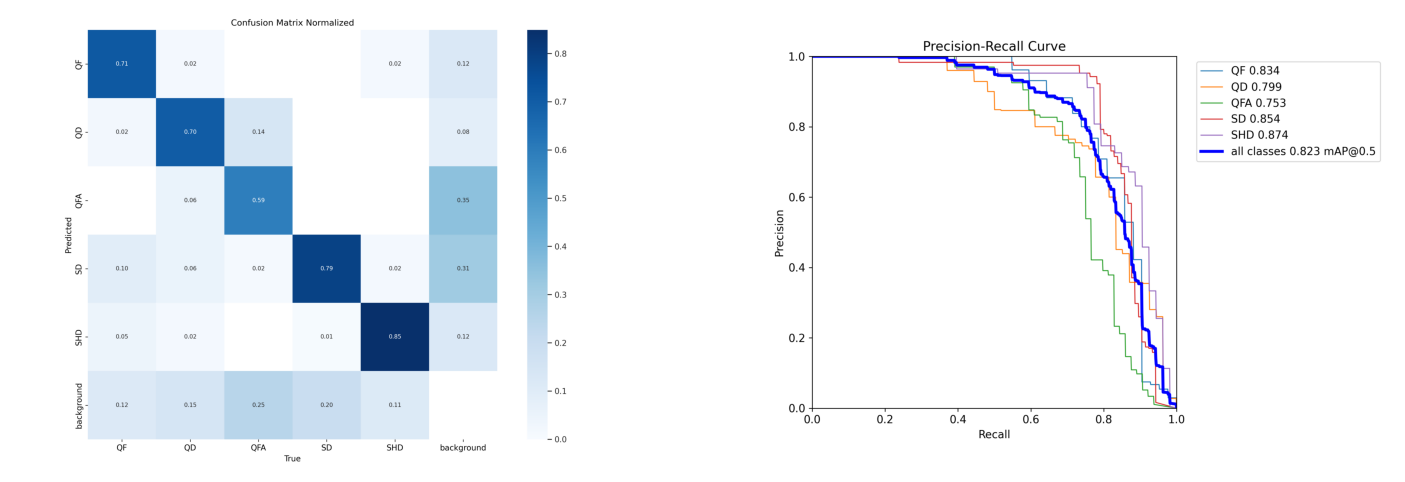

In [93]:
# Define paths to the confusion matrix and PR curve images for the last run
image_path_0 = f'alsu_magnet_classifier/{run_name}/confusion_matrix_normalized.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/PR_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)

# Create a figure to display both images side by side
plt.figure(figsize=(18, 6))

# Display the first image (confusion matrix) on the left
plt.subplot(1, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (PR curve) on the right
plt.subplot(1, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Show the images
plt.show()

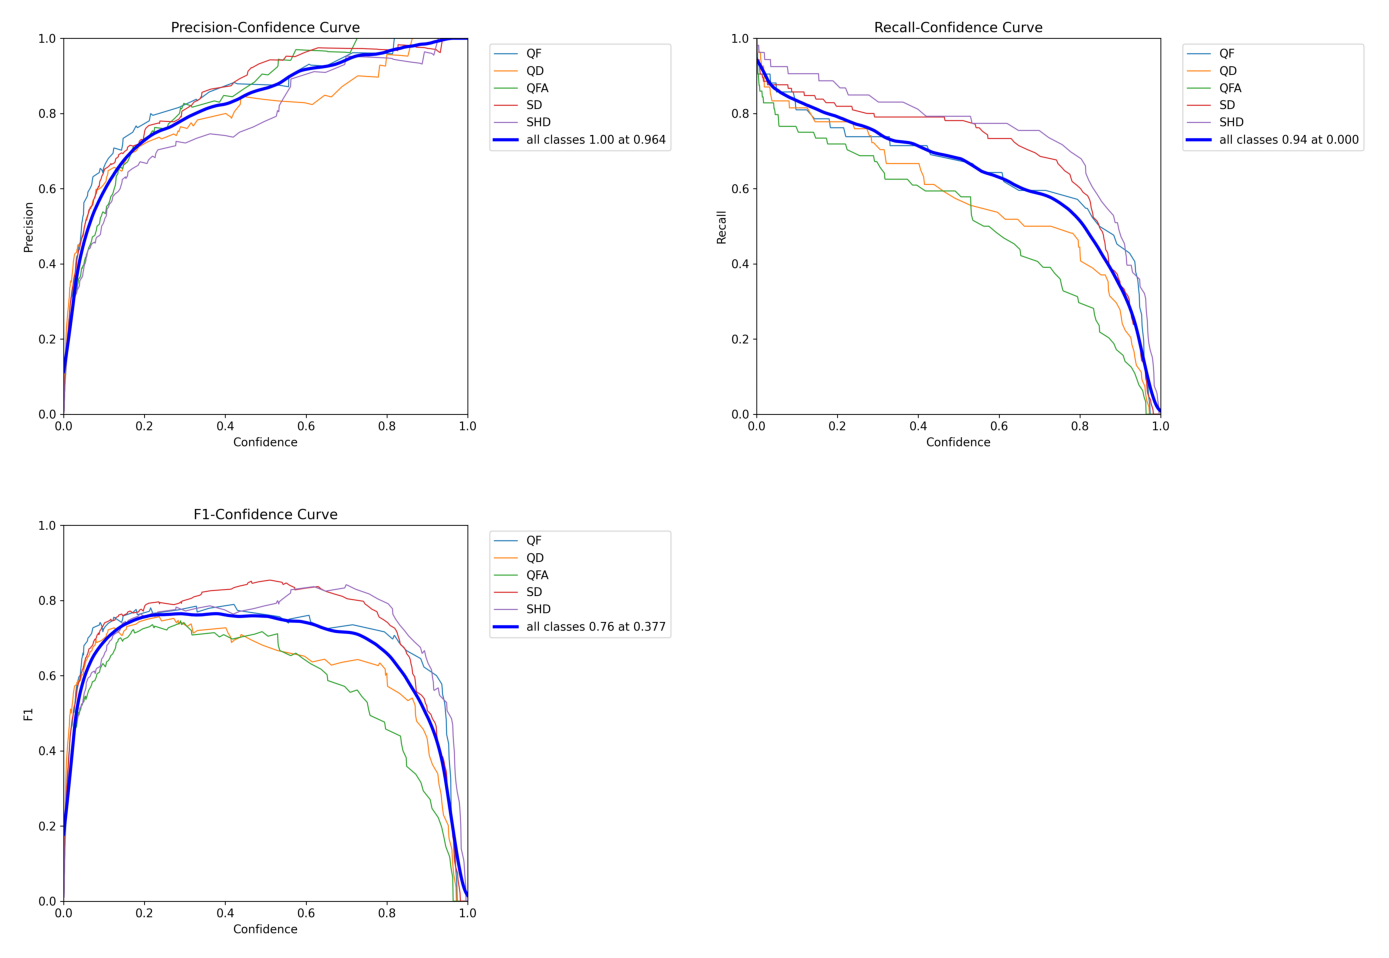

In [94]:
# Define paths to the performance graphs
image_path_0 = f'alsu_magnet_classifier/{run_name}/P_curve.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/R_curve.png'
image_path_2 = f'alsu_magnet_classifier/{run_name}/F1_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)
image2 = PilImage.open(image_path_2)

# Create a figure to display both images side by side
plt.figure(figsize=(14, 10))

# Display the first image (P curve)
plt.subplot(2, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (R curve)
plt.subplot(2, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Display the third image (F1 curve)
plt.subplot(2, 2, 3)
plt.imshow(image2)
plt.axis('off')  # Hide the axes

plt.tight_layout()

# Show the images
plt.show()

In [95]:
results_mixed_5r_150cad = model_mixed_5r_150cad.val()

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


                   all        240        318      0.813      0.725      0.823       0.63
                    QF         42         42      0.852      0.714      0.834      0.717
                    QD         53         54      0.788      0.667      0.798      0.648
                   QFA         64         64      0.825      0.625      0.754      0.475
                    SD         79        105      0.859       0.79      0.854      0.596
                   SHD         53         53      0.742       0.83      0.874      0.715
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to alsu_magnet_classifier/mixed_5r_150cad_shabby-champagne-cow2


In [96]:
mixed_5r_150cad_precision = results_mixed_5r_150cad.box.mp
mixed_5r_150cad_recall = results_mixed_5r_150cad.box.mr
mixed_5r_150cad_mAP50 = results_mixed_5r_150cad.box.map50
mixed_5r_150cad_f1 = 2 * (mixed_5r_150cad_precision * mixed_5r_150cad_recall) / (mixed_5r_150cad_precision + mixed_5r_150cad_recall)

In [172]:
print("Mixed (Simple) Model Summary:")
print(f"Precision: {mixed_5r_150cad_precision:.3f}")
print(f"Recall: {mixed_5r_150cad_recall:.3f}")
print(f"mAP50: {mixed_5r_150cad_mAP50:.3f}")
print(f"F1: {mixed_5r_150cad_f1:.3f}")

Mixed (Simple) Model Summary:
Precision: 0.813
Recall: 0.725
mAP50: 0.823
F1: 0.767


The reinforced model showed a drastic improvement over the limited 5-image dataset. Although the model still has room for improvement, there is a clear trend that a training dataset composed of CAD images, reinforced with a limited number of real pictures, can yield promising metrics.

### 6. Optimization of the Mixed Model

Paragraph 5 provided evidence that the mixed approach could lead to good results. Now, a deeper investigation is conducted to "optimize" the model. Grid search cross-validation (CV) is generally not feasible with YOLO models due to their different output structure compared to classification or regression models typically used with grid search CV. Besides the computational complexity, dataset splitting can also lead to issues like overfitting, especially when the number of images is limited. Additionally, the training and validation datasets cannot be mixed in this case: I don’t want CAD images in validation, nor do I want to "contaminate" the two real datasets.

YOLO offers some "tuning" tools, but I haven't had much time to fully explore them. Therefore, I decided to follow a simpler approach. The main parameters I am interested in are (i) the number of CAD images and (ii) the number of real images needed to achieve good performance. How to quantify performance? Two nested loops iterate through a series of potential values, collecting metrics, particularly mAP50. As mentioned earlier, mAP50 is a standard metric in object detection that evaluates a model's ability to accurately detect objects while balancing precision and recall. It measures the mean Average Precision (mAP) when the Intersection over Union (IoU) threshold is set at 0.5, providing a clear and consistent benchmark. Using mAP50 as the reference metric allows for direct comparison with other models and ensures that the YOLO model delivers reliable detection quality.

In [98]:
# Define the parameter grid
n_train_values = [150, 250, 500, 1000]
n_real_train_values = [5, 10, 20]
n_real_val = 40  # Num Real Images in Val (per class)

In [99]:
# Store results
results_dict = {}

In [100]:
# Adding CAD images from "images" folder
image_files = [f for f in os.listdir(images_path) if f.endswith('.png')]
labels = load_labels(labels_path)

In [101]:
# Adding real-world images

#Train Dataset
all_train_QD_files = [f for f in os.listdir(train_QD_path) if f.endswith('.jpg')]
all_train_QF_files = [f for f in os.listdir(train_QF_path) if f.endswith('.jpg')]
all_train_QFA_files = [f for f in os.listdir(train_QFA_path) if f.endswith('.jpg')]
all_train_SD_files = [f for f in os.listdir(train_SD_path) if f.endswith('.jpg')]
all_train_SHD_files = [f for f in os.listdir(train_SHD_path) if f.endswith('.jpg')]
all_train_background_files = [f for f in os.listdir(train_background_path) if f.endswith('.jpg')]

#Val Dataset
all_val_QD_files = [f for f in os.listdir(val_QD_path) if f.endswith('.jpg')]
all_val_QF_files = [f for f in os.listdir(val_QF_path) if f.endswith('.jpg')]
all_val_QFA_files = [f for f in os.listdir(val_QFA_path) if f.endswith('.jpg')]
all_val_SD_files = [f for f in os.listdir(val_SD_path) if f.endswith('.jpg')]
all_val_SHD_files = [f for f in os.listdir(val_SHD_path) if f.endswith('.jpg')]
all_val_background_files = [f for f in os.listdir(val_background_path) if f.endswith('.jpg')]

pics_labels = load_labels(pics_labels_path)

In [102]:
val_QD_files = pick_random_files(all_val_QD_files, n_real_val)
val_QF_files = pick_random_files(all_val_QF_files, n_real_val)
val_QFA_files = pick_random_files(all_val_QFA_files, n_real_val)
val_SD_files = pick_random_files(all_val_SD_files, n_real_val)
val_SHD_files = pick_random_files(all_val_SHD_files, n_real_val)
val_background_files = pick_random_files(all_val_background_files, n_real_val)

In [103]:
# Delete all files in training and validation folders
for path in [train_path, val_path]:
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))

In [104]:
# Validation Dataset is loaded before the loops, as it never changes (to save time)

copy_files(val_QD_files, val_QD_path, val_path, pics_labels_path)
copy_files(val_QF_files, val_QF_path, val_path, pics_labels_path)
copy_files(val_QFA_files, val_QFA_path, val_path, pics_labels_path)
copy_files(val_SD_files, val_SD_path, val_path, pics_labels_path)
copy_files(val_SHD_files, val_SHD_path, val_path, pics_labels_path)
copy_files(val_background_files, val_background_path, val_path, pics_labels_path)

100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


In [51]:
for n_train in n_train_values:
    for n_real_train in n_real_train_values:
        
        # Delete all files in training folder
        for path in [train_path]:
            for f in os.listdir(path):
                os.remove(os.path.join(path, f))

        # Preparing balanced random images for train
        train_files = balance_classes(image_files, labels, n_train)

        # Copy files to their respective directories 
        copy_files(train_files, images_path, train_path, labels_path)

        ################################################################################################

        # Random Pick across the classes

        # Preparing random images for train/val
        train_QD_files = pick_random_files(all_train_QD_files, n_real_train)
        train_QF_files = pick_random_files(all_train_QF_files, n_real_train)
        train_QFA_files = pick_random_files(all_train_QFA_files, n_real_train)
        train_SD_files = pick_random_files(all_train_SD_files, n_real_train)
        train_SHD_files = pick_random_files(all_train_SHD_files, n_real_train)
        train_background_files = pick_random_files(all_train_background_files, n_real_train)

        # Copy files to their respective directories 
        copy_files(train_QD_files, train_QD_path, train_path, pics_labels_path)
        copy_files(train_QF_files, train_QF_path, train_path, pics_labels_path)
        copy_files(train_QFA_files, train_QFA_path, train_path, pics_labels_path)
        copy_files(train_SD_files, train_SD_path, train_path, pics_labels_path)
        copy_files(train_SHD_files, train_SHD_path, train_path, pics_labels_path)
        copy_files(train_background_files, train_background_path, train_path, pics_labels_path)

        ###################################################################################

        # Train the YOLO model
        model_gs = YOLO('/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt', task='detect', verbose=True)
        run_name = f'GS_{n_real_train}r_{n_train}cad_{namegenerator.gen()}'

        print(80 * '=')
        print(80 * '=')
        print(f"Training model {run_name} with n_train={n_train} and n_real_train={n_real_train}")
        print(80 * '=')

        model_gs.train(
            data=params.yolo_yaml_path, 
            lr0=0.01,
            epochs=100,  
            val=True,
            imgsz=1024,
            batch=64,
            device=[0, 1, 2, 3],
            name=run_name,
            project='alsu_magnet_classifier',
            save_dir=f'/global/homes/a/amorato/alsu_magnet_classifier/training_output/{run_name}',
        )

        metrics_gs = model_gs.val()  # no arguments needed, dataset and settings remembered

        precision_gs = metrics_gs.box.mp
        recall_gs = metrics_gs.box.mr
        mAP50_gs = metrics_gs.box.map50
        f1_gs = 2 * (precision_gs * recall_gs) / (precision_gs + recall_gs)
            
        # Store results
        results_dict[(n_train, n_real_train)] = [precision_gs, recall_gs, mAP50_gs, f1_gs]

100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

Training model GS_5r_150cad_lovely-tomato-rattlesnake with n_train=150 and n_real_train=5
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)


engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_5r_150cad_lovely-tomato-rattlesnake2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_180810-7b8zaq1j
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_5r_150cad_lovely-tomato-rattlesnake2
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/7b8zaq1j


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

Plotting labels to alsu_magnet_classifier/GS_5r_150cad_lovely-tomato-rattlesnake2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_5r_150cad_lovely-tomato-rattlesnake2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.09G      1.983      4.862      2.249         74       1024: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]


                   all        240        350    0.00469      0.689    0.00742    0.00288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       5.1G      2.286      5.851      2.728         62       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.01it/s]


                   all        240        350    0.00521      0.701    0.00824    0.00308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       5.1G      2.289      5.413      2.747         52       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.29it/s]


                   all        240        350    0.00539      0.688    0.00867    0.00317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.13G      2.081      5.436      2.554         35       1024: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.84it/s]


                   all        240        350    0.00522      0.681    0.00782    0.00324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.13G     0.8463      4.262      1.563         40       1024: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.30it/s]


                   all        240        350    0.00426      0.619    0.00612     0.0025

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.13G     0.7288      3.906       1.41         43       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.02it/s]


                   all        240        350    0.00375      0.653     0.0114     0.0052

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.21G     0.7674       3.71      1.411         40       1024: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.06it/s]


                   all        240        350    0.00414      0.742      0.043      0.022

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.17G      0.814      3.613      1.574         27       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.90it/s]


                   all        240        350    0.00395      0.794     0.0621     0.0326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.22G     0.8022      3.327      1.439         41       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.78it/s]


                   all        240        350    0.00381      0.815      0.096     0.0532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.18G       0.86      3.307      1.443         46       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.68it/s]


                   all        240        350    0.00375       0.83      0.126     0.0688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.23G     0.8268      3.044      1.425         53       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.98it/s]


                   all        240        350    0.00393       0.83     0.0893     0.0494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.24G     0.7847      2.895      1.411         37       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.91it/s]


                   all        240        350    0.00443      0.832      0.094     0.0556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.17G     0.7224      2.858      1.282         36       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.20it/s]


                   all        240        350    0.00425      0.798     0.0727     0.0391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.13G     0.6412      2.788      1.298         29       1024: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.96it/s]


                   all        240        350    0.00459      0.807      0.105      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.21G     0.6755      2.785      1.362         30       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.20it/s]


                   all        240        350    0.00479      0.817     0.0864     0.0443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.22G      0.618       2.46      1.231         32       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.86it/s]


                   all        240        350      0.288      0.238      0.188      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.17G     0.7687      2.474      1.379         32       1024: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.16it/s]


                   all        240        350       0.72     0.0729      0.203      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.18G     0.6884      2.262       1.21         46       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.87it/s]


                   all        240        350      0.563      0.138      0.205      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.13G     0.6449      2.277      1.247         32       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.12it/s]


                   all        240        350      0.245      0.143      0.145     0.0665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.17G     0.6619      2.293      1.221         40       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.03it/s]


                   all        240        350       0.48      0.125      0.175      0.095

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.21G     0.6422      2.261      1.289         30       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]


                   all        240        350      0.439     0.0389      0.122     0.0615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.13G     0.5743       1.98       1.15         46       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.81it/s]


                   all        240        350      0.471     0.0302      0.163     0.0853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.17G     0.5437      1.888      1.145         46       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.02it/s]


                   all        240        350        0.4      0.227      0.286      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.16G     0.6156      2.045      1.255         36       1024: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.95it/s]


                   all        240        350      0.485      0.365      0.417      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.16G     0.6011      1.908      1.283         32       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.02it/s]


                   all        240        350       0.36       0.28      0.291       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.22G     0.5988      1.812      1.199         37       1024: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.88it/s]


                   all        240        350      0.185      0.145      0.111     0.0593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.17G     0.5336      1.716      1.145         37       1024: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.59it/s]


                   all        240        350      0.157     0.0455     0.0585      0.029

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.17G     0.6146      1.852      1.251         33       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.80it/s]


                   all        240        350      0.157      0.106     0.0752     0.0376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.17G     0.6503      1.901       1.33         25       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.45it/s]


                   all        240        350      0.148      0.168      0.103     0.0472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.13G     0.6461      1.787      1.293         32       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.86it/s]


                   all        240        350      0.214      0.201      0.154     0.0806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.13G     0.6365      1.797       1.26         33       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.18it/s]


                   all        240        350      0.407       0.38      0.368       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.18G     0.5739      1.858       1.19         33       1024: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.09it/s]


                   all        240        350      0.386      0.302      0.309      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.18G     0.5182      1.397      1.123         40       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.25it/s]


                   all        240        350      0.432      0.353       0.38      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.18G     0.4883      1.347      1.078         36       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.96it/s]


                   all        240        350      0.377      0.354      0.302      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.18G     0.6245      1.629      1.232         35       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.21it/s]


                   all        240        350      0.461      0.444      0.435       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.13G     0.5862      1.526      1.181         45       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.06it/s]


                   all        240        350      0.405      0.361      0.361      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.21G      0.653      1.425      1.161         38       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.88it/s]


                   all        240        350      0.379      0.391      0.347      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.17G     0.5908      1.475       1.18         28       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.00it/s]


                   all        240        350      0.396      0.356      0.288      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.13G     0.6049      1.573       1.22         36       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.34it/s]


                   all        240        350      0.443      0.244      0.301      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.17G     0.5503       1.53      1.192         39       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.95it/s]


                   all        240        350      0.401      0.391      0.401      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.17G     0.5997        1.4      1.215         34       1024: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.02it/s]


                   all        240        350      0.475      0.452       0.45      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.18G     0.5296      1.237      1.112         49       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.42it/s]


                   all        240        350      0.489      0.425      0.401      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.24G     0.5831      1.353       1.15         35       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.27it/s]


                   all        240        350        0.4      0.406      0.365      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.17G      0.521      1.206      1.132         52       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        350       0.45      0.362      0.355      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.18G     0.5779      1.314      1.153         36       1024: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


                   all        240        350      0.455      0.405      0.363      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.13G      0.553      1.267      1.124         48       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


                   all        240        350      0.467      0.502      0.445      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.18G     0.5625      1.265      1.226         25       1024: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.56it/s]


                   all        240        350      0.458      0.494      0.422       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.17G     0.5188      1.251      1.162         34       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.53it/s]


                   all        240        350        0.5      0.523      0.516      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.18G     0.4692      1.177      1.126         32       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.44it/s]


                   all        240        350      0.494      0.432       0.42      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.13G     0.5214      1.182       1.13         42       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        350      0.346      0.423      0.347      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.17G     0.5234      1.173      1.135         29       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


                   all        240        350      0.377      0.438      0.413      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.18G     0.5316      1.096      1.124         49       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        350       0.63      0.545      0.558      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.17G     0.4571      1.026      1.074         40       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]


                   all        240        350       0.66      0.504      0.579       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.13G     0.5067      1.007      1.131         41       1024: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


                   all        240        350       0.71      0.493      0.618       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.13G     0.4915      1.131       1.15         30       1024: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.98it/s]


                   all        240        350      0.734      0.549      0.639      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.21G     0.5373      1.093       1.19         33       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.03it/s]


                   all        240        350      0.556      0.545      0.549       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.22G     0.4557     0.9924      1.082         34       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


                   all        240        350      0.562      0.492      0.538      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.21G     0.4454     0.9941      1.079         35       1024: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.76it/s]


                   all        240        350      0.533      0.541       0.55      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.13G     0.4114      1.021      1.076         30       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


                   all        240        350      0.646       0.61      0.637      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.17G     0.4884      1.018      1.096         38       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


                   all        240        350      0.645      0.623      0.641      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.17G      0.518      1.142      1.231         27       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]


                   all        240        350      0.625       0.64      0.636      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.21G     0.3935      1.002      1.041         26       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


                   all        240        350      0.612      0.554      0.577      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.13G     0.4522      0.967      1.062         30       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


                   all        240        350      0.581        0.6      0.611      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.21G     0.4762     0.9673      1.064         41       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.95it/s]


                   all        240        350      0.594      0.668      0.658       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.13G     0.4424      0.969      1.085         37       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


                   all        240        350        0.6      0.622      0.606      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.13G      0.385     0.9354       1.06         36       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


                   all        240        350      0.578      0.609      0.589      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.13G      0.477     0.9236      1.111         45       1024: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.80it/s]


                   all        240        350      0.663      0.629      0.673      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.13G     0.3852     0.8321      1.031         37       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.92it/s]


                   all        240        350      0.625      0.643      0.649      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.17G     0.3768     0.8309      1.034         39       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        350      0.639      0.605      0.646      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.17G     0.4043      0.962      1.076         35       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.97it/s]


                   all        240        350      0.683      0.593      0.674      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.17G     0.3738     0.8746       1.02         33       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]


                   all        240        350      0.672      0.602      0.674      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.13G     0.4421      0.837      1.085         32       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]


                   all        240        350      0.628      0.638      0.678      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.17G     0.4438      0.823      1.086         32       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


                   all        240        350      0.638      0.635      0.697      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.13G     0.3991      0.861      1.055         39       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.04it/s]


                   all        240        350      0.605       0.69      0.701      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.13G     0.4418      0.917      1.121         29       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]


                   all        240        350      0.735      0.597      0.687      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.13G      0.358     0.7194       1.04         39       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.726      0.616      0.681      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.22G     0.3706     0.7635      1.032         38       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350      0.645      0.686      0.682      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.13G     0.3827     0.8192      1.048         29       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350       0.65      0.685      0.704      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.13G     0.4146     0.8945      1.138         26       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


                   all        240        350      0.688      0.698      0.742      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.17G     0.3744     0.8187      1.068         38       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


                   all        240        350      0.708      0.676      0.758      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.17G     0.3976     0.8482       1.06         44       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.99it/s]


                   all        240        350      0.713      0.644      0.742      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.17G      0.418     0.8655       1.11         30       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.77it/s]


                   all        240        350      0.636      0.695      0.747      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.18G     0.4388     0.7595       1.08         47       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]


                   all        240        350       0.73      0.617      0.718      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.17G     0.3832      0.743      1.036         30       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350      0.731      0.636      0.722      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.13G     0.3953     0.7624      1.057         44       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]


                   all        240        350      0.647      0.716      0.735      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.18G     0.3267     0.6696     0.9452         48       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.713      0.678      0.747      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.17G     0.3589     0.7252      1.039         34       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350      0.733      0.649       0.73      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.17G     0.3339     0.6481      1.006         39       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.736      0.633      0.705      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.17G     0.3456     0.6641     0.9669         43       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.42it/s]


                   all        240        350      0.752      0.642      0.698      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.13G     0.3711     0.7315      1.068         36       1024: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.46it/s]


                   all        240        350      0.737      0.632      0.704      0.506
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.13G     0.3161     0.9264     0.9967         21       1024: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.77it/s]


                   all        240        350      0.693      0.667      0.705      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.13G     0.3052      1.021     0.9933         21       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]


                   all        240        350      0.727      0.628      0.712      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.13G     0.2685     0.9499     0.9349         21       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350      0.709      0.671      0.737      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.13G     0.2755     0.9051     0.9481         21       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]


                   all        240        350      0.733      0.674      0.754      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.13G     0.2575     0.8794     0.9072         21       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


                   all        240        350      0.749      0.669      0.768       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.13G     0.2593     0.8417      0.915         21       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]


                   all        240        350      0.773      0.644      0.759      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.13G     0.2537     0.8476     0.8783         21       1024: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        350      0.774      0.643      0.749      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.13G     0.2455     0.9609     0.9212         17       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350      0.766      0.643      0.749      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.13G     0.2246     0.9398     0.8837         14       1024: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.764      0.642      0.747      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.13G     0.2619     0.9415     0.9343         13       1024: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.45it/s]


                   all        240        350      0.765      0.647      0.749      0.564

100 epochs completed in 0.095 hours.
Optimizer stripped from alsu_magnet_classifier/GS_5r_150cad_lovely-tomato-rattlesnake2/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_5r_150cad_lovely-tomato-rattlesnake2/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_5r_150cad_lovely-tomato-rattlesnake2/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]


                   all        240        350      0.751      0.668      0.767       0.57
                    QF         42         42      0.658       0.69      0.759       0.59
                    QD         58         58          1      0.376      0.735       0.55
                   QFA         64         64      0.716       0.59      0.642      0.381
                    SD         90        124       0.76      0.798      0.837      0.599
                   SHD         62         62      0.623      0.887      0.862      0.729
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to alsu_magnet_classifier/GS_5r_150cad_lovely-tomato-rattlesnake2


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▃▃▄▄▅▆▆▆▇▇███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg1 ▁▂▃▃▄▄▅▆▆▆▇▇███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg2 ▁▂▃▃▄▄▅▆▆▆▇▇███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▁▁▂▂▂▃▃▂▄▂▂▄▄▄▄▅▄▅▅▅▇▆▇▇▇▇▇▇▇▇████▇▇███
wandb:     metrics/mAP50-95(B) ▁▁▁▁▂▁▂▂▂▃▂▁▄▃▃▃▄▄▄▄▄▆▅▆▆▆▇▆▇▇▇▇██▇▇▇███
wandb:    metrics/precision(B) ▁▁▁▁▁▁▄▆▅▅▃▂▅▄▅▅▅▅▅▅▄▇▆▇▇▆▇▇▇▆▇▇▇███████
wandb:       metrics/recall(B) ▇▇▆███▃▂▁��▂▂▄▄▄▃▅▄▅▄▅▅▅▆▆▇▆▆▆▇▇▇▇▆▆▆▆▇▆▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁
wandb:          train/cls_loss ▇█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
wandb:          train/dfl_loss ▆█▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
wandb:            val/box_loss ▆▆▅▄▄▄▂▃▅▃▄█▄▄▆▅▅▅▄▃▃▃▄▂▂▂▂▂▁▁▁▂▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


                   all        240        350      0.749      0.669      0.768      0.571
                    QF         42         42      0.656       0.69      0.762      0.593
                    QD         58         58          1      0.378      0.735      0.555
                   QFA         64         64      0.716      0.592      0.642      0.377
                    SD         90        124      0.756      0.798      0.836      0.598
                   SHD         62         62      0.619      0.887      0.863       0.73
Speed: 0.7ms preprocess, 1.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to alsu_magnet_classifier/GS_5r_150cad_lovely-tomato-rattlesnake22


100%|██████████| 10/10 [00:01<00:00,  8.27it/s]

Training model GS_10r_150cad_sleepy-cobalt-axolotl with n_train=150 and n_real_train=10
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)


engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_10r_150cad_sleepy-cobalt-axolotl2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_181714-6p7h6iw7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_10r_150cad_sleepy-cobalt-axolotl2
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/6p7h6iw7


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_10r_150cad_sleepy-cobalt-axolotl2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_10r_150cad_sleepy-cobalt-axolotl2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.19G      1.905      4.937      2.305         13       1024: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.55it/s]


                   all        240        350    0.00469       0.67    0.00757    0.00285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.14G      2.088      5.674      2.534          8       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.29it/s]


                   all        240        350    0.00528      0.692    0.00808     0.0031

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.17G      2.247      5.672      2.818          9       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.22it/s]


                   all        240        350    0.00561      0.699    0.00839    0.00334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.17G     0.8608      4.172      1.618         12       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.06it/s]


                   all        240        350    0.00518      0.717     0.0122    0.00484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.17G     0.7196      3.759      1.347         14       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.00it/s]


                   all        240        350    0.00671      0.793     0.0414      0.018

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.22G     0.7223      3.593      1.322         18       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.03it/s]


                   all        240        350    0.00704      0.827     0.0538     0.0238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.18G     0.8048      3.635      1.404          8       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.03it/s]


                   all        240        350    0.00693      0.886      0.109     0.0478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.18G     0.8599      3.421      1.496          8       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]


                   all        240        350    0.00682      0.879     0.0885     0.0411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.17G     0.7961       3.03      1.333         15       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.90it/s]


                   all        240        350    0.00716      0.895      0.141     0.0734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.18G     0.7611      3.039       1.39         12       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.98it/s]


                   all        240        350     0.0066      0.866      0.108     0.0493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.18G     0.8332      2.895      1.382         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.90it/s]


                   all        240        350    0.00581      0.864      0.141     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.18G     0.7287      2.575      1.298         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.05it/s]


                   all        240        350    0.00494      0.833     0.0468     0.0163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.18G     0.8013      2.599      1.322         20       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.92it/s]


                   all        240        350    0.00578      0.881     0.0875      0.047

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.21G     0.7689      2.934      1.435          8       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


                   all        240        350    0.00556       0.79     0.0282    0.00942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.13G     0.6671      2.533      1.199         15       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.12it/s]


                   all        240        350     0.0461      0.378     0.0609     0.0221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.17G     0.6758      2.621      1.295          8       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.02it/s]


                   all        240        350      0.659      0.104      0.162     0.0898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.22G     0.6163      2.298      1.176         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.24it/s]


                   all        240        350      0.654     0.0387     0.0914     0.0445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.21G     0.7022      2.229      1.281         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.14it/s]


                   all        240        350      0.252     0.0558      0.095     0.0454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.18G     0.7085      2.213      1.234         20       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.00it/s]


                   all        240        350      0.196     0.0864      0.193      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.17G     0.7274      2.288      1.316         14       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.86it/s]


                   all        240        350      0.319       0.16       0.17     0.0867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.17G     0.6886      2.017      1.242         17       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.15it/s]


                   all        240        350       0.21      0.125      0.196      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.21G     0.5763      2.028      1.185         10       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.16it/s]


                   all        240        350      0.547      0.139      0.298      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.18G     0.7456      2.088       1.32         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.01it/s]


                   all        240        350      0.392      0.312      0.389      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.18G     0.7124      1.674      1.194         18       1024: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.00it/s]


                   all        240        350       0.41      0.178      0.232      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.23G     0.7381      1.776      1.238         17       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.19it/s]


                   all        240        350      0.294      0.196      0.189     0.0637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.18G     0.6917      1.943        1.3          7       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.29it/s]


                   all        240        350      0.575      0.174      0.291       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.17G     0.7115      1.849      1.292         12       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.53it/s]


                   all        240        350     0.0464     0.0333     0.0117    0.00513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.17G     0.6276      1.758      1.223         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.43it/s]


                   all        240        350    0.00307      0.334    0.00496    0.00218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.13G      0.704      1.734      1.195         24       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]


                   all        240        350      0.201      0.174      0.153     0.0893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.18G     0.6372      1.595      1.222         12       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.43it/s]


                   all        240        350      0.261      0.153      0.159     0.0667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.13G     0.6061       1.66      1.279         10       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.34it/s]


                   all        240        350      0.271      0.231      0.169      0.082

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.17G     0.6196      1.539       1.18         15       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.54it/s]


                   all        240        350      0.516      0.231      0.204     0.0897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.17G     0.6946       1.67       1.26         11       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.47it/s]


                   all        240        350      0.289      0.284      0.232      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.13G      0.582      1.405      1.177         21       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.45it/s]


                   all        240        350      0.547      0.423      0.457      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.23G     0.6264      1.499      1.186         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


                   all        240        350        0.5      0.489      0.464      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.18G     0.6122      1.559      1.236          9       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.69it/s]


                   all        240        350       0.29      0.284      0.235      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.17G     0.5678       1.33      1.164         18       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.37it/s]


                   all        240        350      0.573      0.506      0.497      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.22G     0.5054      1.265      1.113         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.74it/s]


                   all        240        350      0.619      0.351      0.427      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.17G     0.6297      1.318      1.187         15       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


                   all        240        350      0.552      0.552      0.602      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.17G     0.6131      1.299      1.192         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.63it/s]


                   all        240        350      0.646      0.495      0.539       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.17G     0.5962      1.299      1.123         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]


                   all        240        350       0.73      0.692      0.709      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.13G     0.5659      1.326      1.186          7       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


                   all        240        350      0.607      0.589      0.616      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.18G     0.5476      1.085      1.082         18       1024: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.73it/s]


                   all        240        350      0.632      0.599      0.624      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.17G     0.5527      1.189      1.142         14       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


                   all        240        350       0.63      0.632      0.629      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.17G     0.6456        1.2      1.172         10       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.68it/s]


                   all        240        350      0.553      0.621      0.639      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.18G     0.5295      1.069      1.166         15       1024: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.69it/s]


                   all        240        350      0.559      0.589      0.575      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.17G     0.5923      1.137      1.143         19       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.95it/s]


                   all        240        350      0.543      0.538      0.517      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.22G     0.4548      1.034      1.095         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.09it/s]


                   all        240        350      0.595      0.372      0.436      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.13G     0.5328      1.099      1.108         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


                   all        240        350      0.411      0.339      0.328      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.13G     0.5015      1.015       1.09         10       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.06it/s]


                   all        240        350      0.642      0.583      0.648      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.22G     0.5485      1.044      1.091         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.88it/s]


                   all        240        350      0.667      0.553      0.588      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.17G     0.5104     0.8871      1.038         19       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.03it/s]


                   all        240        350      0.621      0.521      0.589      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.17G     0.5426     0.9905      1.093         30       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.98it/s]


                   all        240        350      0.676      0.571      0.635      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.17G     0.5462      1.099      1.198          7       1024: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        350      0.694      0.608      0.671      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.17G     0.4934      1.016       1.13         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


                   all        240        350      0.723      0.597      0.635      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.17G     0.5405     0.8601      1.088         22       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


                   all        240        350      0.718      0.584      0.669      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.17G     0.5622     0.9121      1.147         12       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        350      0.779      0.677      0.731      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.22G     0.5631     0.8532      1.104         21       1024: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


                   all        240        350      0.729      0.718      0.732       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.16G     0.4513     0.8482      1.122         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.33it/s]


                   all        240        350       0.72      0.675      0.728      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.22G     0.4359     0.8251       1.02          9       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        350      0.622      0.603      0.608      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.18G     0.4449     0.8011      1.066          8       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


                   all        240        350      0.779      0.602      0.703      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.17G     0.4959     0.8716      1.121          8       1024: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350      0.795       0.65      0.723      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.17G     0.4849     0.7688      1.067         14       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.46it/s]


                   all        240        350      0.796      0.646      0.747      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.21G     0.5206     0.9395      1.105         10       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.804      0.647      0.755      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.17G     0.4167     0.7511      1.004         19       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


                   all        240        350       0.78      0.693      0.776      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.21G     0.4528     0.8394      1.057         11       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.731      0.614      0.709      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.17G     0.4861     0.8135      1.027         24       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.656      0.594      0.652       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.23G     0.4308     0.8351      1.048         12       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        350      0.734      0.666      0.719      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.17G     0.4251     0.7105      1.039         10       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350      0.747      0.708      0.747      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.17G     0.5435     0.8482      1.108         15       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.755      0.681      0.746      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.13G     0.4607     0.8145      1.088         15       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.29it/s]


                   all        240        350      0.721      0.707      0.747      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.17G      0.418     0.8039      1.041         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.701      0.662      0.695      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.21G     0.3634     0.6472     0.9582         21       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.726      0.675      0.722      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.17G     0.4705     0.7756      1.045         15       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


                   all        240        350      0.841      0.698      0.782      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.17G     0.4337     0.6805     0.9943         25       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350      0.832      0.755      0.819      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.17G     0.4164     0.6564      1.029         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        350      0.817      0.763      0.828      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.16G     0.3774      0.669     0.9815         20       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.794      0.734      0.806      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.13G     0.3763     0.7685      1.074          8       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


                   all        240        350      0.833      0.736      0.815      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.21G     0.3912     0.6567      1.005         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        350      0.821      0.775      0.835      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.16G     0.4088     0.6411     0.9973         18       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350       0.82      0.765      0.832      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.13G     0.4178     0.6211      1.017         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.815      0.776      0.823      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.17G     0.4179     0.6987      1.063         14       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.63it/s]


                   all        240        350      0.812      0.738      0.816      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.17G     0.3769     0.5949     0.9808         11       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.815      0.763      0.843      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.17G     0.4181     0.7156      1.044         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.852      0.763      0.852      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.17G      0.394     0.5889     0.9851         13       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.839      0.728      0.835      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.17G     0.4113     0.6432      1.054         11       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


                   all        240        350      0.821       0.75      0.836       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.17G     0.3718     0.6285     0.9839         20       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350      0.876      0.756      0.845      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.17G      0.397     0.6206       1.01         14       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.865      0.765      0.853      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.16G     0.4198     0.6346      1.032         16       1024: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


                   all        240        350      0.859      0.775       0.86      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.17G      0.311     0.5711     0.9295         17       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.849      0.777      0.855      0.653
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.13G     0.3163     0.8227     0.9176          4       1024: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        350      0.847      0.772      0.842      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.13G     0.3075     0.8466     0.9787          4       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.813      0.762       0.83      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.13G     0.3285     0.8081     0.9658          4       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.854      0.745      0.837      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.13G     0.2933      0.759     0.9597          4       1024: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.42it/s]


                   all        240        350      0.847       0.75      0.833      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.13G     0.3029     0.7908     0.9926          4       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]


                   all        240        350      0.851      0.776      0.836      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.13G      0.274     0.6991     0.9014          7       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        350      0.843      0.779      0.839      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.13G     0.3121     0.7044     0.9359          9       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.53it/s]


                   all        240        350      0.844      0.767      0.838      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.13G     0.2697     0.6504     0.9275          7       1024: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]


                   all        240        350      0.842      0.746      0.837      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.13G     0.3112     0.6136     0.9054         12       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        350       0.83      0.765      0.836      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.13G     0.3091      0.695     0.9538          5       1024: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        350      0.835      0.749      0.834       0.66

100 epochs completed in 0.109 hours.
Optimizer stripped from alsu_magnet_classifier/GS_10r_150cad_sleepy-cobalt-axolotl2/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_10r_150cad_sleepy-cobalt-axolotl2/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_10r_150cad_sleepy-cobalt-axolotl2/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.81it/s]


                   all        240        350      0.848      0.768      0.838      0.661
                    QF         42         42      0.903      0.663      0.859      0.763
                    QD         58         58      0.891      0.706      0.786      0.601
                   QFA         64         64      0.705      0.719      0.693      0.486
                    SD         90        124      0.823      0.855       0.89      0.663
                   SHD         62         62      0.918      0.898      0.963      0.791
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to alsu_magnet_classifier/GS_10r_150cad_sleepy-cobalt-axolotl2


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg1 ▁▂▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg2 ▁▂▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▁▁▂▂▂▂▂▃▄▃▁▂▅▃▆▇▆▆▄▆▆▆▇▇▇▆▇▇▇██████████
wandb:     metrics/mAP50-95(B) ▁▁▁▁▂▁▂▁▂▄▃▁▂▄▂▅▆▆▅▃▅▆▆▇▆▇▆▇▆▇▇█████████
wandb:    metrics/precision(B) ▁▁▁▁▁▁▆▃▃▄▆▁▃▅▃▅▇▆▅▄▆▇▇▇▇▇▆▇▇█▇█▇███▇███
wandb:       metrics/recall(B) ▆▆████▁▁▂��▂▃▂▄▃▅▆▆▆▃▅▆▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
wandb:          train/cls_loss ▇█▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss ▆█▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            val/box_loss ▄▃▃▃▄▃▃▄▃▂▃█▄▃▅▂▂▂▂▅▃▃▂▁▂▂▂▂▂▂▁▁▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


                   all        240        350      0.844      0.767      0.837       0.66
                    QF         42         42      0.903      0.664      0.859      0.763
                    QD         58         58      0.892      0.709      0.786      0.601
                   QFA         64         64      0.705      0.719      0.687      0.484
                    SD         90        124      0.816      0.855       0.89      0.661
                   SHD         62         62      0.906      0.887      0.962       0.79
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/GS_10r_150cad_sleepy-cobalt-axolotl22


100%|██████████| 20/20 [00:01<00:00, 12.06it/s]


Training model GS_20r_150cad_sleepy-cobalt-axolotl with n_train=150 and n_real_train=20
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_20r_150cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_182704-uuonsl0z
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_20r_150cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/uuonsl0z


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_20r_150cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_20r_150cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.15G      1.635      4.758      1.909          8       1024: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.04it/s]


                   all        240        350    0.00513      0.701    0.00779    0.00297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.16G      1.522      4.482      1.835         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.14it/s]


                   all        240        350    0.00578       0.69    0.00818    0.00313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.19G      1.399      4.684      1.878          6       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.66it/s]


                   all        240        350    0.00404      0.693    0.00836    0.00334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.18G      1.056      3.989      1.503         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.57it/s]


                   all        240        350    0.00469      0.842      0.057     0.0269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.21G     0.9915      3.608      1.413         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.63it/s]


                   all        240        350     0.0057      0.897       0.12     0.0748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.26G      1.003      3.271      1.442         17       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.80it/s]


                   all        240        350    0.00802      0.916       0.19      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.18G     0.8342      3.172      1.363         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]


                   all        240        350    0.00711       0.91      0.149     0.0917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.17G     0.8614      2.757      1.345         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


                   all        240        350    0.00607      0.915      0.188      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.21G     0.7981      2.812      1.332         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.05it/s]


                   all        240        350    0.00567      0.883      0.176     0.0869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.18G      0.856      2.359      1.283         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.74it/s]


                   all        240        350      0.222      0.446      0.279      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.18G      0.815      2.424      1.309         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.13it/s]


                   all        240        350      0.712      0.146      0.358      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.18G     0.7758      2.302      1.263         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.94it/s]


                   all        240        350      0.819       0.23      0.438      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.18G     0.7409      2.311      1.294         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.02it/s]


                   all        240        350      0.724      0.242      0.238       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.22G      0.704      2.082      1.171         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.06it/s]


                   all        240        350      0.539      0.342      0.453      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.18G     0.7767      2.025      1.243          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.08it/s]


                   all        240        350      0.675      0.329      0.468      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.22G     0.6901      2.012      1.248          8       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.19it/s]


                   all        240        350      0.575      0.302      0.364      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.21G     0.7772      1.598      1.209         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.23it/s]


                   all        240        350      0.634      0.329      0.473      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.17G     0.7802      1.788      1.194         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


                   all        240        350        0.5      0.409      0.447      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.18G     0.7569      1.795      1.227         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.19it/s]


                   all        240        350      0.308      0.149       0.17      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.18G     0.7549      1.607      1.236         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.19it/s]


                   all        240        350        0.3        0.3      0.201      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.18G     0.7636      1.961      1.252         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.24it/s]


                   all        240        350      0.302       0.24      0.206      0.098

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.22G     0.6929      1.564      1.209         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.59it/s]


                   all        240        350      0.189      0.251      0.118     0.0546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.18G     0.7136      1.558      1.147         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.95it/s]


                   all        240        350      0.223     0.0818      0.107     0.0501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.23G     0.6825      1.468      1.174          8       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.49it/s]


                   all        240        350      0.258      0.339      0.229      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.18G       0.65      1.398      1.105         10       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.25it/s]


                   all        240        350      0.595      0.472      0.546      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.23G       0.78      1.587      1.262         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.59it/s]


                   all        240        350      0.286      0.349      0.259      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.26G     0.6772      1.455      1.172          5       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.11it/s]


                   all        240        350      0.428      0.368      0.388      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.18G     0.7259       1.34      1.175         21       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.57it/s]


                   all        240        350       0.55      0.491      0.563      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.25G     0.6116      1.205      1.114          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


                   all        240        350      0.551        0.5      0.524      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.21G     0.6684      1.284       1.12         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.21it/s]


                   all        240        350      0.598      0.502      0.526      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.21G     0.6561      1.163      1.174         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]


                   all        240        350      0.651      0.594      0.639      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.18G     0.6305       1.13      1.125         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.34it/s]


                   all        240        350      0.645      0.649      0.664      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.21G      0.638      1.128      1.185         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.47it/s]


                   all        240        350      0.709      0.669      0.761      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.22G     0.6865      1.137      1.169         21       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.81it/s]


                   all        240        350      0.555      0.643      0.656      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.18G     0.5753     0.9803      1.085         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


                   all        240        350      0.718       0.63      0.739       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.18G     0.6155       1.02      1.088         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        350      0.752      0.594      0.673      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.17G     0.6473     0.9841      1.148         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        350      0.619      0.618      0.639       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.21G     0.5871     0.9137      1.071         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.29it/s]


                   all        240        350      0.694       0.66      0.725      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.22G      0.571     0.9381      1.059         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


                   all        240        350      0.731      0.571      0.657      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.22G       0.55     0.9407      1.025         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.756        0.6       0.71      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.18G     0.5988     0.8821      1.111         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350      0.803      0.692      0.736      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.22G     0.5807     0.9518      1.097         10       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350      0.782      0.695      0.747      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.18G     0.6678       1.13      1.211          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


                   all        240        350      0.752      0.696      0.766      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.18G     0.5744     0.8953       1.09          8       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


                   all        240        350      0.601      0.368      0.416      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.24G     0.5415     0.7835      1.049         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350       0.54      0.488       0.52      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.18G        0.5     0.7877      1.032         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.767      0.753       0.79      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.22G     0.5852     0.8607       1.13         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.60it/s]


                   all        240        350      0.833      0.714        0.8      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.25G     0.5035     0.8529       1.06          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.719      0.746      0.785      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.18G     0.5176     0.7383      1.036         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.711      0.776      0.805      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.18G     0.5636     0.9114      1.085         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350      0.803      0.726      0.811       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.17G     0.5264     0.7273      1.037         22       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.08it/s]


                   all        240        350      0.807      0.677      0.795      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.21G     0.5646     0.7537      1.058         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]


                   all        240        350      0.808      0.761      0.832      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.18G      0.587     0.7725      1.084         28       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


                   all        240        350      0.851      0.711      0.836      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.17G     0.5091     0.6741      1.004         21       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


                   all        240        350       0.88      0.775      0.879      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.21G     0.4954     0.6891      1.052         17       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]


                   all        240        350      0.851      0.774      0.855      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.17G     0.5232     0.7453      1.037         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 4/8 [00:00<00:00, 12.30it/s]

                   all        240        350      0.786      0.755      0.794      0.594


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.25G     0.5079     0.6032      1.001         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


                   all        240        350      0.826      0.682       0.79        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.23G     0.4732     0.6288     0.9795         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.95it/s]


                   all        240        350      0.813      0.787      0.833      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.18G     0.5413     0.7339      1.105          6       1024: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.80it/s]


                   all        240        350      0.864      0.786      0.883      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.17G     0.4639     0.7097      1.017         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


                   all        240        350      0.848      0.775       0.84      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.18G     0.5159     0.7069      1.089          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


                   all        240        350      0.778      0.709        0.8      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.22G     0.5419     0.6422      1.057         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]


                   all        240        350      0.831      0.751      0.843      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.25G     0.5303      0.688      1.045         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.801      0.786       0.84      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.17G     0.4939     0.6231      1.007         23       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350      0.799      0.784      0.838      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.21G     0.5369     0.6111      1.082         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


                   all        240        350      0.799      0.688      0.758      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.23G      0.506     0.6473      1.084          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


                   all        240        350      0.855       0.77      0.847      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.24G     0.4765     0.5882      0.962         28       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        350      0.826      0.741      0.821      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.24G     0.5245     0.6251      1.052         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        350      0.772        0.8      0.838      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.18G     0.4444     0.5931      1.041         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350      0.824      0.809      0.878       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.17G      0.454     0.6765      1.039          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.822      0.827      0.887       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.17G     0.4678     0.5851      1.007         25       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]


                   all        240        350      0.916      0.866      0.936      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.21G     0.4313     0.5611      0.985          8       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


                   all        240        350      0.849      0.883      0.938      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.23G     0.4966     0.6386      1.032         22       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]


                   all        240        350      0.876      0.803      0.903      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.38G     0.4331     0.5583      1.006         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        350      0.921      0.787      0.907      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.21G     0.4686     0.5636      1.014         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]


                   all        240        350      0.875      0.806      0.895      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.17G     0.5042     0.5314       1.04         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


                   all        240        350      0.875      0.849      0.921      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.18G     0.3925     0.5662     0.9512         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.939      0.833      0.943      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.18G     0.4273     0.5468      1.009         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.929      0.856       0.94      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.17G     0.4281     0.5356     0.9653         17       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.63it/s]


                   all        240        350      0.896      0.871      0.934      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.18G     0.4138     0.5416     0.9735         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.904      0.903      0.951      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.22G     0.4268     0.5014     0.9976         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.79it/s]


                   all        240        350      0.931      0.907      0.955      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.18G     0.4305     0.5832       1.01         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.943      0.904      0.951      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.18G     0.3968     0.4808     0.9131         22       1024: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350      0.946      0.905      0.955      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.43G     0.4308      0.513     0.9896         21       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.79it/s]


                   all        240        350      0.941      0.894      0.954      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.41G     0.4122     0.4617     0.9435         23       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.68it/s]


                   all        240        350      0.977      0.869       0.95      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.38G     0.4022     0.4683     0.9557         10       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.936      0.882      0.944      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.34G      0.412     0.5355     0.9588         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350       0.94      0.894      0.944      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.37G     0.3824     0.4558     0.9566         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.42it/s]


                   all        240        350      0.953      0.873      0.935      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.21G      0.417      0.542      1.014          8       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.42it/s]


                   all        240        350       0.94      0.869      0.929      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.38G     0.4161     0.4646     0.9564         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350      0.934      0.881      0.932        0.7
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.14G     0.3667      0.548      0.951          7       1024: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.941      0.848      0.924      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.14G     0.3433     0.5431     0.9482          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.04it/s]


                   all        240        350      0.945      0.852      0.925        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.14G     0.3364     0.5202      0.924          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        350      0.924      0.869      0.928      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.13G     0.3047     0.4869     0.8823          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        350       0.93      0.851      0.925      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.13G     0.3045     0.4654     0.8953          7       1024: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


                   all        240        350      0.923      0.857      0.925      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.17G     0.2961     0.4432     0.8556          5       1024: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


                   all        240        350      0.947      0.845       0.93      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.14G     0.3635     0.5449     0.9312          5       1024: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350      0.939      0.855      0.928      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.14G     0.3341     0.4892     0.9313          6       1024: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.944      0.837       0.93      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.14G     0.3004     0.4351     0.8514         10       1024: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


                   all        240        350      0.943      0.836      0.929       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.14G      0.264     0.4369     0.8276          9       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.931      0.847      0.933      0.751

100 epochs completed in 0.138 hours.
Optimizer stripped from alsu_magnet_classifier/GS_20r_150cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_20r_150cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_20r_150cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.45it/s]


                   all        240        350      0.943      0.904      0.951      0.761
                    QF         42         42      0.904        0.9      0.951      0.841
                    QD         58         58      0.979      0.948      0.989      0.833
                   QFA         64         64      0.885      0.841      0.886      0.572
                    SD         90        124      0.973      0.927      0.961      0.731
                   SHD         62         62      0.973      0.903       0.97      0.826
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to alsu_magnet_classifier/GS_20r_150cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▃▄▅▆▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg1 ▁▂▃▄▅▆▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg2 ▁▂▃▄▅▆▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▁▂▂▄▃▄▄▂▂▃▅▆▆▆▆▆▄▇▇▇▇▇▇▇▇▇▇████████████
wandb:     metrics/mAP50-95(B) ▁▁▂▂▃▂▃▄▂▁▃▅▅▅▅▅▆▄▆▇▆▇▆▇▆▇▆▇▇▇█████▇▇███
wandb:    metrics/precision(B) ▁▁▁▁▆▆▅▅▃▃▃▅▆▅▇▆▇▅▇▆▇█▇▇▇▇▇▇▇███████████
wandb:       metrics/recall(B) ▆▆██▂▂▃▄▂��▃▄▅▆▅▅▆▃▇▇▆▇▇▇▆▇▇▇█▇▇█████▇▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▅▄▄▃▃▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁
wandb:          train/cls_loss ██▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss ██▅▄▄▄▄▃▄▃▄▃▃▃▃▂▃▃▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁
wandb:            val/box_loss ▅▄▃▂▂▄▃▃▆█▆▃▃▂▃▃▂▄▂▂▂▁▂▂▃▂▂▂▂▂▁▂▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


                   all        240        350      0.943      0.904      0.951       0.76
                    QF         42         42      0.904      0.899       0.95      0.841
                    QD         58         58      0.979      0.948      0.989      0.828
                   QFA         64         64      0.885      0.842      0.886      0.574
                    SD         90        124      0.974      0.927      0.961      0.732
                   SHD         62         62      0.973      0.903       0.97      0.826
Speed: 0.4ms preprocess, 1.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to alsu_magnet_classifier/GS_20r_150cad_sleepy-cobalt-axolotl2


100%|██████████| 5/5 [00:00<00:00, 16.26it/s]


Training model GS_5r_250cad_sleepy-cobalt-axolotl with n_train=250 and n_real_train=5
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_5r_250cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=Fa

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_183845-7cyaoplu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_5r_250cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/7cyaoplu


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_5r_250cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_5r_250cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.23G      2.242      5.868      2.586          8       1024: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.77it/s]


                   all        240        350    0.00494      0.687     0.0079    0.00295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.23G      2.189      5.447      2.581         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.23it/s]


                   all        240        350    0.00533      0.682    0.00915    0.00336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.15G       1.71      5.148      2.322         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]


                   all        240        350    0.00406      0.445    0.00381    0.00145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.17G     0.7741      3.828       1.45         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.23it/s]


                   all        240        350    0.00486      0.522     0.0106    0.00438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.18G     0.7396      3.528      1.454         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.00it/s]


                   all        240        350    0.00596      0.712     0.0404     0.0211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.17G     0.6549      3.345      1.341         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.16it/s]


                   all        240        350    0.00476      0.721     0.0552     0.0315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.13G     0.6823      3.128      1.346         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.79it/s]


                   all        240        350    0.00512      0.771     0.0874     0.0495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.13G      0.744      2.952      1.443         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.69it/s]


                   all        240        350    0.00479      0.756     0.0718     0.0421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.17G     0.6272      2.797      1.296         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.35it/s]


                   all        240        350    0.00397      0.688     0.0318     0.0167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.18G       0.75      2.656      1.415         17       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.27it/s]


                   all        240        350    0.00492       0.81     0.0754     0.0454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.13G     0.6083      2.533      1.319         23       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.08it/s]


                   all        240        350      0.453      0.248      0.148     0.0784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.13G     0.6456      2.551      1.292         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.35it/s]


                   all        240        350    0.00249      0.365     0.0182    0.00845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.17G     0.6519      2.413      1.291         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.28it/s]


                   all        240        350      0.911     0.0286      0.108     0.0397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.18G     0.6148       2.22      1.204         17       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.18it/s]


                   all        240        350      0.175      0.021     0.0522     0.0227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.34G     0.6137      2.486      1.303         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.87it/s]


                   all        240        350      0.395      0.127      0.149     0.0822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.17G     0.5572      2.034      1.189         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.91it/s]


                   all        240        350      0.135      0.121      0.123     0.0667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.17G     0.6034      2.053       1.25         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.95it/s]


                   all        240        350      0.192      0.148      0.116     0.0538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.13G     0.6648      1.965      1.324         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.91it/s]


                   all        240        350       0.32      0.132      0.102     0.0499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.13G     0.6096       2.07       1.23         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.84it/s]


                   all        240        350       0.29      0.206      0.167     0.0829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.14G     0.5828      1.954       1.25         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


                   all        240        350      0.352      0.151      0.167     0.0795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.13G     0.5687      1.725      1.196         21       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.07it/s]


                   all        240        350      0.372      0.337      0.347       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.17G     0.6104      1.689      1.163         21       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]


                   all        240        350      0.347      0.349      0.286      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.13G     0.6261      1.661      1.252         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.87it/s]


                   all        240        350      0.446      0.388      0.378      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.17G     0.5113      1.549      1.133         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.24it/s]


                   all        240        350        0.4      0.248      0.281      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.17G     0.6017      1.632      1.213         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.34it/s]


                   all        240        350      0.347      0.228      0.234      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.17G     0.6536       1.59       1.33         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.36it/s]


                   all        240        350      0.192        0.2      0.127     0.0556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.13G     0.5447      1.302      1.153         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.50it/s]


                   all        240        350      0.498      0.345      0.404      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.13G     0.5462      1.307      1.169         22       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.68it/s]


                   all        240        350      0.369      0.281      0.273      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.17G     0.5882      1.395      1.195         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.95it/s]


                   all        240        350      0.282      0.198      0.194      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.17G     0.6287      1.331       1.21         17       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        350      0.293      0.228      0.227       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.17G     0.5684      1.262      1.198         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.08it/s]


                   all        240        350      0.559      0.403      0.435      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.17G     0.5287      1.304      1.199         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.265      0.183      0.191     0.0975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.13G     0.5309      1.188      1.162         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.37it/s]


                   all        240        350      0.208      0.156      0.132     0.0681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.13G     0.5381      1.119      1.234         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.62it/s]


                   all        240        350        0.5      0.436      0.447      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.17G     0.5237      1.096       1.18         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


                   all        240        350      0.592      0.406      0.436      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.17G     0.4862     0.9582      1.123         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]


                   all        240        350      0.483      0.284      0.232      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.21G     0.4719      1.087      1.128          9       1024: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.72it/s]


                   all        240        350      0.436      0.401      0.345      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.18G     0.4941      1.033      1.112         10       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.91it/s]


                   all        240        350      0.436      0.472       0.45      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.17G     0.5121      1.091      1.146         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


                   all        240        350      0.419      0.491      0.456       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.17G      0.581      1.072      1.224         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]


                   all        240        350      0.465      0.447      0.455      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.18G     0.4511     0.8744      1.094         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.04it/s]


                   all        240        350      0.447      0.452      0.487      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.18G     0.5292      0.983      1.181         23       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.363      0.427      0.352      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.13G     0.5228      0.981      1.204         11       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.68it/s]


                   all        240        350      0.531      0.479      0.516       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.17G     0.4142     0.8668      1.045         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        350      0.624       0.64      0.662      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.18G     0.4535     0.8547      1.108         22       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        350       0.61      0.614      0.598       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.13G     0.4482     0.9232       1.11         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        350      0.468      0.489      0.468      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.17G     0.5442      0.905      1.122         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


                   all        240        350      0.507      0.406      0.454      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.13G     0.4809     0.8741      1.102         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]


                   all        240        350      0.298       0.33      0.262      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.17G      0.462     0.8006      1.112         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350      0.478      0.333      0.329      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.13G     0.4034     0.7581      1.075         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.446      0.406      0.356      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.16G     0.4323     0.8558      1.127         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350      0.586      0.473      0.449      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.13G     0.4918     0.8567      1.163         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350        0.6       0.48      0.536      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.17G     0.4633     0.7742      1.097         17       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


                   all        240        350       0.54      0.491      0.485      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.13G     0.4338     0.8166      1.103         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.04it/s]


                   all        240        350      0.753      0.578      0.679      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.16G     0.4119     0.6516      1.077         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        350      0.611      0.612      0.646      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.13G     0.4561     0.6903       1.14         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.622      0.556      0.615      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.21G     0.4653     0.6658      1.088         22       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


                   all        240        350       0.71      0.645      0.722      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.13G     0.4149     0.6819      1.101         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.696      0.597      0.691      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.16G     0.4222     0.6543      1.074         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350      0.585       0.53      0.605      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.17G     0.4316     0.7327      1.095         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.731      0.613        0.7       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.16G     0.4996     0.7759      1.123         27       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350      0.703      0.655      0.691      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.13G     0.3766     0.6342       1.06         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


                   all        240        350      0.589      0.673      0.646      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.16G     0.4398     0.6463      1.091         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        350      0.718      0.628        0.7      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.13G     0.4399     0.7402      1.115         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350      0.757      0.626      0.715      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.17G     0.4772     0.7139      1.103         21       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


                   all        240        350      0.682      0.574      0.655      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.17G       0.33     0.5471      1.009         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.676       0.62      0.699      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.17G      0.442     0.6332      1.094         23       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]


                   all        240        350      0.688      0.668      0.714      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.18G     0.4332     0.6749      1.101          9       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350      0.684      0.651      0.706      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.22G     0.3665     0.6103      1.083         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.42it/s]


                   all        240        350      0.684      0.639      0.694      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.16G     0.3926     0.5766      1.025         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350      0.688      0.622      0.695      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.16G     0.4262     0.6525      1.096         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350      0.685      0.593      0.662      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.13G     0.3944     0.5963      1.083         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.45it/s]


                   all        240        350      0.789      0.617      0.741       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.16G     0.3799     0.6065      1.026         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


                   all        240        350      0.766      0.675      0.765      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.16G     0.3718     0.6128      1.048         15       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 6/8 [00:00<00:00, 12.17it/s]

                   all        240        350      0.693      0.654        0.7      0.474


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.73it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.17G     0.3411      0.533      1.061         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


                   all        240        350      0.715      0.632        0.7      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.17G     0.3554       0.52      1.032          9       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350      0.687      0.663      0.727      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.17G     0.3658     0.5599       1.03         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.68it/s]


                   all        240        350       0.68      0.653      0.721      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.17G     0.3854     0.5795      1.085          9       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.70it/s]


                   all        240        350      0.763      0.663      0.763      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.16G     0.3634     0.5207       1.02         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.67it/s]


                   all        240        350      0.743      0.738      0.785      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.13G     0.3679     0.6037      1.025         25       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]

                   all        240        350      0.778      0.674      0.771      0.536


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]
  0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.17G     0.3034     0.4905     0.9712         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.807      0.674      0.771      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.22G      0.315     0.4947      0.997         12       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.767      0.697      0.797      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.16G     0.3487      0.502     0.9946         20       1024: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


                   all        240        350       0.74      0.771      0.813      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.16G     0.3429     0.5208      1.002         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.73it/s]


                   all        240        350      0.736      0.737      0.787      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.16G     0.3665     0.5358      1.068         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350       0.77      0.691      0.771      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.13G     0.4003     0.5748      1.065         18       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.68it/s]


                   all        240        350       0.74      0.728      0.773      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.13G     0.3679     0.5765      1.017         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]


                   all        240        350      0.752      0.732      0.774      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.16G      0.358     0.4909      1.053         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]


                   all        240        350      0.816      0.659      0.774      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.17G     0.3278     0.4719     0.9719         19       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.792      0.709      0.779       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.17G     0.2986     0.4514      0.995         17       1024: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.836      0.686      0.783      0.547
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.13G     0.2705     0.5656      1.003          6       1024: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]


                   all        240        350      0.774      0.698      0.762      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.13G     0.2672     0.5866     0.9311          6       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.62it/s]


                   all        240        350      0.782      0.668      0.752      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.13G     0.2369     0.5361     0.9337          6       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.764      0.658      0.738      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.13G     0.1889     0.4957     0.8674          6       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.711      0.633      0.725      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.13G     0.1807      0.495     0.8686          6       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350      0.734      0.643      0.719      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.13G     0.2291     0.4995     0.9148          8       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.67it/s]


                   all        240        350      0.708      0.677      0.726      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.13G     0.2055     0.4747     0.8848          5       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


                   all        240        350      0.747       0.68      0.741      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.13G     0.2618     0.5058     0.9309          6       1024: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]


                   all        240        350      0.774      0.672      0.747      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.13G     0.2484     0.4706     0.8873          9       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]


                   all        240        350      0.804       0.66       0.75      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.13G     0.2362     0.4948     0.9038         13       1024: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.79it/s]


                   all        240        350      0.794      0.671      0.747       0.52

100 epochs completed in 0.128 hours.
Optimizer stripped from alsu_magnet_classifier/GS_5r_250cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_5r_250cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_5r_250cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.52it/s]


                   all        240        350      0.743      0.767      0.813      0.602
                    QF         42         42      0.697      0.876      0.848       0.66
                    QD         58         58      0.973      0.628      0.802      0.596
                   QFA         64         64      0.581      0.656      0.645      0.435
                    SD         90        124      0.733      0.847       0.88      0.613
                   SHD         62         62       0.73      0.827      0.889      0.706
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/GS_5r_250cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▃▄▅▆▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg1 ▁▂▃▄▅▆▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg2 ▁▂▃▄▅▆▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▁▁▂▂▂▂▂▄▄▂▃▅▅▃▅▅▇▅▄▅▇▆▆▇▇▇▇▇▇▇█████▇▇▇█
wandb:     metrics/mAP50-95(B) ▁▁▁▁▂▁▂▂▃▄▂▃▄▄▂▄▅▆▄▃▄▆▅▅▆▆▆▇▇▇▇███▇▇▇▇▇█
wandb:    metrics/precision(B) ▁▁▁▁▄█▂▃▄▄▂▄▅▅▅▄▄▆▅▅▅▇▆▅▆▇▆▆▇▆▆▇▇▇▇▇▇▆▇▇
wandb:       metrics/recall(B) ▇▅██▃▁▂▂▄��▃▃▅▅▃▅▅▇▅▄▅▆▆▆▇▇▇▇▇▇▇█▇██▇▇▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▃▂▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁
wandb:          train/cls_loss █▇▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▇▃▃▃▃▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
wandb:            val/box_loss ▅▅▄▃▃▆▄█▄▃▆▆▄▃▆▃▃▂▄▅▃▃▄▄▃▅▂▂▁▂▂▁▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


                   all        240        350       0.74      0.771      0.813      0.603
                    QF         42         42      0.681      0.881      0.848      0.662
                    QD         58         58      0.973       0.63      0.801      0.593
                   QFA         64         64       0.58      0.656      0.647      0.438
                    SD         90        124      0.732      0.847       0.88      0.612
                   SHD         62         62      0.732      0.839       0.89      0.708
Speed: 0.4ms preprocess, 1.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to alsu_magnet_classifier/GS_5r_250cad_sleepy-cobalt-axolotl2


100%|██████████| 10/10 [00:00<00:00, 11.23it/s]


Training model GS_10r_250cad_sleepy-cobalt-axolotl with n_train=250 and n_real_train=10
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_10r_250cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_185118-5ho7xx6p
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_10r_250cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/5ho7xx6p


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_10r_250cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_10r_250cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.12G       2.17      5.232      2.515         29       1024: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.29it/s]


                   all        240        350    0.00491      0.688    0.00761    0.00291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.14G      2.285       5.38      2.659         36       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.05it/s]


                   all        240        350    0.00542       0.69    0.00901     0.0034

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.16G      1.468      4.643      2.032         34       1024: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.81it/s]


                   all        240        350    0.00441      0.536     0.0047      0.002

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.17G     0.9073      3.893      1.522         48       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.64it/s]


                   all        240        350    0.00548      0.682     0.0331     0.0151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.16G     0.8188      3.573      1.449         45       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.81it/s]


                   all        240        350    0.00632       0.79      0.068     0.0354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.16G     0.7599      3.348      1.446         43       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.63it/s]


                   all        240        350    0.00708      0.851      0.135     0.0667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.17G     0.7521      3.125      1.333         44       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.76it/s]


                   all        240        350    0.00921       0.88      0.175     0.0903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.17G     0.7504      2.986      1.404         43       1024: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.31it/s]


                   all        240        350    0.00754      0.817      0.141      0.049

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.16G     0.7259      2.849      1.344         39       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.17it/s]


                   all        240        350    0.00603      0.862      0.181     0.0886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.16G     0.6714       2.68      1.305         38       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.07it/s]

                   all        240        350      0.376     0.0763      0.217      0.122



  0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.12G     0.6955      2.695      1.304         36       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.04it/s]


                   all        240        350      0.443      0.272      0.223      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.12G     0.6529      2.371      1.255         50       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.11it/s]


                   all        240        350      0.492      0.179      0.222      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.17G     0.6417      2.323      1.263         40       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.29it/s]


                   all        240        350      0.699     0.0952      0.175     0.0889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.12G     0.6665      2.158      1.257         47       1024: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.04it/s]


                   all        240        350      0.346      0.266      0.229       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.12G     0.6406      2.123      1.245         43       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.03it/s]


                   all        240        350      0.335      0.173      0.198      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.16G      0.675      2.129      1.302         38       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.25it/s]


                   all        240        350      0.332      0.176      0.145     0.0871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.17G     0.6029      1.877      1.206         32       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.07it/s]


                   all        240        350      0.216       0.12      0.152     0.0943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.12G     0.6872      2.091      1.322         29       1024: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.06it/s]


                   all        240        350       0.23      0.271      0.222      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.21G     0.6402      1.741      1.196         56       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.78it/s]


                   all        240        350      0.285      0.251      0.234      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.21G      0.702      1.787      1.244         45       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.22it/s]


                   all        240        350       0.24       0.24      0.171      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.16G     0.6233      1.638        1.2         43       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.33it/s]


                   all        240        350      0.468      0.161      0.216      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.12G     0.5838      1.786      1.249         40       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.17it/s]


                   all        240        350      0.491      0.407      0.381      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.12G     0.5542      1.587      1.212         36       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


                   all        240        350      0.501      0.349      0.347      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.12G     0.6187      1.483      1.197         40       1024: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.30it/s]


                   all        240        350      0.239      0.151      0.127     0.0581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.15G     0.5779       1.39      1.155         43       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.46it/s]


                   all        240        350      0.334      0.331      0.265      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.15G     0.5659      1.369      1.129         49       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.61it/s]


                   all        240        350      0.448      0.309      0.286      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       5.2G     0.6274      1.368      1.218         39       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.35it/s]


                   all        240        350      0.453      0.341      0.364      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.12G      0.603      1.405      1.274         32       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


                   all        240        350      0.228      0.189      0.155     0.0677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.12G     0.5404      1.316      1.185         33       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.61it/s]


                   all        240        350      0.289      0.291       0.24      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.16G     0.5206      1.222      1.157         33       1024: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.74it/s]


                   all        240        350      0.467      0.528      0.517      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.16G     0.5833       1.25      1.212         28       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.78it/s]


                   all        240        350      0.352      0.431      0.365      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.16G     0.5746       1.25      1.168         33       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.69it/s]


                   all        240        350      0.546      0.544      0.561      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.17G     0.4993      1.083      1.133         43       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


                   all        240        350      0.533      0.536      0.507      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.12G      0.491      1.081      1.076         46       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        350        0.5      0.439      0.483      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.17G     0.6253      1.183      1.244         27       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.339      0.371       0.31      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.16G     0.5015      1.067      1.125         38       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


                   all        240        350      0.441      0.528      0.447      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.21G     0.5822      1.067      1.162         38       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        350      0.426      0.537      0.505      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.12G     0.5016      1.037      1.127         36       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.562      0.494      0.564      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.12G     0.5157      0.989      1.135         42       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.89it/s]


                   all        240        350      0.465      0.491       0.48      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.17G     0.4805     0.8681      1.102         43       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


                   all        240        350      0.466      0.416      0.347      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.12G     0.4901     0.9502      1.121         35       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


                   all        240        350      0.355      0.413      0.303      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.12G     0.5007     0.9065       1.09         54       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


                   all        240        350      0.537      0.596      0.581      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.17G     0.4679     0.8161      1.076         32       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.60it/s]


                   all        240        350      0.575      0.614      0.644       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.12G     0.4819     0.8554      1.133         34       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.724      0.641      0.726      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.16G     0.5023      0.854      1.117         31       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350      0.776       0.65      0.753      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.17G     0.5244     0.9516      1.187         23       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350       0.61      0.631      0.672       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.17G     0.5061     0.8266      1.119         46       1024: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.61it/s]


                   all        240        350      0.684      0.691      0.747       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.17G     0.4614     0.7661      1.067         52       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.599      0.596      0.585      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.16G     0.4189     0.7648      1.067         40       1024: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.489      0.604      0.572       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       5.2G     0.4543     0.7717      1.026         52       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.526      0.538      0.536      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.12G     0.4612     0.7509      1.081         29       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.87it/s]


                   all        240        350      0.628        0.6      0.689      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.23G     0.4639     0.7506      1.058         50       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.674      0.654      0.735      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.15G     0.4804     0.7165      1.096         43       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.87it/s]


                   all        240        350      0.661      0.537      0.622      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.17G     0.4841     0.7448      1.091         41       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


                   all        240        350      0.601      0.661        0.7      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.12G     0.4741     0.7109       1.11         30       1024: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350      0.752      0.666      0.739      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.12G     0.4612     0.7185       1.11         42       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


                   all        240        350      0.736      0.709      0.791      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.12G     0.4929     0.7873      1.092         39       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.827      0.717      0.805      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.17G     0.4495     0.7358      1.102         34       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350      0.789      0.711      0.786      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.16G     0.4027      0.633      1.032         41       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.63it/s]


                   all        240        350      0.763      0.695      0.747      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.12G     0.4008      0.637      1.049         37       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.61it/s]


                   all        240        350      0.858      0.698      0.799      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.12G     0.4267     0.6457      1.075         50       1024: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


                   all        240        350      0.799      0.694      0.781      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.16G     0.4173     0.6206      1.091         26       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.85it/s]


                   all        240        350      0.703      0.732      0.755      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.22G     0.4625     0.7027      1.112         32       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]


                   all        240        350      0.744      0.711      0.784      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.12G     0.4107     0.6709      1.075         39       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.768      0.721      0.767      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.16G     0.4482     0.6709      1.121         37       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


                   all        240        350      0.774      0.713      0.766      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.21G     0.4344     0.6748      1.086         34       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.85it/s]


                   all        240        350      0.786      0.749      0.794      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.16G     0.3959     0.5852      1.026         38       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.746      0.746        0.8      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.16G     0.3958     0.5731      1.015         33       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.752       0.75      0.814      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.17G     0.3958     0.5445       1.04         48       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350      0.816      0.737      0.848      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.12G     0.3924     0.5675      1.055         28       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.811      0.764      0.862      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.17G     0.3851     0.5466     0.9933         45       1024: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.63it/s]


                   all        240        350      0.808      0.767      0.837      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.12G     0.3854     0.5638      1.035         36       1024: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.752      0.753      0.798      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.16G     0.3488     0.5392     0.9932         42       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]


                   all        240        350      0.834        0.7      0.838      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.12G     0.3356     0.4943     0.9751         39       1024: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.792       0.76      0.839      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.19G     0.3713     0.5787       1.01         37       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.849      0.729      0.852      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.15G     0.3842     0.6205      1.046         26       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.93it/s]


                   all        240        350      0.784      0.758      0.818      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.12G     0.3569     0.5182      1.016         39       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.98it/s]


                   all        240        350      0.826      0.703       0.81      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.12G     0.3759     0.5613      1.039         36       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350      0.827      0.696      0.818      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.12G     0.3543     0.4937      1.004         34       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.97it/s]


                   all        240        350      0.804       0.74      0.841      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.16G     0.3434     0.4865     0.9872         39       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.817      0.806      0.864      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.16G     0.3444     0.5509      1.002         32       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


                   all        240        350      0.831      0.771      0.842      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.12G     0.3117     0.4922     0.9968         36       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


                   all        240        350      0.829      0.775      0.842      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.16G     0.3597     0.4806      1.009         45       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


                   all        240        350      0.765      0.779      0.824      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.15G     0.3371     0.4447     0.9691         40       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.781      0.755      0.831      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.12G     0.3363     0.5054      1.009         29       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.54it/s]


                   all        240        350      0.819       0.74      0.857      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.21G     0.3648     0.4956      1.018         28       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350      0.815      0.776      0.858      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.12G     0.3412     0.4878      1.015         33       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        350      0.782       0.79      0.846      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.12G     0.3135     0.4406      0.996         48       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        350      0.772      0.796      0.853      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.12G     0.3919     0.5454      1.097         25       1024: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.777      0.815       0.86      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.15G     0.3162     0.4475     0.9783         41       1024: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.835      0.764      0.877      0.676
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.12G      0.274     0.5546     0.9506         14       1024: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.819       0.79      0.873      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.12G     0.2402      0.545     0.9105         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.46it/s]


                   all        240        350      0.854      0.751      0.865      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.12G     0.2553     0.5317     0.9762         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.811      0.788       0.86      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.12G     0.2336     0.5108     0.8861         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350      0.804      0.783       0.86      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.12G     0.2097     0.4762     0.8846         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.803      0.775      0.856      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.12G     0.2384     0.4699       0.91         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.93it/s]


                   all        240        350        0.8      0.762      0.854      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.12G     0.2385     0.4632     0.8855         21       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350      0.811      0.767       0.86      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.12G     0.2272     0.4639     0.8814         16       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.841      0.771       0.87      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.12G     0.2389     0.4788     0.8897         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.845      0.779      0.875      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.12G     0.2176      0.451     0.8462         14       1024: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.94it/s]


                   all        240        350      0.844      0.789      0.876      0.679

100 epochs completed in 0.135 hours.
Optimizer stripped from alsu_magnet_classifier/GS_10r_250cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_10r_250cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_10r_250cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]


                   all        240        350      0.848      0.775      0.876      0.681
                    QF         42         42      0.966      0.857      0.963      0.825
                    QD         58         58       0.94      0.776      0.924      0.685
                   QFA         64         64       0.73      0.678      0.756       0.57
                    SD         90        124      0.854       0.71      0.839      0.572
                   SHD         62         62       0.75      0.855        0.9      0.753
Speed: 0.2ms preprocess, 0.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to alsu_magnet_classifier/GS_10r_250cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▃▄▅▆▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg1 ▁▂▃▄▅▆▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg2 ▁▂▃▄▅▆▇▇███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▁▂▂▃▂▂▃▃▄▃▂▄▅▅▅▃▇▆▆▆▇▇▇▇▇▇█▇█▇█████████
wandb:     metrics/mAP50-95(B) ▁▁▂▁▂▂▂▂▂▃▃▂▃▄▄▄▃▆▅▄▆▆▆▆▇▇▇▇▇█▇▇████████
wandb:    metrics/precision(B) ▁▁▁▁▅▇▄▃▅▅▅▃▄▅▅▅▄▇▆▅▆▆▇▇█▇▇█▇▇███▇▇▇████
wandb:       metrics/recall(B) ▆▅██▃▁▂▃▂��▃▂▄▄▅▅▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁
wandb:          train/cls_loss █▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▆▄▃▃▃▃▃▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:            val/box_loss ▅▅▃▇▃▄▄▄▄▆▆█▄▄▄▂▄▃▅▄▂▃▃▃▂▁▂▂▁▁▃▂▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


                   all        240        350      0.847      0.776      0.875      0.679
                    QF         42         42      0.964      0.857      0.959      0.824
                    QD         58         58      0.938      0.776      0.922      0.682
                   QFA         64         64      0.732      0.683      0.755      0.565
                    SD         90        124      0.855      0.712       0.84      0.573
                   SHD         62         62      0.745      0.855      0.899      0.751
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to alsu_magnet_classifier/GS_10r_250cad_sleepy-cobalt-axolotl2


100%|██████████| 20/20 [00:03<00:00,  5.95it/s]


Training model GS_20r_250cad_sleepy-cobalt-axolotl with n_train=250 and n_real_train=20
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_20r_250cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_190300-3p97v1rc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_20r_250cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/3p97v1rc


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_20r_250cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_20r_250cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.18G      1.913       5.09      2.262         53       1024: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.46it/s]


                   all        240        350    0.00501      0.681     0.0077    0.00291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.21G      1.745      4.563      2.016         44       1024: 100%|██████████| 6/6 [00:04<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.11it/s]


                   all        240        350    0.00509      0.673    0.00788    0.00322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.16G      1.098      4.101      1.635         49       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.12it/s]


                   all        240        350    0.00863      0.835     0.0319     0.0145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.12G     0.8524      3.649      1.411         40       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.87it/s]


                   all        240        350    0.00797      0.908      0.102     0.0544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.16G     0.9351      3.273      1.459         42       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.02it/s]


                   all        240        350    0.00601       0.92      0.176      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       5.2G     0.8155      2.983      1.322         34       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.06it/s]


                   all        240        350    0.00526      0.869      0.106      0.054

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.12G     0.8062      2.898       1.33         55       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.07it/s]


                   all        240        350    0.00476      0.846      0.137     0.0699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       5.2G     0.8334      2.674      1.355         43       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.95it/s]


                   all        240        350    0.00638       0.88      0.165      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.16G      0.747      2.452      1.282         39       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.97it/s]


                   all        240        350      0.751     0.0622      0.191      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.12G     0.7379      2.318      1.209         62       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.03it/s]


                   all        240        350      0.443      0.156      0.269      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.21G     0.6905      2.253      1.205         47       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.86it/s]


                   all        240        350      0.499      0.319      0.329      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.22G     0.7266      2.092      1.256         39       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.87it/s]


                   all        240        350      0.573      0.276      0.367      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.16G     0.6963      1.974      1.219         28       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  88%|████████▊ | 7/8 [00:00<00:00, 10.30it/s]

                   all        240        350      0.323      0.187      0.274      0.153


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.96it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       5.2G     0.6315      1.811      1.203         42       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.57it/s]


                   all        240        350       0.27      0.106      0.119     0.0433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.16G     0.7424      1.876      1.263         40       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.69it/s]


                   all        240        350      0.498      0.198      0.266      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       5.2G      0.729      1.712      1.209         39       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.44it/s]


                   all        240        350      0.573      0.318      0.312      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       5.2G     0.7529      1.589      1.198         71       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.68it/s]


                   all        240        350      0.414      0.213       0.22       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       5.2G     0.6959       1.63      1.201         48       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.91it/s]


                   all        240        350      0.383       0.26      0.285      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.21G     0.6034      1.469      1.146         29       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.19it/s]


                   all        240        350      0.487      0.252       0.22      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.17G     0.6669      1.419      1.141         39       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.40it/s]


                   all        240        350      0.413       0.25      0.284      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       5.2G     0.6882      1.407      1.197         53       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.70it/s]


                   all        240        350      0.401      0.174      0.233      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.17G     0.6705      1.399      1.148         65       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.35it/s]


                   all        240        350      0.646      0.384      0.516      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.16G     0.6178      1.235      1.126         58       1024: 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        350      0.528      0.337      0.434      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.17G     0.6316      1.265      1.207         35       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.27it/s]


                   all        240        350        0.8      0.616      0.736      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.17G     0.5963      1.136       1.16         37       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


                   all        240        350      0.747      0.619        0.7      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.17G     0.5917      1.068      1.143         46       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        350      0.641      0.604      0.658      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.16G     0.6488       1.12      1.136         54       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


                   all        240        350      0.614      0.613      0.627      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.23G     0.6344      1.092      1.143         47       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


                   all        240        350      0.697       0.65      0.707      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.12G     0.5824     0.9713      1.101         47       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.03it/s]


                   all        240        350      0.657      0.608       0.67      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.21G     0.6157      1.012      1.147         43       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350      0.545      0.275      0.301      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.17G     0.5736      1.007      1.107         32       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


                   all        240        350       0.58      0.447      0.491       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.16G     0.5498     0.9216       1.13         25       1024: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


                   all        240        350      0.748      0.645      0.686      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.16G     0.5836     0.9461      1.123         55       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.717      0.616      0.712      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.17G     0.5391     0.8233      1.052         40       1024: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        350      0.735      0.689      0.761      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.17G     0.5516     0.8648      1.135         43       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.844       0.71      0.837      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.21G     0.5236     0.8711      1.065         39       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.73it/s]


                   all        240        350      0.825      0.669      0.806      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.17G     0.5593     0.9025      1.116         49       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.46it/s]


                   all        240        350      0.816      0.762      0.822      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.16G     0.5103     0.8384      1.062         53       1024: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.804      0.776      0.857       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.17G     0.5089     0.7688      1.055         31       1024: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350      0.866        0.7      0.824      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.21G     0.5597     0.8339      1.126         41       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.37it/s]


                   all        240        350      0.746      0.666      0.721      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.17G     0.5834     0.8446      1.105         35       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        350      0.508      0.516      0.532      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.16G      0.503      0.811      1.071         27       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


                   all        240        350      0.808      0.756      0.812        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.17G     0.5173       0.75      1.084         33       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


                   all        240        350      0.824      0.754      0.855      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       5.2G      0.475     0.6651      1.049         40       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        350      0.848      0.793      0.851      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.17G     0.5136     0.7235      1.074         40       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.884      0.772       0.87      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       5.2G      0.507     0.7152      1.061         42       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.761      0.694      0.762      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.17G     0.4986     0.7219      1.092         35       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350      0.842      0.692      0.799      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.21G     0.4887     0.6885      1.045         49       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.97it/s]


                   all        240        350       0.82       0.71      0.809      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.15G     0.4862     0.6562      1.041         42       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


                   all        240        350      0.801      0.786      0.818      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       5.2G     0.5007     0.6983      1.041         36       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.79it/s]


                   all        240        350      0.876       0.77      0.856        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.16G       0.48     0.6277      1.052         35       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.08it/s]


                   all        240        350      0.822      0.672      0.802      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.22G        0.5     0.6324      1.039         40       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350      0.887       0.77      0.861      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.21G     0.4959     0.6564      1.075         30       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.37it/s]


                   all        240        350       0.83      0.783      0.874      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.21G     0.4576     0.6404      1.031         47       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.884      0.748      0.848      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.17G      0.488     0.6203      1.087         33       1024: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]


                   all        240        350      0.825      0.738      0.834      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       5.2G      0.509     0.6713      1.074         42       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


                   all        240        350      0.781      0.669      0.746      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.17G     0.4801      0.612      1.035         43       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]


                   all        240        350      0.888      0.793      0.895      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.21G     0.4393     0.5628     0.9885         51       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        350      0.777      0.785      0.851       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.19G     0.4263     0.5521      1.013         40       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


                   all        240        350      0.836      0.841      0.889      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.15G      0.442     0.5576      1.007         49       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.09it/s]


                   all        240        350      0.884      0.782      0.887      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.15G      0.461     0.5708       1.03         40       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350      0.894      0.807      0.905      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.17G     0.4737     0.5807      1.057         34       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.853       0.75       0.85       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.16G     0.4227     0.5222      1.012         34       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


                   all        240        350      0.883      0.809      0.904      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.21G     0.3958     0.5313     0.9903         32       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


                   all        240        350      0.896      0.731       0.87      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.21G     0.4617     0.5391      1.014         51       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.743       0.64      0.696       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.19G     0.4237     0.5483      1.035         39       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        350      0.805      0.595      0.682      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.16G     0.4457     0.5223      1.045         37       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350      0.875      0.819      0.898      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.19G     0.4094     0.5045     0.9938         44       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.846      0.889      0.923      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.16G     0.4022     0.4632     0.9812         39       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]


                   all        240        350      0.908      0.863       0.93      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.17G     0.4189      0.499      1.005         36       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.78it/s]


                   all        240        350      0.942      0.846      0.925      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.21G     0.4345     0.5181     0.9971         33       1024: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]


                   all        240        350       0.84      0.886      0.912      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.17G       0.42     0.4872       1.01         52       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


                   all        240        350      0.927      0.813      0.921      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.16G     0.3967     0.4762      1.002         29       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        350      0.899      0.857      0.917      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.19G     0.4102     0.4889     0.9867         31       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]


                   all        240        350      0.913      0.782      0.896      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.16G     0.4444     0.5415      1.025         44       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.29it/s]


                   all        240        350      0.873      0.819      0.904      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       5.2G     0.3666     0.4474      0.962         41       1024: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


                   all        240        350      0.886      0.848      0.914      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.15G     0.4336     0.4971      1.035         39       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        350       0.94      0.809      0.918      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.15G     0.4076     0.4699      1.002         50       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


                   all        240        350      0.882      0.829      0.906      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.16G     0.4007     0.4606      1.017         56       1024: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.928      0.836      0.917      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.17G      0.414      0.443      1.009         48       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.06it/s]


                   all        240        350      0.943      0.828      0.925      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.15G     0.4089     0.4857      0.997         26       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.908      0.856      0.925      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.21G     0.4198     0.4559     0.9743         58       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.53it/s]


                   all        240        350       0.89      0.853      0.919      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.12G     0.3641     0.3952     0.9823         43       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


                   all        240        350      0.887      0.847      0.912      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.15G      0.401     0.4664      1.013         42       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


                   all        240        350       0.94      0.831      0.923      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.16G     0.3606     0.4376     0.9708         38       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.952      0.822      0.926      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.19G     0.3726     0.4151     0.9575         52       1024: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


                   all        240        350      0.846      0.838      0.913      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.16G     0.3651     0.3931     0.9589         51       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        350      0.848      0.796      0.898      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.17G     0.3755     0.4379     0.9794         44       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.882      0.761      0.899      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.15G     0.3684     0.4418      1.008         41       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        350      0.933        0.8      0.924      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.22G     0.3347     0.3725     0.9345         66       1024: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        350      0.919      0.819      0.929      0.747
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.12G     0.3131     0.4157      0.922         28       1024: 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]


                   all        240        350      0.904      0.817      0.921      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.12G     0.3053     0.4201     0.9084         26       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.914      0.806      0.918      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.12G     0.2883     0.3974     0.9101         28       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


                   all        240        350      0.897      0.823      0.916      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.12G     0.2913     0.3922     0.8674         28       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.73it/s]


                   all        240        350      0.902      0.821      0.918      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.12G     0.2345     0.3771     0.8718         16       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350       0.92      0.819      0.921      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.12G     0.2911     0.3758     0.8841         27       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        350       0.91       0.82      0.923      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.12G     0.2615     0.3817     0.8681         14       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.921      0.815      0.925      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.15G     0.2841     0.3687     0.9019         18       1024: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.904      0.835      0.924      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.12G     0.2177     0.3584     0.8585         14       1024: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.70it/s]


                   all        240        350      0.907      0.828       0.92      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.12G     0.2811     0.3673     0.8798         20       1024: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]


                   all        240        350      0.909      0.825      0.921      0.744

100 epochs completed in 0.157 hours.
Optimizer stripped from alsu_magnet_classifier/GS_20r_250cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_20r_250cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_20r_250cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


                   all        240        350        0.9      0.836      0.925      0.757
                    QF         42         42      0.966      0.673      0.945      0.851
                    QD         58         58      0.932      0.941      0.977       0.82
                   QFA         64         64      0.825      0.812      0.856      0.599
                    SD         90        124       0.87      0.864      0.924       0.71
                   SHD         62         62      0.908      0.887      0.924      0.805
Speed: 2.4ms preprocess, 0.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to alsu_magnet_classifier/GS_20r_250cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▄▅▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg1 ▁▂▄▅▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:                  lr/pg2 ▁▂▄▅▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▁▂▂▃▃▃▃▃▄▆▆▅▇▇▇▅▇▇▇▇▇▇█████████████████
wandb:     metrics/mAP50-95(B) ▁▁▁▂▃▂▃▂▂▃▅▅▄▆▇▆▄▆▆▆▆▇▆█▇▇▇██▇████▇█████
wandb:    metrics/precision(B) ▁▁▁▁▅▃▅▄▄▅▆▆▅▆▇▇▅▇▇▇▇█▇▇██████████▇█████
wandb:       metrics/recall(B) ▆███▂▁▂▂▁��▅▆▄▆▆▆▄▇▆▇▆▇▆█▇▇▇█▇▇▇███▇▇▇▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
wandb:          train/cls_loss █▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
wandb:            val/box_loss ▇▅▄▄▃▅▆▇█▇▄▄▇▃▂▄█▄▃▄▄▃▃▁▂▃▂▂▂▂▁▁▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.12s/it]


                   all        240        350      0.918      0.815      0.924      0.758
                    QF         42         42          1      0.666      0.944      0.851
                    QD         58         58      0.946      0.911      0.977      0.818
                   QFA         64         64      0.819       0.75      0.853      0.607
                    SD         90        124      0.896      0.863      0.924      0.712
                   SHD         62         62      0.927      0.887      0.924      0.801
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to alsu_magnet_classifier/GS_20r_250cad_sleepy-cobalt-axolotl2


100%|██████████| 5/5 [00:00<00:00, 22.81it/s]


Training model GS_5r_500cad_sleepy-cobalt-axolotl with n_train=500 and n_real_train=5
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_5r_500cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=Fa

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_191807-vbb6ma89
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_5r_500cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/vbb6ma89


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_5r_500cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_5r_500cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.09G      2.406       5.74      2.801         17       1024: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.63it/s]


                   all        240        350    0.00514      0.679    0.00907    0.00329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.13G      1.114      4.449      1.775         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.02it/s]


                   all        240        350    0.00499      0.512    0.00651    0.00286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.12G     0.5689        3.4       1.32         17       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.01it/s]


                   all        240        350    0.00312       0.48    0.00806     0.0028

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.12G     0.6485      3.124      1.408          9       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]


                   all        240        350    0.00597      0.685     0.0579     0.0318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.12G     0.6434      2.848      1.326         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.29it/s]


                   all        240        350    0.00472      0.778      0.061     0.0354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.16G     0.6062      2.534      1.281         14       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.93it/s]


                   all        240        350     0.0048      0.804     0.0918      0.037

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.12G      0.626       2.38      1.284         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.09it/s]


                   all        240        350     0.0716     0.0965     0.0372     0.0137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.12G      0.512      2.064      1.184         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.88it/s]


                   all        240        350      0.388     0.0276     0.0565     0.0247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.16G     0.5338      2.021      1.203         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.82it/s]


                   all        240        350      0.241    0.00806     0.0191    0.00635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.16G     0.6268      2.051      1.337         11       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.71it/s]


                   all        240        350      0.388       0.11      0.112     0.0515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.17G     0.5596      1.775      1.219         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.05it/s]


                   all        240        350     0.0799     0.0462     0.0119    0.00405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.12G     0.5517      1.635      1.194         14       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.18it/s]


                   all        240        350      0.337      0.122      0.084      0.043

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.12G     0.5755      1.722      1.238         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


                   all        240        350      0.131     0.0323     0.0248     0.0125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.12G     0.5384      1.565      1.216         15       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.66it/s]


                   all        240        350      0.295       0.42      0.234       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.12G     0.5522      1.394      1.192         15       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.15it/s]


                   all        240        350      0.165      0.182      0.106     0.0494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.13G      0.575      1.399      1.234         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.68it/s]


                   all        240        350     0.0467     0.0241     0.0193     0.0104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.12G     0.4875      1.254       1.16         18       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


                   all        240        350      0.252        0.2      0.151     0.0656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.16G     0.5377      1.206      1.192          9       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.39it/s]


                   all        240        350      0.388      0.407      0.382      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.16G     0.5888      1.187      1.216         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.60it/s]


                   all        240        350      0.368      0.205      0.136     0.0567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.12G     0.4954      1.155      1.168         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


                   all        240        350     0.0872      0.122     0.0454     0.0183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.12G     0.5381       1.09      1.221         11       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.74it/s]


                   all        240        350      0.491      0.414      0.439      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.17G     0.4833      1.001      1.136         14       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]


                   all        240        350      0.135      0.138     0.0819     0.0383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.12G     0.4665      0.923      1.141          9       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.50it/s]


                   all        240        350      0.298      0.348      0.263       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.15G     0.4561     0.9255       1.11         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350       0.32      0.323      0.289      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.12G     0.4741     0.9593       1.15         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350      0.568      0.169      0.103     0.0499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.16G     0.5035     0.8664      1.165         17       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.604      0.107      0.097     0.0397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.12G      0.549     0.8552      1.231         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.46it/s]


                   all        240        350     0.0905      0.155     0.0719     0.0437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.16G     0.5287     0.8482      1.191         11       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


                   all        240        350      0.429      0.194      0.116     0.0552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.12G     0.4787     0.7945      1.123         18       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        350      0.463      0.316      0.324      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.12G     0.4076     0.7419      1.075          8       1024: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


                   all        240        350      0.514      0.369      0.427      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.12G      0.433      0.772      1.113         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]


                   all        240        350      0.676      0.543      0.634      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.12G     0.4157     0.7019      1.109         11       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]


                   all        240        350      0.533      0.544      0.544      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.15G     0.4872     0.8294      1.185          9       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


                   all        240        350      0.679      0.501      0.616      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.17G     0.4365     0.7098      1.108         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


                   all        240        350      0.502      0.549       0.55       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.15G     0.4861     0.7078      1.137         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]


                   all        240        350      0.487       0.48      0.491      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.32G     0.4431     0.6603      1.106         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.37it/s]


                   all        240        350      0.554      0.521      0.514       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.16G     0.4348     0.6352      1.108         14       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.685      0.629      0.691      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.36G     0.4469     0.6588      1.121         15       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350       0.67      0.676      0.723      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.12G     0.4424     0.6156      1.122         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


                   all        240        350      0.545      0.562       0.55      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.12G     0.4225     0.6351      1.143         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


                   all        240        350      0.496      0.528      0.538      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.16G     0.3928     0.5799      1.054         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350       0.73      0.587        0.7      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.15G      0.419      0.563      1.103         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.692      0.626      0.684      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.15G     0.3798      0.511      1.044         15       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.33it/s]


                   all        240        350      0.718      0.534      0.646      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.19G      0.409     0.5484      1.071         14       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.666      0.512      0.588      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.12G     0.4083     0.5713      1.079         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.09it/s]


                   all        240        350      0.651      0.553       0.64      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.16G     0.4252     0.5418      1.112         11       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


                   all        240        350      0.725      0.643      0.682       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.12G     0.4128     0.4929      1.057         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


                   all        240        350      0.678      0.626      0.682      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.12G     0.4004     0.5485      1.086         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.631       0.64      0.696      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.12G     0.3856      0.514      1.046         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.68it/s]


                   all        240        350      0.578      0.591      0.636      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.15G     0.3986     0.5095      1.085          9       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.29it/s]


                   all        240        350      0.643      0.629      0.671      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.12G     0.3598     0.4745       1.07          9       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.555      0.648      0.684       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.16G     0.4246      0.547      1.138         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


                   all        240        350      0.656      0.505      0.592      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.12G     0.3872     0.5369      1.099         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        350      0.462      0.428      0.385      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.15G     0.3955     0.4873      1.074          9       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.581      0.672      0.683      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.32G     0.3663     0.4963      1.048         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350       0.72      0.748      0.801      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.12G     0.3788     0.4749      1.063         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


                   all        240        350      0.675      0.632      0.703      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.16G     0.3676     0.4556      1.049         14       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.53it/s]


                   all        240        350      0.586      0.525      0.618      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.12G     0.3746      0.471       1.04         17       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


                   all        240        350      0.728      0.586       0.71      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.16G      0.352     0.4192      1.027         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.765      0.635      0.709      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.16G     0.3558     0.4193      1.038         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.743      0.665      0.767      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.15G     0.3625     0.4261      1.051          7       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.714      0.665      0.714      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.12G     0.3306     0.3951      0.998         23       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.61it/s]


                   all        240        350      0.684      0.638      0.704      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.15G     0.3661     0.4434      1.036         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


                   all        240        350      0.562      0.522      0.623      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.12G     0.3331     0.4246      1.009         14       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.516      0.584      0.605      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.12G     0.4104     0.4632      1.108          9       1024: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


                   all        240        350      0.674      0.642       0.71      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.12G     0.2917     0.3683      1.016         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]


                   all        240        350      0.637      0.672      0.733      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.15G     0.3286     0.4249       1.01         11       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350      0.697      0.727      0.788      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.32G     0.3555     0.3991      1.049         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.784      0.606      0.722      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       5.4G     0.3928     0.4511      1.101         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350      0.737      0.597      0.687      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.12G     0.3833     0.4572      1.106          7       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.569      0.551      0.596      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.12G     0.2901     0.3517      1.007         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.653      0.542      0.593      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.12G     0.3014     0.3637      1.001         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.745      0.545      0.661      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.12G     0.3572      0.435       1.07         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.46it/s]


                   all        240        350      0.675      0.699      0.749      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.12G      0.316     0.3671      1.015         10       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.774       0.69      0.764      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.12G     0.3465     0.3789      1.005         22       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.693      0.603      0.693      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.12G     0.3289     0.3815      1.027         17       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350      0.671      0.522      0.596      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.12G     0.3121     0.3519      1.006         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350      0.691      0.669       0.74      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.12G     0.3188     0.3451      1.028         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


                   all        240        350      0.605      0.624       0.66      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.12G      0.286     0.3274     0.9981         13       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.673      0.581      0.646      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.12G     0.2952     0.3282     0.9941         14       1024: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.60it/s]


                   all        240        350      0.794      0.655      0.767      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.12G     0.3069     0.3898     0.9934         18       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.648      0.678      0.738      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.12G     0.3256     0.3416       1.03         14       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.754      0.681      0.759      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.17G     0.3204     0.3425      1.031          6       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]


                   all        240        350       0.75      0.722      0.798      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.12G     0.3183     0.3193      1.025         20       1024: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]


                   all        240        350      0.724      0.685      0.747      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.12G     0.3367     0.3578      1.037         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


                   all        240        350      0.683      0.665      0.751      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.12G     0.3537     0.3697      1.051         17       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.843      0.717      0.843      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.16G     0.3157     0.3551      1.019         17       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


                   all        240        350      0.799      0.723      0.816       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.16G     0.3072     0.3469     0.9958         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.755      0.644      0.762      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.36G     0.2901     0.3178     0.9618         17       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        350      0.718      0.778      0.812      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.16G     0.2925      0.326      1.021         17       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.742      0.754      0.819      0.518
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.12G     0.2312     0.3131     0.9091          5       1024: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


                   all        240        350      0.712      0.716      0.761      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.32G     0.2072     0.2729        0.9          5       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]


                   all        240        350       0.77      0.659      0.752      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.32G     0.1802     0.2425     0.8491          5       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.87it/s]


                   all        240        350      0.695      0.714      0.757      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.32G     0.1785     0.2332     0.8633          5       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350        0.7      0.728      0.775      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.32G     0.1813     0.2365     0.8572          5       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.60it/s]


                   all        240        350      0.748      0.706      0.778      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.32G     0.1862      0.245     0.8919          5       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.29it/s]


                   all        240        350      0.741      0.708      0.772      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.32G     0.1668     0.2237     0.8506          5       1024: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


                   all        240        350        0.8      0.663      0.761      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.32G      0.187     0.2583     0.8747          5       1024: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]


                   all        240        350       0.72        0.7      0.742      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.32G     0.1641      0.222     0.8778          9       1024: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350       0.72      0.708      0.749      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.12G     0.1477     0.2147     0.8489          5       1024: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350       0.72      0.698      0.743      0.459

100 epochs completed in 0.208 hours.
Optimizer stripped from alsu_magnet_classifier/GS_5r_500cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_5r_500cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_5r_500cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.17it/s]


                   all        240        350      0.838      0.718      0.842      0.535
                    QF         42         42      0.892      0.588      0.856      0.578
                    QD         58         58      0.876      0.724      0.877      0.507
                   QFA         64         64      0.799       0.75      0.794      0.369
                    SD         90        124      0.774      0.772       0.81      0.556
                   SHD         62         62      0.851      0.758      0.874      0.664
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to alsu_magnet_classifier/GS_5r_500cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▁▂▁▁▁▁▄▅▃▂▂▆▆▅▆▇▆▇▆▇▇▇▇▇▆█▇▆▇▇▆▇▇██▇▇▇█
wandb:     metrics/mAP50-95(B) ▁▁▁▁▁▁▁▄▄▂▁▂▆▅▅▅▇▅▇▆▆▆▆▆▆▆▇▆▆▇▆▆▇▇██▇▇▇█
wandb:    metrics/precision(B) ▁▁▁▄▂▂▁▄▅▃▆▅▇▅▆▆▇▇▇▆▆▆▇▇▇▅▇▇▇▇▇▇▇▇█▇▇▇██
wandb:       metrics/recall(B) ▇▅█▁▁▁▁▄▅��▂▃▆▆▅▆▆▅▇▆▇▇▆▆▇▆▇▆▆▇▇▆▇▇▇█▇▇▇▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▁▁▁
wandb:          train/cls_loss █▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
wandb:            val/box_loss ▃▄▃▃▆██▂▃▄▇▅▂▂▂▃▂▂▁▂▁▃▂▂▄▂▂▂▂▂▂▂▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]


                   all        240        350      0.841      0.717      0.843      0.535
                    QF         42         42      0.891      0.584      0.856      0.578
                    QD         58         58       0.88      0.724      0.878      0.504
                   QFA         64         64      0.813       0.75      0.797      0.374
                    SD         90        124      0.773       0.77      0.809      0.557
                   SHD         62         62      0.851      0.758      0.874      0.664
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/GS_5r_500cad_sleepy-cobalt-axolotl2


100%|██████████| 10/10 [00:00<00:00, 22.27it/s]


Training model GS_10r_500cad_sleepy-cobalt-axolotl with n_train=500 and n_real_train=10
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_10r_500cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_193406-1ko4p1qq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_10r_500cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/1ko4p1qq


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_10r_500cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_10r_500cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.09G      2.055      5.134      2.391         47       1024: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


                   all        240        350    0.00543      0.696    0.00884    0.00317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.23G      1.241      4.347      1.799         37       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.25it/s]


                   all        240        350    0.00503      0.551     0.0116    0.00496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.17G     0.7816      3.612      1.465         41       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.96it/s]


                   all        240        350    0.00514      0.719     0.0161    0.00716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.17G     0.6733      3.115      1.321         35       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.92it/s]


                   all        240        350     0.0055      0.832      0.141     0.0731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.12G     0.6881      2.925       1.38         28       1024: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.19it/s]


                   all        240        350    0.00414      0.774     0.0638      0.025

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.16G     0.7113      2.648      1.329         28       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.75it/s]


                   all        240        350    0.00442      0.869      0.158     0.0902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.12G     0.6453      2.351      1.253         28       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.25it/s]


                   all        240        350       0.46     0.0575     0.0357    0.00923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       5.2G     0.6099      2.164      1.218         51       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]


                   all        240        350       0.21      0.181      0.168     0.0932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.16G     0.6439      2.074       1.28         42       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.09it/s]


                   all        240        350      0.213      0.113     0.0884     0.0441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.12G     0.6434      2.061      1.299         24       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.92it/s]


                   all        240        350      0.296      0.338      0.279      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.12G     0.5592      1.812      1.177         40       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


                   all        240        350      0.322      0.261      0.221      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.16G     0.5867      1.616      1.196         34       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.21it/s]


                   all        240        350      0.335     0.0765       0.11     0.0615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       5.2G     0.5776      1.676      1.227         30       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.32it/s]


                   all        240        350      0.334      0.183      0.178     0.0907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.12G     0.5545      1.394      1.169         38       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.16it/s]


                   all        240        350      0.206      0.213      0.136     0.0649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.12G     0.5646      1.371      1.199         36       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.35it/s]


                   all        240        350      0.572      0.515      0.579      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.12G     0.5692      1.292      1.232         27       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.48it/s]


                   all        240        350      0.512      0.433      0.468      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.17G     0.5674      1.249      1.225         30       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


                   all        240        350      0.427      0.306      0.339      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.12G     0.5409      1.166      1.163         40       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.69it/s]


                   all        240        350      0.569      0.472      0.525      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.12G     0.5069      1.048      1.134         36       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


                   all        240        350      0.615      0.611      0.664      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.16G     0.5433      1.129      1.192         46       1024: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]


                   all        240        350      0.478      0.509      0.526      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.16G     0.5699     0.9975      1.222         33       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.63it/s]


                   all        240        350      0.663      0.691       0.72      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.12G     0.5051     0.9214      1.159         30       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.06it/s]


                   all        240        350      0.394      0.439      0.407      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.12G     0.5036     0.8999      1.139         34       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        350       0.29      0.334      0.287       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.12G      0.532      1.005       1.16         33       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.06it/s]


                   all        240        350      0.741      0.508      0.614      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.16G     0.4882     0.8989      1.144         27       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.616      0.427      0.504      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.15G     0.5485     0.9095      1.214         22       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


                   all        240        350      0.326      0.339      0.295      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.12G     0.5183     0.7876       1.14         38       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350      0.587      0.595      0.638      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.12G     0.4408     0.7131      1.096         36       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350      0.682      0.658      0.688      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.15G     0.4559     0.7055      1.124         24       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.715      0.687      0.745      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.16G     0.4753     0.7449      1.116         33       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]


                   all        240        350      0.788      0.688      0.787      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.16G     0.4755     0.7642      1.113         30       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.599      0.547      0.579      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.12G     0.5689     0.8406      1.149         32       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.654      0.492      0.528      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.15G     0.4671     0.7159      1.121         31       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.79it/s]


                   all        240        350      0.472      0.451      0.431      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.12G     0.4499     0.6473        1.1         25       1024: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350      0.803      0.608      0.735      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.12G      0.457     0.6737      1.092         31       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.809      0.641       0.77      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.12G     0.4887     0.6887      1.129         26       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.716      0.597      0.707      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.12G      0.462     0.6458      1.127         39       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.821      0.616      0.724       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.12G     0.4436     0.6332      1.089         30       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


                   all        240        350      0.787      0.744      0.814      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.16G     0.4666      0.632      1.086         36       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.616      0.642      0.671      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.17G      0.425     0.6048       1.07         32       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        350      0.789       0.66      0.776      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.12G     0.3834     0.5472      1.049         35       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


                   all        240        350      0.645      0.674      0.684      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.16G     0.4246     0.5936      1.071         28       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.776      0.671      0.766      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.16G     0.4449     0.5711      1.077         24       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350      0.774      0.748      0.815      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.16G     0.4186       0.54      1.057         33       1024: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        350        0.8      0.689      0.812       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.16G     0.4546     0.5977      1.086         30       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.809      0.636      0.757       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.15G     0.4129     0.5537      1.066         29       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]


                   all        240        350      0.792      0.691      0.812      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.15G      0.382     0.4877      1.033         41       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.735      0.627      0.735      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.12G     0.4089     0.4989      1.079         27       1024: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        350      0.691      0.685      0.715      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.16G     0.4362     0.5245      1.077         25       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350       0.79      0.643      0.752      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.12G     0.4108     0.5453      1.082         29       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.63it/s]


                   all        240        350      0.835       0.78      0.838      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.12G     0.4107     0.4957      1.089         27       1024: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.46it/s]


                   all        240        350      0.796      0.785      0.834      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.12G     0.4332     0.5111       1.06         34       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]


                   all        240        350       0.78       0.75      0.811      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.16G     0.4442      0.542      1.103         27       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


                   all        240        350      0.746      0.676      0.745      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.12G     0.3839     0.4464      1.053         26       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.87it/s]


                   all        240        350      0.833      0.673      0.798      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.15G     0.3843      0.473      1.048         29       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


                   all        240        350      0.799      0.689      0.815      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.21G     0.3852     0.4725       1.03         48       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350      0.781      0.741      0.834      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.16G     0.3648     0.4457      1.007         29       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350      0.745      0.767      0.825      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.16G     0.3721     0.4313      1.039         30       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.93it/s]


                   all        240        350      0.853      0.786      0.849      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.12G      0.423     0.4783      1.061         31       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


                   all        240        350      0.849      0.784       0.88      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.12G     0.3611     0.4442      1.024         34       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.93it/s]


                   all        240        350      0.857       0.77      0.844      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.12G     0.3646     0.4282      1.025         27       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.63it/s]


                   all        240        350      0.872      0.753       0.86      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.16G     0.3562     0.4541      1.047         32       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.70it/s]


                   all        240        350      0.812      0.762      0.845      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.15G     0.3552     0.4167      1.019         35       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.61it/s]


                   all        240        350      0.793      0.628      0.766      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.15G     0.3741     0.4195      1.036         33       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.53it/s]


                   all        240        350      0.844      0.732      0.857      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.12G     0.3789     0.4173      1.072         21       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.73it/s]


                   all        240        350      0.864      0.751      0.848      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.12G     0.3386     0.4137      1.048         28       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.03it/s]


                   all        240        350      0.799       0.75      0.844      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.16G     0.3891      0.434      1.055         29       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.73it/s]


                   all        240        350       0.79       0.81      0.845      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.15G     0.3538     0.3746      1.028         37       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


                   all        240        350      0.881      0.832      0.895      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.12G     0.3934     0.4299      1.079         24       1024: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.837       0.83      0.885      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.16G     0.3545     0.3898      1.011         38       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.863      0.809       0.88      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.16G     0.3533     0.3881      1.022         26       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350      0.859      0.852        0.9      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.16G     0.3501     0.3862      1.006         36       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]


                   all        240        350      0.911      0.805      0.908       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.21G     0.3293     0.3508     0.9877         48       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.61it/s]


                   all        240        350      0.854       0.79      0.885      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.16G     0.3609     0.3986      1.054         39       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]


                   all        240        350      0.814      0.785      0.867      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.12G     0.3363     0.3696      1.014         34       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.79it/s]


                   all        240        350      0.848      0.817      0.887      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.15G     0.3353     0.3415      1.027         44       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350      0.825      0.806      0.877      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.15G     0.3051     0.3507     0.9729         39       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.875      0.771      0.883      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.12G     0.3683     0.3904      1.049         26       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.98it/s]


                   all        240        350      0.792      0.723      0.827      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.12G     0.3167     0.3469     0.9927         46       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


                   all        240        350      0.831      0.769      0.858      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.19G     0.2913     0.2931     0.9978         21       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.97it/s]


                   all        240        350      0.884       0.83        0.9      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.12G     0.3081     0.3369      1.011         35       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.01it/s]


                   all        240        350      0.842      0.823      0.884      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.12G     0.3005     0.3401      1.006         29       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.04it/s]


                   all        240        350      0.824      0.757      0.849      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.12G     0.3077     0.3373      0.967         30       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.99it/s]


                   all        240        350      0.852      0.835       0.89      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.16G     0.2859     0.3409     0.9874         28       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.11it/s]


                   all        240        350      0.913      0.787      0.889      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.16G     0.2695     0.2979     0.9608         30       1024: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.73it/s]


                   all        240        350      0.862      0.831      0.902      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.12G     0.3347     0.3421      1.041         22       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


                   all        240        350      0.845      0.796      0.883      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.15G     0.2971     0.3259      1.013         33       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.45it/s]


                   all        240        350      0.808      0.842      0.881      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       5.2G     0.3114     0.3295      1.005         39       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.94it/s]


                   all        240        350      0.859      0.829       0.89      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.12G      0.327     0.3268      1.004         29       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350      0.888      0.789      0.898      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.12G      0.284     0.3096     0.9851         26       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]


                   all        240        350      0.872       0.81      0.902      0.736
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.12G     0.2311     0.3064     0.9296         16       1024: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


                   all        240        350      0.885      0.807      0.885      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.12G     0.2177      0.266     0.9154         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.872      0.796      0.874      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.12G     0.1857     0.2411     0.8441         16       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


                   all        240        350      0.859      0.793      0.877      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.12G     0.1955     0.2412       0.87         17       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]


                   all        240        350      0.854      0.807      0.885      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.12G     0.1904     0.2327     0.8912         11       1024: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.98it/s]


                   all        240        350      0.883      0.784      0.882      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.12G     0.1961     0.2638     0.8807         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.12it/s]


                   all        240        350      0.888      0.797      0.887       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.12G     0.1781     0.2257     0.8349         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.96it/s]


                   all        240        350      0.873      0.784      0.882      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.12G     0.1825     0.2394     0.8825         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.21it/s]


                   all        240        350      0.842      0.808      0.881       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.12G     0.1558     0.2216     0.8449         12       1024: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.09it/s]


                   all        240        350      0.844      0.807      0.885      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.12G     0.1754      0.229     0.8451         21       1024: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.09it/s]


                   all        240        350      0.893      0.774      0.888      0.713

100 epochs completed in 0.214 hours.
Optimizer stripped from alsu_magnet_classifier/GS_10r_500cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_10r_500cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_10r_500cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.17it/s]


                   all        240        350       0.87      0.809      0.902      0.734
                    QF         42         42      0.934      0.676      0.906      0.813
                    QD         58         58       0.89      0.897      0.948      0.761
                   QFA         64         64      0.775      0.781      0.804      0.606
                    SD         90        124      0.883      0.847      0.922      0.677
                   SHD         62         62      0.867      0.842      0.928      0.815
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/GS_10r_500cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▁▂▂▃▂▅▅▇▃▃▆▅▇▆▆▆▇▇▇▇▇▇█████████████████
wandb:     metrics/mAP50-95(B) ▁▁▂▂▂▂▄▄▆▃▂▅▅▆▆▅▆▆▇▆▇▇▇▇▇▇▇██▇▇▇▇███████
wandb:    metrics/precision(B) ▁▁▁▃▃▄▅▅▆▃▃▆▆▇▆▆▆▇▇▇▇▇▇▇█▇▇▇█▇█▇▇█▇█████
wandb:       metrics/recall(B) ▆▆█▁▂▁▄▄▆��▃▆▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁
wandb:          train/cls_loss █▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▄▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:            val/box_loss ▅▅▃▄▅█▃▄▂▆▆▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.16s/it]


                   all        240        350      0.872      0.809      0.902      0.735
                    QF         42         42      0.934      0.674      0.907      0.817
                    QD         58         58      0.892      0.897      0.948      0.761
                   QFA         64         64      0.782      0.784      0.804      0.607
                    SD         90        124      0.887      0.847      0.921      0.675
                   SHD         62         62      0.867      0.841      0.928      0.817
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/GS_10r_500cad_sleepy-cobalt-axolotl2


100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Training model GS_20r_500cad_sleepy-cobalt-axolotl with n_train=500 and n_real_train=20
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_20r_500cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_195052-ixjezkgu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_20r_500cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/ixjezkgu


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_20r_500cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_20r_500cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.09G      2.096      5.083      2.397         42       1024: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.61it/s]


                   all        240        350    0.00566      0.707    0.00903     0.0033

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.16G      1.173      4.335      1.771         37       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.15it/s]


                   all        240        350    0.00606      0.611     0.0213     0.0102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.36G     0.7608      3.441      1.446         35       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.92it/s]


                   all        240        350    0.00645      0.828     0.0609     0.0288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.33G     0.7154      3.109      1.339         30       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]


                   all        240        350    0.00525      0.845      0.146     0.0798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       5.4G     0.6826      2.787      1.337         27       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.80it/s]


                   all        240        350      0.126      0.433      0.171     0.0908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.32G     0.6895      2.532      1.284         36       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.36it/s]


                   all        240        350     0.0492     0.0523     0.0177    0.00503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.33G     0.6797      2.284      1.247         32       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.01it/s]


                   all        240        350      0.634      0.139      0.168     0.0811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.37G     0.6413      2.068      1.235         27       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]


                   all        240        350      0.372      0.124      0.207      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       5.4G     0.7095      2.103      1.322         28       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.69it/s]


                   all        240        350      0.325      0.234      0.294      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.44G     0.6336      1.789      1.199         30       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.21it/s]


                   all        240        350      0.345      0.225      0.285      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.37G     0.6521      1.702      1.215         37       1024: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.53it/s]


                   all        240        350      0.411       0.28      0.246      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.33G       0.71      1.655      1.287         33       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.29it/s]


                   all        240        350      0.265      0.327      0.212      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.36G      0.657      1.541      1.224         38       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.76it/s]


                   all        240        350      0.165      0.206      0.122     0.0599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.32G     0.6328      1.375      1.201         34       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.21it/s]


                   all        240        350      0.327      0.374      0.333      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.37G     0.6839      1.395      1.244         32       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.30it/s]


                   all        240        350      0.573      0.558      0.565      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.37G     0.5703      1.219      1.184         23       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


                   all        240        350      0.649      0.601      0.639      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.37G     0.6077      1.126      1.187         29       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


                   all        240        350      0.581      0.513      0.529      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       5.4G     0.5742      1.102      1.163         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.81it/s]


                   all        240        350      0.449      0.471      0.436      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.36G      0.557       1.03      1.182         26       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.14it/s]


                   all        240        350      0.539      0.507      0.492      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.33G     0.5632      1.014      1.172         30       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


                   all        240        350      0.596      0.452      0.467      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.36G     0.5628     0.9425      1.156         27       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.616      0.572      0.577      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.37G     0.5324     0.9202      1.159         23       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]


                   all        240        350      0.672      0.707      0.727      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.36G       0.53     0.8474       1.11         33       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.08it/s]


                   all        240        350      0.651      0.754      0.718      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.37G      0.558     0.8265      1.165         33       1024: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        350       0.69      0.652       0.71      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.41G     0.4949     0.8219        1.1         22       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.675      0.703      0.733      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.32G     0.4923     0.7897       1.14         36       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.711      0.793      0.817      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       5.4G     0.5022     0.7126      1.107         33       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.70it/s]


                   all        240        350       0.72      0.713      0.773      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.36G     0.5438     0.7785      1.143         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350      0.758      0.769      0.805       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.32G     0.5342     0.7288      1.153         32       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.628      0.672       0.68      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.32G     0.4508     0.6896      1.095         28       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


                   all        240        350       0.71      0.744        0.8      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       5.4G     0.4959      0.698      1.105         38       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        350      0.684      0.689      0.773      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.36G      0.467     0.6578      1.095         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350      0.814      0.722      0.846      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.36G     0.4978     0.7064      1.116         22       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]


                   all        240        350       0.84      0.671      0.786      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.32G     0.4864     0.6595      1.091         27       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]


                   all        240        350      0.809      0.671      0.786      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.42G     0.4652     0.6476      1.049         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        350      0.579      0.627       0.67      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.32G     0.4303     0.5691      1.043         29       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.54it/s]


                   all        240        350      0.673      0.612      0.666      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.37G     0.4841     0.6141      1.079         32       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350      0.821      0.631      0.757      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.36G     0.4314     0.5691      1.047         30       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350      0.692      0.499      0.573      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.36G     0.4347     0.5816       1.06         40       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350       0.89      0.755      0.877      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.32G     0.4726     0.6038      1.085         37       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]


                   all        240        350      0.732      0.551      0.637      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.32G     0.4375     0.5884      1.054         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.691      0.645      0.726      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.37G     0.4501     0.5367      1.035         39       1024: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.70it/s]


                   all        240        350      0.759      0.729      0.801      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.32G     0.4529     0.5207      1.097         27       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.868      0.783      0.871      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.37G     0.4377     0.5738       1.07         28       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350       0.88      0.865      0.921      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       5.4G     0.4499     0.6076      1.082         33       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


                   all        240        350      0.776       0.71      0.819      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.37G     0.4233     0.5101      1.048         29       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]


                   all        240        350      0.797      0.737       0.82      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.36G     0.4136     0.4824      1.063         25       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.843      0.733      0.854      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       5.4G      0.421     0.5022      1.069         36       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.747      0.777      0.834      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.36G     0.4464     0.5347      1.063         33       1024: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


                   all        240        350      0.901      0.756      0.889      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       5.4G     0.4543     0.4986      1.066         28       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.73it/s]


                   all        240        350      0.898       0.81      0.911      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.36G     0.4221     0.4868      1.055         30       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.815      0.669      0.731      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.32G     0.4113     0.4397      1.034         33       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.857      0.857      0.915        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.36G     0.4266     0.4724      1.052         29       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.768      0.742      0.808      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.32G     0.4387      0.469      1.064         44       1024: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.846      0.826      0.889      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.37G     0.4302     0.4496      1.036         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.903      0.854      0.932      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.32G       0.42     0.4528      1.032         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.00it/s]


                   all        240        350      0.905      0.852      0.926      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.37G     0.4135     0.4384      1.028         25       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.60it/s]


                   all        240        350      0.881      0.884      0.924      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.32G      0.403     0.4252      1.066         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]


                   all        240        350      0.784      0.805      0.849      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.32G     0.3951     0.4502      1.048         25       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.60it/s]


                   all        240        350      0.909      0.774      0.881      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.32G     0.3943      0.424      1.027         39       1024: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]


                   all        240        350      0.876      0.837       0.91      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.32G     0.3827     0.4545      1.019         49       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350      0.861      0.881       0.93      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.36G     0.3547      0.386     0.9877         30       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.902      0.856      0.924      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.36G     0.3727     0.4084          1         22       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.868      0.839      0.893      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.37G     0.3861     0.4002      1.012         41       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


                   all        240        350      0.875      0.834      0.906      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.37G      0.397     0.4146      1.056         29       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.87it/s]


                   all        240        350      0.923      0.852      0.933      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.36G      0.387     0.3947      1.036         44       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


                   all        240        350      0.894      0.811      0.919       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       5.4G      0.372     0.3793     0.9965         21       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.717      0.509      0.579      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.41G     0.3649     0.3989          1         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        350      0.859        0.8      0.903      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.37G     0.3905     0.3925      1.025         35       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.869      0.852      0.918      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.32G     0.3601     0.3689      1.013         28       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350       0.88      0.798      0.902      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.36G     0.3611     0.3838     0.9988         24       1024: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.899      0.747      0.871      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       5.4G     0.3919     0.3945      1.019         32       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


                   all        240        350      0.895      0.872      0.941      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.36G     0.3669     0.3753      1.014         37       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        350      0.909      0.861      0.939      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.36G      0.353     0.3805      1.001         30       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]


                   all        240        350      0.885      0.894      0.935      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.36G     0.2952     0.3259     0.9653         38       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        350      0.898      0.828      0.927      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.36G     0.3554     0.3778      1.018         29       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.885      0.876      0.929      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       5.4G     0.3496     0.3617      1.015         42       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


                   all        240        350      0.925      0.859      0.935      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.36G      0.372     0.3736      1.019         27       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.75it/s]


                   all        240        350      0.919      0.859      0.936      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.37G     0.3571     0.3549      1.015         30       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.865      0.834      0.921      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.37G     0.3398     0.3513      1.003         38       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.896      0.845      0.923      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.37G     0.3562     0.3598     0.9872         42       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.921      0.798        0.9      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.32G      0.358     0.3865       1.03         36       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.09it/s]


                   all        240        350      0.912      0.838      0.922      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.32G     0.3547     0.3694      1.011         29       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.29it/s]


                   all        240        350      0.896      0.832      0.892      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.36G     0.3402     0.3336     0.9845         27       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]


                   all        240        350      0.894      0.886      0.933      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.32G     0.3627      0.359      1.031         22       1024: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


                   all        240        350      0.894      0.899      0.932      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.41G     0.3294      0.337     0.9949         33       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


                   all        240        350      0.876      0.834      0.908      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.36G      0.319     0.3176     0.9717         24       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.911      0.862      0.932       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.37G      0.344     0.3458     0.9988         41       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.931      0.892      0.943      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.36G     0.3091     0.3121     0.9739         31       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.899       0.91      0.947      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.37G     0.2957     0.3008     0.9782         37       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.901      0.901      0.945      0.754
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.32G     0.2348     0.2653     0.8864         11       1024: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.906      0.895      0.947      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.32G     0.2174      0.241     0.8908         11       1024: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350      0.909      0.881      0.944      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.32G     0.1969     0.2269     0.8535         11       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.73it/s]


                   all        240        350      0.908      0.857      0.935      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.32G      0.192      0.228     0.8616         17       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.918      0.876      0.939      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.32G     0.2051     0.2315      0.871         11       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.943      0.874      0.946       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.32G     0.1818     0.2155     0.8634         16       1024: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350       0.94       0.87       0.95      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.32G     0.2077     0.2328     0.8661         11       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]


                   all        240        350      0.938      0.869      0.946      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.32G     0.2125     0.2349     0.8279         18       1024: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.946      0.865      0.946      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.32G     0.1799     0.2187     0.8537         16       1024: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]


                   all        240        350      0.941      0.861      0.945      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.32G     0.2022     0.2266     0.8614         19       1024: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.951       0.86      0.945      0.751

100 epochs completed in 0.234 hours.
Optimizer stripped from alsu_magnet_classifier/GS_20r_500cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_20r_500cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_20r_500cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.15it/s]


                   all        240        350      0.901      0.867      0.939      0.759
                    QF         42         42      0.885      0.914      0.955      0.842
                    QD         58         58       0.98      0.948      0.991      0.817
                   QFA         64         64       0.83      0.689      0.849      0.578
                    SD         90        124      0.898      0.879      0.933       0.71
                   SHD         62         62       0.91      0.903      0.967       0.85
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to alsu_magnet_classifier/GS_20r_500cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▂▃▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▂▃▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▂▃▅▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▁▁▂▃▂▆▄▅▆▇▇▇▇▆▇▆█▇█▆█████▅█████████████
wandb:     metrics/mAP50-95(B) ▁▁▁▂▂▂▅▃▄▆▆▆▆▆▅▇▆▇▇▇▆▇▇▇▇▇▅▇███▇▇███████
wandb:    metrics/precision(B) ▁▁▁▄▄▂▆▄▆▆▆▇▆▇▆█▆█▇█▇▇██▇█▆▇███▇████████
wandb:       metrics/recall(B) ▆▇▁▂▃▂▅▄▅��▇▇▆▆▆▇▆█▇▇▆▇█▇█▇▅████▇▇███████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
wandb:          train/cls_loss █▆▄▄▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:            val/box_loss ▅▄█▃▅▆▃▄▃▂▂▂▃▂▃▂▂▁▁▂▃▁▂▂▂▂▄▂▁▁▁▂▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


                   all        240        350      0.903      0.868      0.939      0.757
                    QF         42         42      0.885      0.913      0.955      0.841
                    QD         58         58      0.982      0.948      0.991      0.816
                   QFA         64         64      0.832      0.695      0.849      0.578
                    SD         90        124      0.909      0.879      0.933      0.705
                   SHD         62         62       0.91      0.903      0.967      0.848
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/GS_20r_500cad_sleepy-cobalt-axolotl2


100%|██████████| 5/5 [00:00<00:00, 24.68it/s]


Training model GS_5r_1000cad_sleepy-cobalt-axolotl with n_train=1000 and n_real_train=5
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_5r_1000cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_201016-gis4qz26
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_5r_1000cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/gis4qz26


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_5r_1000cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_5r_1000cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.18G      1.966       5.27      2.497          5       1024: 100%|██████████| 17/17 [00:17<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.75it/s]


                   all        240        350    0.00347      0.585     0.0052    0.00243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.18G     0.5796      3.362      1.331          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.81it/s]


                   all        240        350    0.00472      0.676     0.0392     0.0215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.22G      0.656      2.793      1.358          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.74it/s]


                   all        240        350     0.0037      0.678     0.0295      0.014

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.18G     0.5895      2.443      1.282          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.59it/s]


                   all        240        350    0.00366      0.659     0.0188    0.00785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.18G     0.5353       2.13      1.248          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.58it/s]


                   all        240        350     0.0376    0.00635    0.00737    0.00357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.18G     0.5136      1.755      1.194          8       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.93it/s]


                   all        240        350     0.0263      0.124     0.0313     0.0139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.18G     0.5761      1.698      1.241          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.43it/s]


                   all        240        350      0.035      0.286     0.0378     0.0136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.18G     0.5507      1.488      1.222          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


                   all        240        350     0.0341      0.053      0.014    0.00672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.18G     0.5655      1.371      1.265          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]


                   all        240        350     0.0335     0.0676     0.0144    0.00483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.18G     0.4786      1.133       1.16          8       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


                   all        240        350     0.0753     0.0539      0.027    0.00811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.18G     0.4971      1.061      1.169          8       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]


                   all        240        350      0.482      0.129      0.101     0.0446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.18G      0.483     0.9707      1.158          8       1024: 100%|██████████| 17/17 [00:11<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350     0.0117      0.032    0.00418    0.00125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.18G     0.4628     0.9019      1.143          7       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        350      0.543      0.227      0.243      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.18G     0.4869     0.9309      1.187          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.63it/s]


                   all        240        350      0.186      0.336       0.21     0.0976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.18G     0.5388     0.8836      1.186          7       1024: 100%|██████████| 17/17 [00:11<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350      0.223      0.223      0.176     0.0747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.18G     0.4581     0.7325      1.131          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


                   all        240        350      0.384      0.397      0.366      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.18G     0.4845     0.7863      1.202          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.274      0.219      0.186     0.0816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.18G     0.4601     0.7208       1.12          9       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.33it/s]


                   all        240        350      0.192      0.217      0.155     0.0724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.18G      0.396     0.6891      1.102          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]


                   all        240        350      0.166      0.365       0.16     0.0783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.22G      0.458      0.642      1.149          7       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.93it/s]


                   all        240        350      0.267      0.275      0.244      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.18G     0.4229     0.6076      1.118          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


                   all        240        350      0.492      0.277      0.268      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.22G     0.4188     0.6624      1.115          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]


                   all        240        350      0.318      0.323      0.265      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.18G     0.4159     0.6275      1.101          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        350      0.547      0.275      0.335       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.18G     0.4227     0.5996      1.111          4       1024: 100%|██████████| 17/17 [00:11<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]


                   all        240        350      0.278      0.407      0.286      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.18G     0.4618     0.6145      1.114          7       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


                   all        240        350      0.346      0.291      0.238      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.18G     0.3941     0.5239      1.108          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.445      0.414       0.43      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.18G     0.4396     0.5605      1.137          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.91it/s]


                   all        240        350      0.495      0.528      0.509        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.18G     0.3884     0.5023      1.089          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


                   all        240        350       0.58      0.388      0.436      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.22G     0.4351     0.5268      1.103          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.487      0.415      0.447      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.18G     0.4351     0.5303      1.114          9       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350       0.51      0.554      0.507      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.22G     0.3944     0.5138      1.071          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.94it/s]


                   all        240        350      0.262      0.145      0.125     0.0598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.18G      0.371     0.4359       1.07          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.387       0.39      0.384      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.18G     0.3715     0.4625      1.056          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.436      0.451      0.425      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.18G     0.3912     0.4744      1.093          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.62it/s]


                   all        240        350      0.557      0.378      0.449      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.18G     0.3807     0.5131      1.081          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.416      0.305      0.306      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.18G     0.4046     0.4847      1.128          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


                   all        240        350      0.244      0.389       0.24      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.22G      0.335     0.4233      1.054          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        350      0.573      0.464      0.522       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.18G     0.3334     0.4193      1.045          8       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.88it/s]


                   all        240        350      0.482      0.372      0.413       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.18G     0.3824      0.408      1.083          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


                   all        240        350      0.405      0.573      0.519      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.18G     0.3595     0.4072      1.058          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]


                   all        240        350      0.589      0.472      0.539       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.18G     0.3511     0.3888      1.065          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


                   all        240        350      0.668      0.506      0.585      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.18G     0.3789     0.4556      1.068          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350       0.52      0.561      0.519      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.18G     0.3686     0.4066      1.068          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.42it/s]


                   all        240        350      0.465      0.556      0.496      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.18G      0.326     0.3615      1.042          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]


                   all        240        350      0.584      0.537      0.551      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.18G     0.3671     0.4313      1.077          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.89it/s]


                   all        240        350      0.554       0.48      0.506      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.18G     0.3273      0.385      1.051          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350      0.657      0.499      0.575      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.22G     0.3275     0.4114      1.052          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


                   all        240        350      0.577      0.488       0.57      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.18G     0.3513     0.3784      1.068          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]


                   all        240        350      0.553      0.565      0.552      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.18G     0.3309     0.4022      1.049          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350      0.485      0.488      0.471      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.18G     0.3424      0.378      1.046          6       1024: 100%|██████████| 17/17 [00:11<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.492      0.552      0.489      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.18G     0.3329      0.357      1.054          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350       0.34      0.282      0.193     0.0937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.23G     0.3187     0.4189      1.028          6       1024: 100%|██████████| 17/17 [00:11<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        350      0.538      0.546      0.532      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.18G     0.3437     0.3478      1.048          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.642      0.601      0.607      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.18G     0.3111     0.3402      1.015          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


                   all        240        350      0.608      0.525      0.568      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.18G     0.3276     0.3529      1.031          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.65it/s]


                   all        240        350      0.481       0.36      0.373      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.18G     0.3133     0.3422      1.047          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.87it/s]


                   all        240        350      0.617      0.546      0.605      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.18G      0.328     0.3658      1.026          4       1024: 100%|██████████| 17/17 [00:11<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.504      0.503      0.519      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.18G     0.3405     0.3668      1.051          7       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]


                   all        240        350      0.641       0.55        0.6      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.22G       0.32      0.387      1.037          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350      0.714      0.511      0.615      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.18G     0.3286     0.3294      1.055          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.572      0.513      0.547      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.22G     0.3266     0.3712      1.045          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


                   all        240        350      0.553      0.456      0.497      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.22G     0.3358      0.347      1.055          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.87it/s]


                   all        240        350      0.468       0.45      0.436      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.18G     0.2936      0.334      1.005          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.45it/s]


                   all        240        350      0.712      0.557      0.634      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.18G     0.3081     0.3099       1.02          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


                   all        240        350      0.515       0.57       0.56      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.18G     0.3111     0.3458      1.035          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.60it/s]


                   all        240        350      0.562      0.584      0.572      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.18G     0.2853     0.3129     0.9935          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.704      0.506       0.61      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.18G     0.3181     0.3054      1.039          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.649      0.569      0.626      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.18G     0.3048     0.2825      1.049          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.02it/s]


                   all        240        350      0.583      0.574      0.582      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.18G     0.3107     0.2819      1.036          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.75it/s]


                   all        240        350      0.622      0.578      0.627      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.18G     0.3428     0.4795      1.057          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.02it/s]


                   all        240        350      0.644      0.597      0.659       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.18G     0.2786      0.293      1.001          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.42it/s]


                   all        240        350      0.546      0.555      0.561      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.18G     0.2858     0.3022     0.9806         11       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


                   all        240        350      0.622      0.593      0.654      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.18G     0.3117     0.3128      1.037          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.565      0.527      0.552      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.22G     0.3255     0.3086      1.053          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350      0.699      0.557      0.664      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.18G     0.2784     0.2642     0.9951          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.53it/s]


                   all        240        350       0.58      0.599      0.603      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.18G     0.2835     0.2757     0.9958          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.67it/s]


                   all        240        350      0.637      0.626      0.682      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.18G     0.2781     0.2885      1.006          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.68it/s]


                   all        240        350      0.627      0.571      0.626      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.18G      0.296     0.2954      1.022          8       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350      0.704      0.562      0.636      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.18G     0.2754     0.2562     0.9986          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]


                   all        240        350      0.761      0.552      0.674      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.18G     0.2741     0.2923     0.9955          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.654       0.63       0.67      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.18G     0.2515     0.2476     0.9829          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]


                   all        240        350      0.646      0.678      0.658      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.18G     0.2732      0.268     0.9991          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350       0.73      0.579      0.669      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.22G     0.2717      0.253     0.9869          3       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


                   all        240        350      0.692      0.564      0.658      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.18G     0.2514      0.254     0.9776          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


                   all        240        350      0.584      0.574      0.621      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.18G      0.257     0.2425     0.9857          7       1024: 100%|██████████| 17/17 [00:11<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]


                   all        240        350      0.581      0.508      0.531      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.18G     0.2545     0.2689     0.9853          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


                   all        240        350      0.589      0.652      0.642      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.22G     0.2511     0.2362     0.9817          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350       0.59      0.591      0.614      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.18G      0.239      0.238     0.9753          4       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.70it/s]


                   all        240        350      0.609      0.623      0.637      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.18G      0.252      0.223     0.9776          5       1024: 100%|██████████| 17/17 [00:12<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


                   all        240        350      0.617      0.591      0.626      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.18G     0.2518     0.2414     0.9778          6       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        350      0.666      0.584      0.643      0.427
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.18G     0.1698     0.1892     0.9016          2       1024: 100%|██████████| 17/17 [00:13<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.89it/s]


                   all        240        350      0.687      0.578      0.601      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.18G     0.1368      0.155     0.8272          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.626       0.59      0.617      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.18G     0.1342     0.1552     0.8417          2       1024: 100%|██████████| 17/17 [00:11<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.642      0.612       0.65      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.18G     0.1252     0.1459     0.8515          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350      0.611      0.586      0.631      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.18G     0.1776     0.3119     0.8673          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.582      0.645       0.65      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.18G     0.1433     0.1534      0.856          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


                   all        240        350      0.651      0.604      0.664      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.18G      0.131     0.1504     0.8262          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.599      0.639      0.654      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.18G     0.1289     0.1453     0.8429          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.553      0.675      0.656       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.18G     0.1203     0.1434     0.8122          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.74it/s]


                   all        240        350      0.547      0.685      0.652      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.18G     0.1152      0.129      0.824          2       1024: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.62it/s]


                   all        240        350      0.663      0.545      0.653      0.437

100 epochs completed in 0.373 hours.
Optimizer stripped from alsu_magnet_classifier/GS_5r_1000cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_5r_1000cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_5r_1000cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.41it/s]


                   all        240        350      0.654      0.602      0.665      0.443
                    QF         42         42      0.624      0.548      0.598      0.409
                    QD         58         58      0.679      0.483      0.606      0.435
                   QFA         64         64      0.656      0.562      0.637      0.386
                    SD         90        124      0.613       0.71      0.732      0.445
                   SHD         62         62      0.701       0.71      0.752      0.541
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to alsu_magnet_classifier/GS_5r_1000cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▁▁▁▂▃▅▃▄▄▅▆▂▆▃▆▇▇▇▆▃▇▇▇▆▇▇███▇██▇▇▇▇███
wandb:     metrics/mAP50-95(B) ▁▁▁▁▂▃▄▂▃▄▅▅▂▅▃▆▇▆▆▆▂▇▇▇▆▇▇█▇█▇██▇▇▇████
wandb:    metrics/precision(B) ▁▁▁▁▅▆▅▃▆▆▅▆▃▆▃▅▇▆▇▅▄▇▇█▆▆▇▇▇▇▇██▆▆▇▇▇▇▇
wandb:       metrics/recall(B) ▇█▂▁▂▃▅▃▄��▅▅▂▅▅▇▆▆▆▆▄▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:          train/cls_loss █▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:            val/box_loss ▄▅▅▆█▆▃▄▆▂▃▃▅▂▄▂▂▃▂▂▇▂▂▁▂▂▂▁▂▁▂▂▁▂

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


                   all        240        350       0.65      0.603      0.665      0.445
                    QF         42         42      0.622      0.548      0.598      0.411
                    QD         58         58      0.677      0.483      0.605      0.436
                   QFA         64         64      0.644      0.566      0.638      0.387
                    SD         90        124      0.608       0.71       0.73      0.446
                   SHD         62         62      0.699       0.71      0.753      0.543
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/GS_5r_1000cad_sleepy-cobalt-axolotl2


100%|██████████| 10/10 [00:00<00:00, 13.81it/s]

Training model GS_10r_1000cad_sleepy-cobalt-axolotl with n_train=1000 and n_real_train=10
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)


engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_10r_1000cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_203705-mnp8o2jd
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_10r_1000cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/mnp8o2jd


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_10r_1000cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_10r_1000cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.11G      1.949      5.225      2.435         31       1024: 100%|██████████| 17/17 [00:17<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.45it/s]


                   all        240        350    0.00448      0.509    0.00474    0.00211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.12G      0.647      3.389      1.383         24       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]


                   all        240        350    0.00448      0.714     0.0264      0.011

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.12G     0.6517      2.807      1.333         16       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.06it/s]


                   all        240        350      0.283     0.0448     0.0532     0.0236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.16G     0.5982      2.448      1.247         20       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.91it/s]


                   all        240        350      0.282      0.172      0.149     0.0609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.12G     0.5637      2.129      1.244         30       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.66it/s]


                   all        240        350      0.594      0.146       0.26      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.12G     0.5944      1.894       1.23         27       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.95it/s]


                   all        240        350      0.257      0.181       0.16     0.0773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.12G     0.6236      1.653       1.26         23       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.76it/s]


                   all        240        350      0.271      0.282      0.215      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.17G     0.5896      1.429      1.228         25       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.88it/s]


                   all        240        350    0.00367     0.0324    0.00122   0.000554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.16G     0.5775      1.323      1.241         18       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        350      0.235      0.216      0.148     0.0743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       5.2G     0.5222      1.134      1.165         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]


                   all        240        350     0.0286     0.0419      0.017     0.0103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.16G     0.4978      1.075      1.181         18       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


                   all        240        350      0.377      0.493      0.415      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.12G     0.5014     0.9924       1.18         20       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.30it/s]


                   all        240        350      0.481      0.416      0.454      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.12G     0.5001     0.9546      1.163         20       1024: 100%|██████████| 17/17 [00:12<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


                   all        240        350       0.53      0.415      0.378      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.12G     0.5075     0.9054      1.184         24       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]


                   all        240        350      0.572      0.631      0.606        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.12G     0.4779      0.798      1.125         15       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


                   all        240        350      0.468      0.523      0.476      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.12G     0.5119     0.8267      1.177         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350      0.581      0.411      0.501      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.12G     0.5131     0.7959      1.172         20       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350      0.655      0.614       0.68       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.17G     0.4834     0.7007       1.13         19       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.595      0.616      0.613      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.12G     0.4659     0.6761      1.127         25       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.54it/s]


                   all        240        350      0.476      0.516      0.488      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.17G     0.4533      0.681      1.104         24       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


                   all        240        350      0.537      0.564      0.576      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.17G     0.4652      0.645      1.129         26       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.70it/s]


                   all        240        350      0.446      0.435      0.403      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.12G     0.4565     0.5816      1.106         28       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.08it/s]


                   all        240        350      0.792      0.478      0.629      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.12G     0.4356     0.6231       1.11         20       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        350      0.539      0.629      0.594      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.12G     0.4431     0.5755        1.1         17       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.628      0.587       0.65      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.15G     0.4169     0.5574      1.085         18       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350      0.636       0.59      0.601      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.12G     0.4352      0.587       1.11         20       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]


                   all        240        350      0.654      0.696      0.723       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       5.2G     0.4511      0.548      1.145         22       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        350      0.706      0.581      0.708       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.12G     0.4092     0.5281      1.089         16       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]


                   all        240        350      0.738      0.588      0.681      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.12G     0.4079       0.48      1.091         22       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]


                   all        240        350      0.808      0.632       0.75      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.12G     0.3943     0.4893      1.068         20       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]


                   all        240        350      0.223      0.179      0.137     0.0775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.19G      0.399     0.4916      1.068         28       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.80it/s]


                   all        240        350      0.681      0.644      0.703      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.16G     0.3905     0.4569      1.059         24       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        350      0.676      0.746      0.758       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.16G     0.3902     0.4482      1.086         24       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


                   all        240        350      0.634      0.446      0.539      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.12G     0.3995     0.4754      1.101         24       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350      0.763       0.56       0.72      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.12G     0.4394     0.4534      1.151         13       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.37it/s]


                   all        240        350      0.603      0.666      0.677      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.12G     0.3689     0.4179      1.059         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.57it/s]


                   all        240        350        0.7      0.685      0.723      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.16G     0.4022      0.449       1.07         32       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.53it/s]


                   all        240        350      0.781      0.526      0.643      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.17G     0.4069     0.4392      1.066         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.61it/s]


                   all        240        350      0.632      0.613      0.671      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.15G     0.4159     0.4702      1.078         27       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.763      0.664      0.735      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.12G      0.365     0.4021      1.044         25       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]


                   all        240        350       0.76      0.589      0.689      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.12G     0.3802     0.4195      1.045         34       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.58it/s]


                   all        240        350      0.686      0.668      0.709      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.16G     0.3976     0.4509      1.078         30       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]


                   all        240        350      0.725      0.698      0.749      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.12G     0.3419     0.3854      1.028         25       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350      0.771       0.65      0.767      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.16G     0.3714     0.3782      1.068         19       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.96it/s]


                   all        240        350      0.736      0.664      0.721      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.15G     0.3419     0.3833      1.027         25       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.766      0.769      0.838       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.12G     0.3864     0.4206       1.09         17       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.75it/s]


                   all        240        350      0.596      0.682      0.704      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.12G     0.3589     0.3772      1.065         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.753      0.627       0.72      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.15G     0.3651     0.4155      1.043         25       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350       0.82      0.661      0.778      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.16G     0.3762      0.424       1.08         15       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350      0.741      0.763      0.815      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.16G     0.3625     0.3795      1.054         26       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.67it/s]


                   all        240        350      0.687      0.731      0.783      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.12G     0.3494     0.3583      1.033         19       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.77it/s]


                   all        240        350      0.666      0.677      0.725      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.12G     0.3337     0.3669      1.023         22       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]


                   all        240        350      0.718      0.539      0.686      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.12G     0.3135     0.3197      1.013         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.07it/s]


                   all        240        350      0.748      0.787       0.84      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.12G     0.3452     0.3539      1.035         27       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]


                   all        240        350      0.807      0.828      0.867      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.12G     0.3497     0.3532      1.043         28       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]


                   all        240        350      0.819      0.724      0.825      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.16G     0.3559     0.3706      1.036         25       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.96it/s]


                   all        240        350      0.731      0.667      0.745      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.15G     0.3256     0.3315      1.029         25       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350      0.832      0.748      0.825        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.12G     0.3331      0.319      1.033         27       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.606      0.456      0.496      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.15G     0.3541     0.3527       1.04         23       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350      0.798      0.663      0.783      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.15G     0.3309     0.3332      1.022         23       1024: 100%|██████████| 17/17 [00:12<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


                   all        240        350      0.831      0.716       0.83      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.12G     0.3012     0.3024      1.009         19       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.95it/s]


                   all        240        350      0.805      0.753      0.856      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.16G     0.3295     0.3148      1.013         33       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


                   all        240        350      0.755      0.695      0.791      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.16G     0.3185     0.3077       1.01         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.89it/s]


                   all        240        350      0.858      0.748      0.866      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.12G      0.331       0.32      1.018         18       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]


                   all        240        350      0.818      0.651      0.797      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.16G      0.322     0.3174      1.041         26       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.85it/s]


                   all        240        350       0.75      0.658      0.751      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.15G     0.3179     0.3293      1.011         30       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.08it/s]


                   all        240        350      0.787       0.73       0.82      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.12G     0.3121     0.3046       1.01         31       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


                   all        240        350      0.743      0.805      0.835      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.12G     0.2919     0.3066      1.001         22       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


                   all        240        350      0.729      0.697      0.796      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.12G     0.3093     0.3056      1.019         24       1024: 100%|██████████| 17/17 [00:12<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        350       0.72      0.745      0.821      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.15G     0.3017     0.2857      1.004         26       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.94it/s]


                   all        240        350      0.829      0.714      0.828      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.15G     0.3032     0.2856      1.015         26       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]


                   all        240        350        0.8      0.757      0.842      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.12G     0.3296     0.3038      1.023         27       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]


                   all        240        350       0.86       0.77       0.87      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.15G     0.2901     0.2765     0.9893         22       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]


                   all        240        350      0.723      0.769        0.8      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.12G     0.3133     0.3067      1.018         19       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.93it/s]


                   all        240        350      0.834      0.758      0.849      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.16G     0.2917     0.2936      1.008         26       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.09it/s]


                   all        240        350       0.79       0.69      0.782      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.16G     0.3115     0.3123     0.9926         19       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350      0.891       0.67      0.819      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.12G     0.2827     0.2782     0.9828         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.99it/s]


                   all        240        350      0.801       0.75      0.836      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.12G     0.2838     0.2651     0.9799         26       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.90it/s]


                   all        240        350      0.849      0.731      0.834      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.16G     0.3102     0.2849     0.9983         19       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.95it/s]


                   all        240        350      0.885      0.737      0.865       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.12G     0.2963     0.2706      1.005         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.91it/s]


                   all        240        350      0.846      0.813      0.874      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.12G     0.2706     0.2616     0.9748         26       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.03it/s]


                   all        240        350      0.853       0.77       0.86      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.12G     0.2713     0.2683      1.001         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.70it/s]


                   all        240        350      0.872      0.794      0.885      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.12G     0.2577     0.2506      0.986         21       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]


                   all        240        350      0.822      0.825      0.878      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.12G     0.2756     0.2582     0.9841         22       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.71it/s]


                   all        240        350       0.85      0.825      0.893       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.12G     0.2648     0.2483     0.9926         20       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.92it/s]


                   all        240        350      0.877      0.792      0.885      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.15G     0.2666     0.2497     0.9625         22       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.81it/s]


                   all        240        350      0.847      0.794      0.876      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.12G     0.2661      0.267     0.9966         29       1024: 100%|██████████| 17/17 [00:12<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.48it/s]


                   all        240        350      0.871      0.731      0.848      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.16G     0.2585      0.228     0.9644         26       1024: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]


                   all        240        350      0.878       0.76       0.86      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.16G     0.2467     0.2371     0.9684         19       1024: 100%|██████████| 17/17 [00:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.869       0.76      0.864      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.21G     0.2578     0.2349     0.9663         20       1024: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.05it/s]


                   all        240        350      0.879      0.758      0.877      0.669
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.12G     0.1837     0.1922     0.8985         22       1024:  76%|███████▋  | 13/17 [00:11<00:02,  1.35it/s][rank1]:[E828 20:58:42.172421739 ProcessGroupNCCL.cpp:607] [Rank 1] Watchdog caught collective operation timeout: WorkNCCL(SeqNum=1039, OpType=BROADCAST, NumelIn=1, NumelOut=1, Timeout(ms)=10800000) ran for 10800005 milliseconds before timing out.
[rank1]:[E828 20:58:42.172708164 ProcessGroupNCCL.cpp:670] [Rank 1] Work WorkNCCL(SeqNum=1039, OpType=BROADCAST, NumelIn=1, NumelOut=1, Timeout(ms)=10800000) timed out in blocking wait (TORCH_NCCL_BLOCKING_WAIT=1).
[rank3]:[E828 20:58:42.220238288 ProcessGroupNCCL.cpp:607] [Rank 3] Watchdog caught collective operation timeout: WorkNCCL(SeqNum=1039, OpType=BROADCAST, NumelIn=1, NumelOut=1, Timeout(ms)=10800000) ran for 10800001 milliseconds before timing out.
[rank3]:[E828 20:58:42.220527698 ProcessGroupNCCL.cpp:670] [Rank 3] Work WorkNCCL(SeqNum=1039, OpType=BROADCAST, NumelIn=1, NumelOut=1, Timeout(ms)=10800000) timed

                   all        240        350      0.834      0.772      0.869      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.12G     0.1558     0.1631     0.8451          8       1024: 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.62it/s]


                   all        240        350      0.855      0.768      0.875      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.12G     0.1562     0.1672      0.851          9       1024: 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


                   all        240        350      0.879        0.7       0.84      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.12G     0.1441      0.152      0.818          9       1024: 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        350      0.792      0.769      0.851       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.12G     0.1547     0.1611     0.8416         13       1024: 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]


                   all        240        350      0.838      0.816      0.889        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.12G     0.1432     0.1516     0.8447          9       1024: 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]


                   all        240        350      0.847      0.818      0.896        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.12G     0.1303      0.147     0.8454          9       1024: 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.46it/s]


                   all        240        350      0.846      0.835        0.9      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.12G     0.1387     0.1532      0.824         11       1024: 100%|██████████| 17/17 [00:07<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]


                   all        240        350      0.855      0.842      0.899      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.12G     0.1302     0.1434     0.8238          9       1024: 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.75it/s]


                   all        240        350      0.854      0.846      0.899      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.12G      0.138     0.1545     0.8356          9       1024: 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.82it/s]


                   all        240        350      0.869      0.825      0.897      0.702

100 epochs completed in 0.362 hours.
Optimizer stripped from alsu_magnet_classifier/GS_10r_1000cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_10r_1000cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_10r_1000cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]


                   all        240        350      0.858      0.841      0.898      0.705
                    QF         42         42      0.863      0.905      0.925      0.775
                    QD         58         58      0.944      0.869      0.954      0.764
                   QFA         64         64      0.794      0.781      0.831      0.585
                    SD         90        124      0.892      0.796      0.897      0.653
                   SHD         62         62      0.796      0.855      0.884      0.746
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to alsu_magnet_classifier/GS_10r_1000cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▁▂▁▄▄▅▆▄▆▇▆▆▇▇▇▇▇▆▇▇█▇▇█▇▇▇████████████
wandb:     metrics/mAP50-95(B) ▁▁▂▁▃▃▄▅▄▅▆▆▆▆▆▆▆▅▆▇▇█▇▆█▇▇▇██▇███▇█████
wandb:    metrics/precision(B) ▁▃▃▁▄▅▆▆▅▅▆▇▆▇▇▇▆▇▆▇▆▇▇▇▇▇▇▇██▇██████▇██
wandb:       metrics/recall(B) ▅▁▂▁▅▄▄▆▄��▇▆▆▆▇▆▇▆▇▇▇█▆▆▇▆█▇▇▇▇▇██▇▇▇▇██
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
wandb:          train/cls_loss █▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:            val/box_loss ▄▃▃█▃▂▂▂▃▂▁▁▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


                   all        240        350      0.855       0.84        0.9      0.704
                    QF         42         42      0.862      0.905      0.926      0.775
                    QD         58         58      0.944      0.868      0.954      0.765
                   QFA         64         64      0.792      0.781      0.836      0.586
                    SD         90        124      0.885       0.79      0.897      0.652
                   SHD         62         62      0.793      0.855      0.885      0.743
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/GS_10r_1000cad_sleepy-cobalt-axolotl2


100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Training model GS_20r_1000cad_sleepy-cobalt-axolotl with n_train=1000 and n_real_train=20
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=GS_20r_1000cad_sleepy-cobalt-axolotl, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, r

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240828_210330-982ts10e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GS_20r_1000cad_sleepy-cobalt-axolotl
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/982ts10e


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

train: New cache created: /global/u2/a/amorato/alsu_magnet_classifier/training_output/train.cache


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to alsu_magnet_classifier/GS_20r_1000cad_sleepy-cobalt-axolotl/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/GS_20r_1000cad_sleepy-cobalt-axolotl
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.12G      1.869      5.162      2.391         23       1024: 100%|██████████| 18/18 [00:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.51it/s]


                   all        240        350    0.00421      0.562    0.00618    0.00265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.16G     0.7109      3.349        1.4         19       1024: 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.59it/s]


                   all        240        350    0.00421      0.747     0.0183    0.00818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       5.2G     0.6689      2.762      1.335         18       1024: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.43it/s]


                   all        240        350     0.0105      0.784     0.0986     0.0491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.13G     0.6334      2.362      1.267         20       1024: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.40it/s]


                   all        240        350      0.701      0.165      0.182     0.0855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.13G     0.6341      2.116      1.313         17       1024: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.62it/s]


                   all        240        350      0.453      0.286       0.22      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.17G      0.585      1.727      1.202         29       1024: 100%|██████████| 18/18 [00:02<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.74it/s]


                   all        240        350      0.231      0.288      0.191      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.12G     0.6154      1.608      1.252         27       1024: 100%|██████████| 18/18 [00:02<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.44it/s]


                   all        240        350      0.208      0.253      0.122     0.0629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.17G     0.6051      1.519      1.242         16       1024: 100%|██████████| 18/18 [00:02<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.12it/s]


                   all        240        350      0.554      0.409      0.456      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.13G     0.5676      1.273      1.215         32       1024: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.42it/s]


                   all        240        350      0.377      0.309      0.205      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.16G     0.5335      1.184      1.174         20       1024: 100%|██████████| 18/18 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.38it/s]


                   all        240        350      0.543      0.602      0.608      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.16G     0.5237      1.035      1.172         19       1024: 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.49it/s]


                   all        240        350      0.601       0.51      0.558      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.13G     0.5284     0.9462      1.154         21       1024: 100%|██████████| 18/18 [00:02<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.09it/s]


                   all        240        350      0.694       0.51      0.613      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.16G     0.5369     0.9447       1.17         25       1024: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.62it/s]


                   all        240        350      0.534      0.512      0.567      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       5.2G      0.512     0.8659      1.154         26       1024: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.32it/s]


                   all        240        350      0.777      0.631      0.739      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.17G     0.5126     0.7697      1.151         19       1024: 100%|██████████| 18/18 [00:02<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.99it/s]


                   all        240        350      0.761      0.696        0.8      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.12G      0.481     0.7471       1.15         25       1024: 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        350      0.595      0.664      0.679      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       5.2G     0.5158     0.7583      1.166         23       1024: 100%|██████████| 18/18 [00:02<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.15it/s]


                   all        240        350       0.66      0.644      0.727      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.16G     0.4637      0.662      1.137         23       1024: 100%|██████████| 18/18 [00:02<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.79it/s]


                   all        240        350      0.624      0.544      0.572      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.12G     0.5012     0.6735      1.141         22       1024: 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


                   all        240        350      0.548      0.552      0.567      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.16G     0.4836     0.6422       1.12         24       1024: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.62it/s]


                   all        240        350      0.592      0.668      0.679      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.16G     0.4286     0.6082      1.113         15       1024: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


                   all        240        350      0.656      0.545      0.627      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.16G     0.4652     0.5849      1.119         13       1024: 100%|██████████| 18/18 [00:02<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.60it/s]


                   all        240        350      0.768      0.707      0.803      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.12G     0.4607     0.5623      1.102         28       1024: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        350      0.772      0.673      0.791      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.17G     0.4475     0.5594      1.107         20       1024: 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.03it/s]


                   all        240        350      0.625      0.711      0.737      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.12G     0.4482     0.5526      1.101         18       1024: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.55it/s]


                   all        240        350      0.349      0.473       0.42      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.12G     0.4412     0.5293      1.107         22       1024: 100%|██████████| 18/18 [00:02<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.33it/s]


                   all        240        350       0.81      0.717      0.812      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.12G     0.4477     0.5249      1.101         30       1024: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        350      0.597      0.624      0.648      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.12G     0.4197     0.4777      1.075         24       1024: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.98it/s]


                   all        240        350      0.759      0.733       0.83      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.16G     0.4253      0.518      1.086         23       1024: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]


                   all        240        350      0.729      0.731      0.822      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.16G     0.3964     0.4591      1.062         30       1024: 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


                   all        240        350      0.782      0.801       0.86      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.12G     0.4253     0.4705      1.068         20       1024: 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.60it/s]


                   all        240        350      0.622      0.531      0.574      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.12G     0.4239     0.4958      1.104         22       1024: 100%|██████████| 18/18 [00:02<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.15it/s]


                   all        240        350      0.729      0.609      0.689      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.12G     0.4373     0.4818      1.081         25       1024: 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]


                   all        240        350      0.797      0.715      0.798      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.12G      0.388     0.4496      1.054         16       1024: 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.63it/s]


                   all        240        350      0.821      0.749      0.867      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.12G     0.3912     0.4496      1.045         17       1024: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        350      0.728      0.712      0.783       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.16G     0.3961     0.4387      1.071         19       1024: 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


                   all        240        350      0.824      0.761      0.872      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.16G     0.3769     0.3972      1.041         23       1024: 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.55it/s]


                   all        240        350      0.812      0.807      0.867      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       5.2G     0.4082      0.447      1.071         22       1024: 100%|██████████| 18/18 [00:02<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.50it/s]


                   all        240        350      0.735       0.76      0.813      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.17G     0.4186     0.4391      1.061         22       1024: 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.835      0.777      0.873      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.17G        0.4      0.439      1.067         19       1024: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.37it/s]


                   all        240        350      0.846      0.719       0.84      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.16G     0.3846     0.4182      1.045         24       1024: 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.60it/s]


                   all        240        350      0.777      0.764      0.851      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.16G      0.387     0.4345      1.048         20       1024: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


                   all        240        350      0.807        0.7      0.826      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       5.2G     0.3891     0.4074      1.051         22       1024: 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.45it/s]


                   all        240        350      0.739      0.825      0.829      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.16G     0.3929     0.4084      1.059         28       1024: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.04it/s]


                   all        240        350      0.856      0.808      0.895      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.12G     0.3753     0.3857      1.067         23       1024: 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]


                   all        240        350      0.818      0.745      0.836      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       5.2G     0.3574       0.37      1.042         20       1024: 100%|██████████| 18/18 [00:02<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.90it/s]


                   all        240        350      0.857      0.812      0.905      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.12G     0.3859     0.3921      1.064         19       1024: 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.09it/s]


                   all        240        350      0.873       0.77      0.892      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.16G     0.3687     0.3783      1.044         20       1024: 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.49it/s]


                   all        240        350      0.783      0.651      0.756      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.12G     0.3486     0.3528      1.025         23       1024: 100%|██████████| 18/18 [00:02<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


                   all        240        350      0.909       0.77      0.893      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.12G     0.3688     0.3901      1.042         16       1024: 100%|██████████| 18/18 [00:02<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        350       0.85      0.811      0.901      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.12G     0.3656     0.3553      1.055         23       1024: 100%|██████████| 18/18 [00:02<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        350      0.874      0.842       0.92      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       5.2G     0.3635     0.3764      1.041         17       1024: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


                   all        240        350      0.763       0.72      0.788      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.16G      0.338     0.3719      1.016         26       1024: 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


                   all        240        350      0.772      0.767      0.852      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.17G     0.3274     0.3475       1.03         20       1024: 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        350      0.832      0.773      0.866      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.16G     0.3633     0.3771      1.033         21       1024: 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.80it/s]


                   all        240        350      0.789      0.812      0.847      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.12G     0.3404     0.3438      1.034         20       1024: 100%|██████████| 18/18 [00:02<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        350      0.873      0.798      0.904      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.16G     0.3409     0.3167      1.014         31       1024: 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.06it/s]


                   all        240        350      0.857      0.823      0.901      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.16G     0.3351     0.3459      1.039         24       1024: 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        350      0.807      0.818      0.896      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.12G     0.3232     0.3223      1.002         18       1024: 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


                   all        240        350      0.886       0.82      0.912      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.12G     0.3482     0.3237      1.021         24       1024: 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


                   all        240        350      0.885      0.837      0.924      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.12G     0.3429     0.3318      1.021         29       1024: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.74it/s]


                   all        240        350      0.831      0.838      0.904      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.16G     0.3337     0.3131      0.992         20       1024: 100%|██████████| 18/18 [00:02<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.71it/s]


                   all        240        350      0.849      0.796      0.895      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.16G     0.3408     0.3205      1.023         21       1024: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.75it/s]


                   all        240        350      0.859      0.834      0.906      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.12G     0.3285     0.3345      1.001         29       1024: 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]


                   all        240        350      0.839      0.801      0.894      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.16G     0.3575     0.3337      1.045         31       1024: 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


                   all        240        350        0.8      0.808       0.87      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.12G     0.3364      0.329       1.02         19       1024: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        350      0.836      0.795      0.907      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.12G     0.2895      0.268     0.9927         35       1024: 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.57it/s]


                   all        240        350      0.883      0.794      0.912       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.16G      0.337     0.3298      1.004         21       1024: 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.78it/s]


                   all        240        350      0.877      0.809       0.91      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.17G     0.3084     0.2974     0.9885         25       1024: 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


                   all        240        350      0.929      0.819      0.915      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.16G     0.3255     0.3152     0.9886         38       1024: 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.51it/s]


                   all        240        350      0.852      0.825      0.886      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.17G     0.3006     0.2798     0.9727         26       1024: 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        350      0.826      0.717      0.833      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       5.2G     0.3162     0.2976      0.998         19       1024: 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.66it/s]


                   all        240        350      0.921      0.828      0.935      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.17G     0.3145      0.298      1.014         16       1024: 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.14it/s]


                   all        240        350      0.872      0.809      0.924      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.12G     0.2977     0.2709     0.9946         14       1024: 100%|██████████| 18/18 [00:02<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        350      0.901      0.849      0.928      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.16G     0.2855     0.2638     0.9744         22       1024: 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.23it/s]


                   all        240        350      0.907      0.791      0.909      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.16G     0.2847     0.2842     0.9764         18       1024: 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.54it/s]


                   all        240        350       0.83      0.847      0.915      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.16G     0.2996     0.2734      0.997         19       1024: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        350      0.901      0.813      0.923      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.16G     0.2745     0.2617     0.9723         26       1024: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


                   all        240        350      0.852      0.848      0.921      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.12G       0.28     0.2494     0.9622         24       1024: 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.92it/s]


                   all        240        350      0.914       0.78      0.916      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.12G     0.2973     0.2726     0.9934         16       1024: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        350       0.89      0.832      0.925      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.12G     0.2699     0.2591     0.9629         27       1024: 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]


                   all        240        350      0.915      0.821      0.936      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.12G     0.2858     0.2625     0.9725         23       1024: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.26it/s]


                   all        240        350      0.909      0.871      0.939      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.17G     0.2845     0.2715      1.001         25       1024: 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.39it/s]


                   all        240        350      0.876      0.741      0.875      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.21G     0.2872     0.2663     0.9664         25       1024: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        350      0.923      0.795      0.916      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.12G     0.2673      0.237     0.9761         17       1024: 100%|██████████| 18/18 [00:02<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.33it/s]


                   all        240        350      0.902       0.83      0.925      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.16G     0.2935     0.2665     0.9864         20       1024: 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        350      0.876      0.832      0.907      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.12G      0.286     0.2498      0.982         16       1024: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        350       0.88      0.851      0.929      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.23G     0.2916     0.2587     0.9719         15       1024: 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


                   all        240        350      0.877      0.852      0.936      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.12G     0.2759     0.2632     0.9625         22       1024: 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.40it/s]


                   all        240        350      0.928      0.817      0.935      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.17G     0.2956     0.2689      0.978         28       1024: 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.89it/s]


                   all        240        350      0.865      0.832      0.921      0.754
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.12G     0.1826     0.1873     0.8636          9       1024: 100%|██████████| 18/18 [00:03<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]


                   all        240        350      0.882      0.827      0.918      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.12G     0.1619     0.1669     0.8196          9       1024: 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.91it/s]


                   all        240        350       0.95      0.794       0.93       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.12G     0.1793     0.1731     0.8453         11       1024: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        350      0.932       0.81      0.936      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.12G      0.164     0.1632     0.8247          8       1024: 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


                   all        240        350      0.898      0.869      0.937      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.12G     0.1516     0.1512     0.8026          8       1024: 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]


                   all        240        350        0.9      0.863      0.937      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.12G     0.1651     0.1651      0.818          8       1024: 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]


                   all        240        350       0.94       0.83      0.941      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.13G      0.156      0.159      0.819          8       1024: 100%|██████████| 18/18 [00:02<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.24it/s]


                   all        240        350       0.91      0.832       0.93      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.12G     0.1641     0.1615     0.8293          8       1024: 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]


                   all        240        350       0.95      0.795      0.931      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.12G     0.1396     0.1417     0.8216         11       1024: 100%|██████████| 18/18 [00:02<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.05it/s]


                   all        240        350      0.948      0.798      0.931      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.12G      0.163     0.1568     0.8179         10       1024: 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]


                   all        240        350      0.921      0.826      0.935      0.771

100 epochs completed in 0.109 hours.
Optimizer stripped from alsu_magnet_classifier/GS_20r_1000cad_sleepy-cobalt-axolotl/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/GS_20r_1000cad_sleepy-cobalt-axolotl/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/GS_20r_1000cad_sleepy-cobalt-axolotl/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.44it/s]


                   all        240        350      0.933      0.812      0.936      0.778
                    QF         42         42      0.967      0.691       0.95      0.841
                    QD         58         58      0.972      0.862      0.968      0.821
                   QFA         64         64      0.982      0.828      0.908      0.711
                    SD         90        124      0.864      0.823      0.906      0.694
                   SHD         62         62       0.88      0.855       0.95      0.824
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/GS_20r_1000cad_sleepy-cobalt-axolotl


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▂▅███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▂▂▄▅▅▆▅▆▇▇▇▅▇▇█▇████▇██████████████████
wandb:     metrics/mAP50-95(B) ▁▁▂▃▄▄▅▄▅▆▆▇▄▇▇▇▇▇▇▇▇▇▇▇█▇████▇▇████████
wandb:    metrics/precision(B) ▁▁▃▅▅▅▅▆▆▇▇▇▆▇▇▇▇▇▇█▇▇▇█▇▇████████▇█████
wandb:       metrics/recall(B) ▄▇▁▂▄▄▆▄▄��▆▆▄▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇█▇▇█▇█▇▇██▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
wandb:          train/cls_loss █▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:            val/box_loss ▇▇▆█▆▅▃▆▄▃▃▃▆▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▂▂

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


                   all        240        350      0.932       0.81      0.936      0.778
                    QF         42         42      0.966      0.679       0.95      0.839
                    QD         58         58      0.972      0.862      0.967      0.821
                   QFA         64         64      0.982      0.828      0.908      0.715
                    SD         90        124      0.857      0.824      0.906      0.693
                   SHD         62         62      0.881      0.855      0.949      0.821
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to alsu_magnet_classifier/GS_20r_1000cad_sleepy-cobalt-axolotl2


The analysis was time consuming (3h), therefore I save the output dictionary file, to avoid to lose the information.

In [109]:
import pickle

# Save to a pickle file
with open('Parameter_Analysis_YOLO.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print("Dictionary saved to Parameter_Analysis_YOLO.pkl")

Dictionary saved to Parameter_Analysis_YOLO.pkl


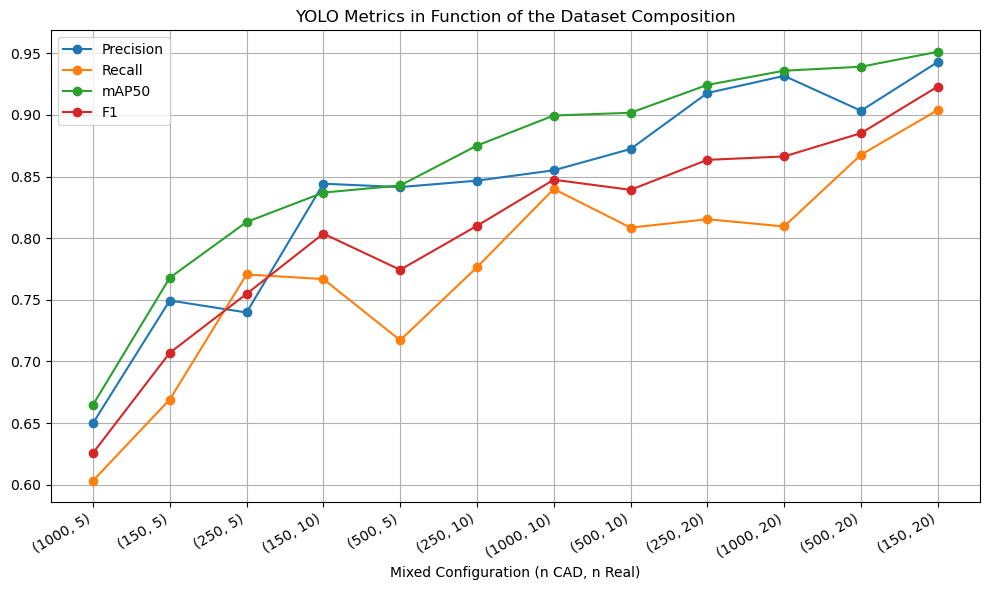

In [110]:
# Sort the dictionary by the third value in the list (mAP50) in ascending order
sorted_results = sorted(results_dict.items(), key=lambda item: item[1][2])

# Extract the sorted keys and corresponding numeric values
sorted_keys = [item[0] for item in sorted_results]
sorted_first_values = [item[1][0] for item in sorted_results]
sorted_second_values = [item[1][1] for item in sorted_results]
sorted_third_values = [item[1][2] for item in sorted_results]
sorted_fourth_values = [item[1][3] for item in sorted_results]

# Convert the keys to a string representation for labeling on the x-axis
keys_str = [str(key) for key in sorted_keys]

# Plot the data
plt.figure(figsize=(10, 6))

# Plot each of the numeric values
plt.plot(keys_str, sorted_first_values, marker='o', label='Precision')
plt.plot(keys_str, sorted_second_values, marker='o', label='Recall')
plt.plot(keys_str, sorted_third_values, marker='o', label='mAP50')
plt.plot(keys_str, sorted_fourth_values, marker='o', label='F1')

plt.xlabel('Mixed Configuration (n CAD, n Real)')
plt.xticks(rotation=30, ha='right')  # Rotate x-axis labels by 30 degrees and align to the right
plt.title('YOLO Metrics in Function of the Dataset Composition')
plt.legend()
plt.grid(True)

# Remove the name of the y-axis
plt.gca().yaxis.label.set_visible(False)

# Adjust the layout to prevent the x-axis labels from being cut off
plt.tight_layout()

# Save the plot as an image file
plt.savefig('gs_sorted_by_map50.png')  # Save the refined plot with all values

The graph suggests that:

- Real images greatly improve the metrics, even in small quantities.
- CAD images must be added carefully: if the number of CAD images is too large compared to real images, the effect could be counterproductive.
- According to mAP50, the targeted metric, there are three significant steps mainly related to the number of real images (5, 10, 20).

Considering the metrics displayed, a good compromise could be 500 CAD images combined with 10 real images per class. Of course, it would be easy to select 20 or more real images, but the scope of this analysis is to minimize the real image population as much as possible. Ideally, the model should be trained with as few real images as possible. On the other hand, it is also evident that too many CAD images don't help; in fact, they could have quite the opposite effect. This is particularly clear in the case of 1000 CAD and 5 real images. Considering the selected distribution (500 CAD, 10 real), the total number of real images is 10 per 5 classes + 10 background images = 60 real images. Approximately, this means a ratio of 10:1 between CAD and real images, which could be considered a good "rule of thumb" for balancing the two datasets.

This analysis provides an important insight: CAD images can truly be the "backbone" of the model, but they need a minimum number of real images (even 5 per class is sufficient for decent results). This implies that YOLO requires minimal information to understand the context and environment. Once it has that, the model can generalize the information and effectively leverage the extensive training from the CAD dataset.

### 7. Evaluation of the Selected Mixed Model

The model identified through the parametric analysis in the previous paragraph is further explored here. At this stage of the analysis, it's still unclear to me how YOLO stores previously trained models in memory. Therefore, I prefer to run a new training session using the selected parameters, just to ensure I'm working with the correct model.

In [153]:
n_train = 500 # Num CAD Images in Train (total number)

n_real_train = 10  # Num Real Images in Train (per class)
n_real_val = 40  # Num Real Images in Val (per class)

In [154]:
# Delete all files in training and validation folders
for path in [train_path, val_path]:
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))

In [155]:
# Adding CAD images from images folder
image_files = [f for f in os.listdir(images_path) if f.endswith('.png')]
labels = load_labels(labels_path)

# Preparing balanced random images for train
train_files = balance_classes(image_files, labels, n_train)

# Copy files to their respective directories 
copy_files(train_files, images_path, train_path, labels_path)

100%|██████████| 500/500 [00:39<00:00, 12.81it/s]


In [156]:
# Adding real-world images

#Train Dataset
all_train_QD_files = [f for f in os.listdir(train_QD_path) if f.endswith('.jpg')]
all_train_QF_files = [f for f in os.listdir(train_QF_path) if f.endswith('.jpg')]
all_train_QFA_files = [f for f in os.listdir(train_QFA_path) if f.endswith('.jpg')]
all_train_SD_files = [f for f in os.listdir(train_SD_path) if f.endswith('.jpg')]
all_train_SHD_files = [f for f in os.listdir(train_SHD_path) if f.endswith('.jpg')]
all_train_background_files = [f for f in os.listdir(train_background_path) if f.endswith('.jpg')]

#Val Dataset
all_val_QD_files = [f for f in os.listdir(val_QD_path) if f.endswith('.jpg')]
all_val_QF_files = [f for f in os.listdir(val_QF_path) if f.endswith('.jpg')]
all_val_QFA_files = [f for f in os.listdir(val_QFA_path) if f.endswith('.jpg')]
all_val_SD_files = [f for f in os.listdir(val_SD_path) if f.endswith('.jpg')]
all_val_SHD_files = [f for f in os.listdir(val_SHD_path) if f.endswith('.jpg')]
all_val_background_files = [f for f in os.listdir(val_background_path) if f.endswith('.jpg')]

pics_labels = load_labels(pics_labels_path)

In [157]:
# Random Pick across the classes

# Preparing random images for train/val
train_QD_files = pick_random_files(all_train_QD_files, n_real_train)
train_QF_files = pick_random_files(all_train_QF_files, n_real_train)
train_QFA_files = pick_random_files(all_train_QFA_files, n_real_train)
train_SD_files = pick_random_files(all_train_SD_files, n_real_train)
train_SHD_files = pick_random_files(all_train_SHD_files, n_real_train)
train_background_files = pick_random_files(all_train_background_files, n_real_train)

val_QD_files = pick_random_files(all_val_QD_files, n_real_val)
val_QF_files = pick_random_files(all_val_QF_files, n_real_val)
val_QFA_files = pick_random_files(all_val_QFA_files, n_real_val)
val_SD_files = pick_random_files(all_val_SD_files, n_real_val)
val_SHD_files = pick_random_files(all_val_SHD_files, n_real_val)
val_background_files = pick_random_files(all_val_background_files, n_real_val)

In [158]:
# Copy files to their respective directories 
copy_files(train_QD_files, train_QD_path, train_path, pics_labels_path)
copy_files(train_QF_files, train_QF_path, train_path, pics_labels_path)
copy_files(train_QFA_files, train_QFA_path, train_path, pics_labels_path)
copy_files(train_SD_files, train_SD_path, train_path, pics_labels_path)
copy_files(train_SHD_files, train_SHD_path, train_path, pics_labels_path)
copy_files(train_background_files, train_background_path, train_path, pics_labels_path)

copy_files(val_QD_files, val_QD_path, val_path, pics_labels_path)
copy_files(val_QF_files, val_QF_path, val_path, pics_labels_path)
copy_files(val_QFA_files, val_QFA_path, val_path, pics_labels_path)
copy_files(val_SD_files, val_SD_path, val_path, pics_labels_path)
copy_files(val_SHD_files, val_SHD_path, val_path, pics_labels_path)
copy_files(val_background_files, val_background_path, val_path, pics_labels_path)

100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


In [159]:
model_mixed_10r_500cad = YOLO('/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt', task='detect', verbose=False)

In [160]:
run_name=f'mixed_10r_500cad_{namegenerator.gen()}'

In [161]:
# Train the model

print(80*'=')
print(80*'=')
print(f"Training model {run_name}")
print(80*'=')

model_mixed_10r_500cad.train(
    data=params.yolo_yaml_path, 
    lr0=0.01,
    epochs=100,  
    val=True,
    imgsz=1024,
    batch=64,
    device=[0, 1, 2, 3],
    name=run_name,
    project='alsu_magnet_classifier',
    save_dir='/global/homes/a/amorato/alsu_magnet_classifier/training_output/',
    )

Training model mixed_10r_500cad_shabby-champagne-cow
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
engine/trainer: task=detect, mode=train, model=/global/homes/a/amorato/alsu_magnet_classifier/models/yolov8n.pt, data=/global/homes/a/amorato/alsu_magnet_classifier/tmp_yaml_files/tmp_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=1024, save=True, save_period=-1, cache=False, device=[0, 1, 2, 3], workers=8, project=alsu_magnet_classifier, name=mixed_10r_500cad_shabby-champagne-cow3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosa

wandb: Currently logged in as: emmetizeta (emmetizeta-emmetizeta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.5
wandb: Run data is saved locally in /global/homes/a/amorato/alsu_magnet_classifier/wandb/run-20240829_201255-4nnytr4i
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run mixed_10r_500cad_shabby-champagne-cow3
wandb: ⭐️ View project at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier
wandb: 🚀 View run at https://wandb.ai/emmetizeta-emmetizeta/alsu_magnet_classifier/runs/4nnytr4i


Overriding model.yaml nc=80 with nc=5
Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
/global/homes/a/amorato/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ul

Plotting labels to alsu_magnet_classifier/mixed_10r_500cad_shabby-champagne-cow3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 32 dataloader workers
Logging results to alsu_magnet_classifier/mixed_10r_500cad_shabby-champagne-cow3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.09G      2.112      5.325      2.463         58       1024: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


                   all        240        318    0.00453      0.685    0.00788    0.00312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.13G      1.347      4.543      1.945         40       1024: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.57it/s]


                   all        240        318    0.00617      0.661     0.0122    0.00581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.17G     0.7167      3.624      1.408         35       1024: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.43it/s]


                   all        240        318    0.00501      0.833     0.0582     0.0297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.12G     0.6609       3.11      1.345         29       1024: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.54it/s]


                   all        240        318    0.00658      0.812      0.132      0.078

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.17G      0.732      2.952      1.376         29       1024: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.41it/s]


                   all        240        318    0.00384      0.697     0.0595     0.0206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.16G     0.6857      2.631      1.298         28       1024: 100%|██████████| 9/9 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.11it/s]


                   all        240        318    0.00484      0.834      0.117     0.0547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.12G     0.6186      2.415      1.258         27       1024: 100%|██████████| 9/9 [00:01<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.69it/s]


                   all        240        318      0.501     0.0167     0.0245     0.0103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.16G     0.5727      2.221      1.209         36       1024: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.83it/s]


                   all        240        318      0.463      0.251      0.188     0.0987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       5.2G     0.6314      2.094      1.286         40       1024: 100%|██████████| 9/9 [00:01<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.21it/s]


                   all        240        318      0.306      0.173      0.138     0.0605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.12G     0.6166      2.061      1.282         24       1024: 100%|██████████| 9/9 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.19it/s]


                   all        240        318      0.207      0.135      0.141     0.0529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       5.2G     0.6084      1.808      1.201         36       1024: 100%|██████████| 9/9 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.52it/s]


                   all        240        318      0.138      0.166     0.0817     0.0321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.24G     0.6099      1.658      1.225         34       1024: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.42it/s]


                   all        240        318      0.188      0.184        0.1     0.0516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.17G     0.6529      1.713      1.293         31       1024: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.94it/s]


                   all        240        318      0.117      0.214      0.101     0.0436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.17G     0.5652      1.422      1.165         36       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.81it/s]


                   all        240        318       0.35       0.33      0.272      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.21G     0.6311      1.504      1.228         42       1024: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.75it/s]


                   all        240        318      0.471       0.47      0.438       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.12G     0.6374      1.414      1.269         31       1024: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 10.92it/s]


                   all        240        318      0.417      0.442      0.423      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       5.2G     0.5667      1.265      1.222         33       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


                   all        240        318      0.466      0.179      0.152     0.0716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.12G     0.5637      1.146      1.195         41       1024: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.31it/s]


                   all        240        318      0.569      0.374      0.422      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.12G     0.4939      1.054      1.125         39       1024: 100%|██████████| 9/9 [00:01<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.04it/s]


                   all        240        318      0.678      0.497      0.577       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.12G     0.5293      1.106      1.186         35       1024: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.03it/s]


                   all        240        318      0.596      0.482       0.57       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.16G     0.5342      1.007      1.172         37       1024: 100%|██████████| 9/9 [00:01<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.73it/s]


                   all        240        318      0.568      0.508      0.573      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.12G     0.5005     0.9368      1.152         29       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.85it/s]


                   all        240        318      0.591      0.525      0.574      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.12G     0.4938     0.9235      1.153         37       1024: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


                   all        240        318      0.482      0.413      0.401      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.16G     0.5469     0.9959      1.168         31       1024: 100%|██████████| 9/9 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.68it/s]


                   all        240        318      0.656      0.623       0.69      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.12G     0.4541      0.835      1.116         24       1024: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.58it/s]


                   all        240        318        0.7      0.565      0.675      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.17G     0.5498     0.9106      1.203         22       1024: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


                   all        240        318      0.555      0.559      0.625      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       5.2G     0.5259     0.7866      1.141         40       1024: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.47it/s]


                   all        240        318      0.652      0.538      0.627      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.12G     0.4436     0.7065      1.081         41       1024: 100%|██████████| 9/9 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.41it/s]


                   all        240        318      0.778      0.616      0.721      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.15G      0.454     0.7783      1.104         29       1024: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.20it/s]


                   all        240        318      0.711      0.551      0.638      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.12G     0.4754     0.7455      1.147         35       1024: 100%|██████████| 9/9 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.32it/s]


                   all        240        318      0.774      0.637      0.753      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.16G     0.4694     0.7316      1.114         26       1024: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


                   all        240        318      0.671      0.521        0.6      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.16G     0.5444     0.8146      1.155         29       1024: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        318      0.637      0.634      0.691      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.16G     0.4727     0.7059      1.101         31       1024: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.80it/s]


                   all        240        318      0.649      0.596      0.634      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.12G     0.4411     0.6534      1.088         24       1024: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


                   all        240        318      0.594      0.619      0.639      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.12G     0.4545      0.665      1.098         31       1024: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.80it/s]


                   all        240        318      0.569      0.536      0.588      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.12G     0.4675     0.7011      1.111         28       1024: 100%|██████████| 9/9 [00:01<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.73it/s]


                   all        240        318      0.801      0.612      0.746      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.19G     0.4928     0.6611      1.126         48       1024: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.88it/s]


                   all        240        318      0.775      0.622      0.736      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.12G     0.4438     0.6292       1.09         34       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.96it/s]


                   all        240        318      0.798      0.617      0.734      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.16G     0.4426     0.5983      1.062         38       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


                   all        240        318      0.707      0.605      0.685      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.17G     0.4206     0.6138      1.079         32       1024: 100%|██████████| 9/9 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.00it/s]


                   all        240        318       0.34      0.386      0.258      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.12G     0.4183     0.5416      1.065         38       1024: 100%|██████████| 9/9 [00:01<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


                   all        240        318      0.742      0.529      0.661      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.16G     0.4118     0.5576      1.047         28       1024: 100%|██████████| 9/9 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.09it/s]


                   all        240        318      0.665      0.658      0.705       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.16G     0.4241     0.5564      1.058         25       1024: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


                   all        240        318      0.723      0.602      0.694      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.12G     0.4416     0.5864      1.075         35       1024: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.32it/s]


                   all        240        318      0.769      0.635      0.739      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.15G     0.4493     0.5721      1.084         27       1024: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


                   all        240        318      0.758      0.631      0.722      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.15G     0.4656      0.595      1.096         33       1024: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.97it/s]


                   all        240        318      0.694      0.628      0.697      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.12G     0.3915     0.4966      1.028         42       1024: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


                   all        240        318        0.6       0.56      0.611      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.12G     0.3988     0.4972      1.056         29       1024: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.51it/s]


                   all        240        318       0.75      0.564      0.672      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.12G     0.4358      0.532      1.062         27       1024: 100%|██████████| 9/9 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


                   all        240        318      0.843      0.614       0.78      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.17G     0.4241     0.5442      1.071         33       1024: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


                   all        240        318      0.797      0.553      0.746      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.15G     0.4323     0.4882      1.089         26       1024: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


                   all        240        318      0.717      0.672      0.753      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.12G     0.4006     0.4822      1.053         34       1024: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


                   all        240        318      0.795      0.563      0.681       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.12G     0.4443     0.5315      1.101         29       1024: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.57it/s]


                   all        240        318      0.697       0.64      0.731      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.12G     0.3919     0.4722      1.054         33       1024: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.80it/s]


                   all        240        318      0.658      0.702      0.732      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.16G     0.3717     0.4599      1.046         33       1024: 100%|██████████| 9/9 [00:01<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]


                   all        240        318      0.685      0.618      0.667      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.19G      0.387     0.4759      1.037         51       1024: 100%|██████████| 9/9 [00:01<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.76it/s]


                   all        240        318      0.616      0.643      0.684      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.15G      0.375     0.4379      1.027         30       1024: 100%|██████████| 9/9 [00:01<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.95it/s]


                   all        240        318      0.676      0.693      0.711      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.16G     0.3445     0.4181      1.002         31       1024: 100%|██████████| 9/9 [00:01<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.44it/s]


                   all        240        318      0.859      0.668      0.792      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.12G     0.3939     0.4545      1.052         24       1024: 100%|██████████| 9/9 [00:01<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        318        0.7      0.684      0.747      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.16G     0.3761      0.446      1.029         36       1024: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.60it/s]


                   all        240        318      0.865      0.749      0.842      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.12G     0.3907     0.4126      1.048         25       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.43it/s]


                   all        240        318      0.762      0.618      0.712      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.12G     0.3518     0.4337      1.027         36       1024: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


                   all        240        318       0.61      0.639      0.705      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       5.2G     0.3689       0.42      1.034         37       1024: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        318       0.63       0.53      0.606      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.15G     0.3586     0.4247      1.027         34       1024: 100%|██████████| 9/9 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        318      0.754      0.677      0.756      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.12G     0.3845     0.4234      1.066         25       1024: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.14it/s]


                   all        240        318      0.772      0.687      0.772      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.12G     0.3745     0.4354      1.055         38       1024: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]


                   all        240        318       0.75      0.686      0.744      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.15G     0.3578     0.3958       1.06         28       1024: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.25it/s]


                   all        240        318      0.847      0.689      0.814      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.21G     0.3709     0.3902      1.012         39       1024: 100%|██████████| 9/9 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        318      0.855      0.743       0.85      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.12G     0.3646      0.413      1.045         24       1024: 100%|██████████| 9/9 [00:01<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        318      0.888      0.693      0.841       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.16G     0.3438     0.3814      1.005         38       1024: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.78it/s]


                   all        240        318      0.817      0.651      0.776      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.16G     0.3507     0.3773      1.036         26       1024: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.16it/s]


                   all        240        318      0.847      0.693      0.818       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.16G     0.3427     0.3787      1.002         34       1024: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]


                   all        240        318      0.776      0.764      0.826      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.19G     0.3149     0.3612     0.9778         43       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.33it/s]


                   all        240        318      0.822      0.772      0.855      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.12G     0.3568     0.3822      1.029         40       1024: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]


                   all        240        318      0.772      0.736      0.798      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.12G     0.3532     0.3698      1.017         34       1024: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]


                   all        240        318      0.854      0.663      0.794      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.16G     0.3311     0.3437       1.02         39       1024: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.35it/s]


                   all        240        318      0.708      0.717       0.76      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.16G     0.3114     0.3564     0.9872         38       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]


                   all        240        318      0.821      0.761      0.846      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.12G     0.3358     0.3796      1.024         27       1024: 100%|██████████| 9/9 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


                   all        240        318      0.842      0.795      0.877      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.12G     0.3092     0.3419     0.9846         41       1024: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]


                   all        240        318      0.853      0.747      0.851      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.16G     0.3115     0.3283      1.031         22       1024: 100%|██████████| 9/9 [00:01<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


                   all        240        318      0.724      0.755      0.803        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.12G     0.3088     0.3381     0.9965         33       1024: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.92it/s]


                   all        240        318      0.759      0.766      0.814      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.12G     0.3123     0.3637       1.02         28       1024: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.34it/s]


                   all        240        318      0.804      0.744      0.826      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.12G      0.322     0.3377     0.9905         30       1024: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]


                   all        240        318      0.794       0.69      0.796      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.16G     0.2976     0.3336     0.9872         31       1024: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


                   all        240        318      0.878      0.773      0.871      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.12G     0.2834     0.2991     0.9649         30       1024: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]


                   all        240        318      0.853      0.773      0.848      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.12G     0.3379     0.3546      1.037         25       1024: 100%|██████████| 9/9 [00:01<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.27it/s]


                   all        240        318      0.817      0.764      0.836      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.16G     0.3148     0.3201      1.002         32       1024: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.49it/s]


                   all        240        318       0.81      0.799      0.865      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.12G     0.3197     0.3505     0.9984         41       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.45it/s]


                   all        240        318      0.833      0.764      0.865      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.12G     0.3273     0.3504      1.019         28       1024: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.01it/s]


                   all        240        318      0.865      0.794       0.88      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.12G     0.2991     0.3257     0.9978         29       1024: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]


                   all        240        318      0.818      0.813      0.883      0.679
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.12G     0.2483     0.3086     0.9358         16       1024: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.52it/s]


                   all        240        318      0.905      0.792      0.892        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.12G     0.2256     0.2688     0.9191         16       1024: 100%|██████████| 9/9 [00:01<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.99it/s]


                   all        240        318      0.875      0.749      0.871      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.12G      0.195     0.2505     0.8338         16       1024: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.19it/s]


                   all        240        318      0.886      0.745      0.867      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.12G      0.194     0.2419     0.8577         16       1024: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


                   all        240        318      0.881      0.752      0.866      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.12G     0.1943     0.2452     0.8943         11       1024: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.77it/s]


                   all        240        318      0.854      0.778      0.865      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.12G     0.1962     0.2494     0.8685         12       1024: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.28it/s]


                   all        240        318      0.878      0.754      0.862      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.12G     0.1767     0.2305     0.8293         12       1024: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 11.87it/s]


                   all        240        318      0.886      0.748      0.861      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.12G     0.1744      0.232     0.8854         12       1024: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.56it/s]


                   all        240        318       0.87       0.75      0.857      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.12G     0.1642     0.2229     0.8589         12       1024: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.17it/s]


                   all        240        318       0.87      0.754      0.858      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.12G     0.1839     0.2283     0.8481         25       1024: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.21it/s]


                   all        240        318      0.866      0.762      0.858      0.661

100 epochs completed in 0.072 hours.
Optimizer stripped from alsu_magnet_classifier/mixed_10r_500cad_shabby-champagne-cow3/weights/last.pt, 6.3MB
Optimizer stripped from alsu_magnet_classifier/mixed_10r_500cad_shabby-champagne-cow3/weights/best.pt, 6.3MB

Validating alsu_magnet_classifier/mixed_10r_500cad_shabby-champagne-cow3/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  9.52it/s]


                   all        240        318      0.908      0.792      0.894      0.701
                    QF         42         42      0.932      0.762      0.907       0.74
                    QD         53         54      0.915      0.796       0.91      0.749
                   QFA         64         64      0.924      0.764      0.866      0.612
                    SD         79        105      0.866       0.79      0.862      0.642
                   SHD         53         53      0.901      0.849      0.928      0.764
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to alsu_magnet_classifier/mixed_10r_500cad_shabby-champagne-cow3


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▁▃▅▆████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▁▂▂▂▂▄▄▅▄▆▇▆▆▇▆▆▇▆▇▇▇▆▇▇▇▇█▇▇██▇███████
wandb:     metrics/mAP50-95(B) ▁▁▂▂▁▁▃▄▅▃▅▆▅▅▆▆▆▆▆▇▆▆▆▇▆▇▇█▇▇█▇▇███████
wandb:    metrics/precision(B) ▁▁▁▅▂▂▄▅▅▅▅▇▆▆▇▆▇▇▆▇▇▆▆▆▇▇██▇▇▇█▇█▇█████
wandb:       metrics/recall(B) ▆██▂▁▂▄▃▅��▅▆▅▆▆▆▅▆▆▆▆▇▆▆▆▆▆▇▇▇▇▇▇▇██▇▇▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁
wandb:          train/cls_loss █▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:            val/box_loss ▅▄▄▄█▅▄▄▃▆▄▃▄▄▃▃▂▂▂▂▂▂▂▂▃▂▂▁▂▂▁▂▂▁

In [162]:
# Save the optimized mixed model
model_mixed_10r_500cad.save('magnet_classifier_10r_500cad.pt')

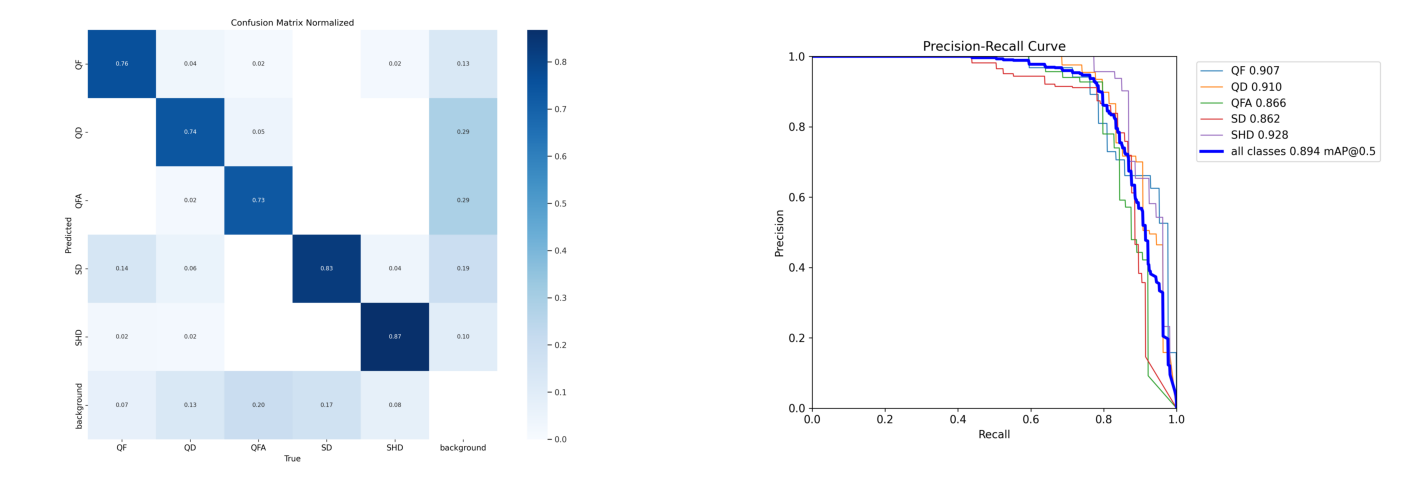

In [163]:
# Define paths to the confusion matrix and PR curve images for the last run
image_path_0 = f'alsu_magnet_classifier/{run_name}/confusion_matrix_normalized.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/PR_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)

# Create a figure to display both images side by side
plt.figure(figsize=(18, 6))

# Display the first image (confusion matrix) on the left
plt.subplot(1, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (PR curve) on the right
plt.subplot(1, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Show the images
plt.show()

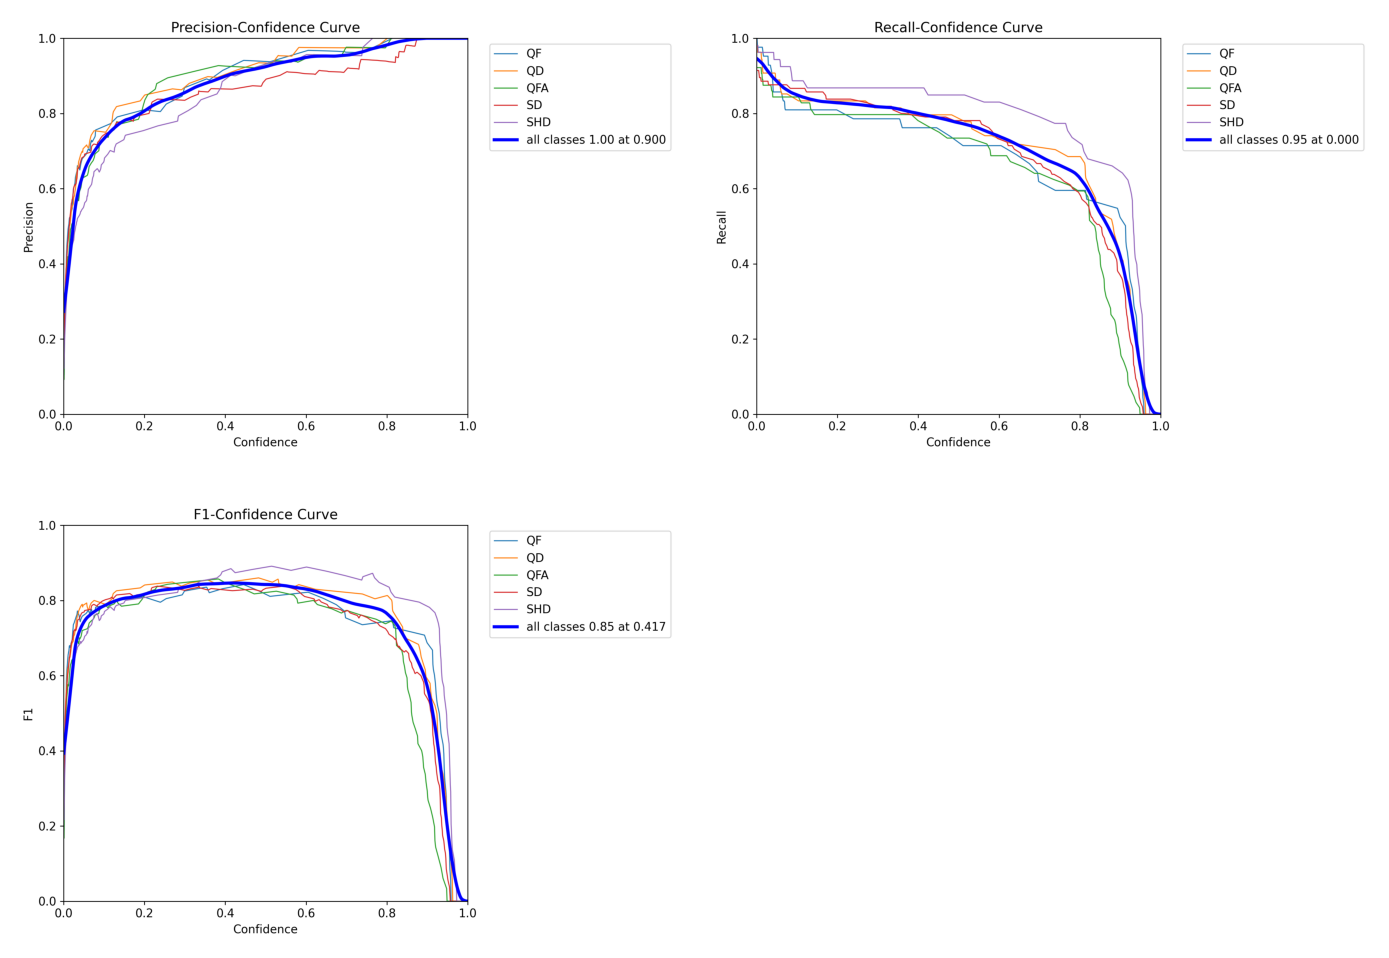

In [164]:
# Define paths to the performance graphs
image_path_0 = f'alsu_magnet_classifier/{run_name}/P_curve.png'
image_path_1 = f'alsu_magnet_classifier/{run_name}/R_curve.png'
image_path_2 = f'alsu_magnet_classifier/{run_name}/F1_curve.png'

# Open the images using PIL for display
image0 = PilImage.open(image_path_0)
image1 = PilImage.open(image_path_1)
image2 = PilImage.open(image_path_2)

# Create a figure to display both images side by side
plt.figure(figsize=(14, 10))

# Display the first image (P curve)
plt.subplot(2, 2, 1)
plt.imshow(image0)
plt.axis('off')  # Hide the axes

# Display the second image (R curve)
plt.subplot(2, 2, 2)
plt.imshow(image1)
plt.axis('off')  # Hide the axes

# Display the third image (F1 curve)
plt.subplot(2, 2, 3)
plt.imshow(image2)
plt.axis('off')  # Hide the axes

plt.tight_layout()

# Show the images
plt.show()

In [165]:
results_mixed_10r_500cad = model_mixed_10r_500cad.val()

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:1 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:2 (NVIDIA A100-SXM4-80GB, 81053MiB)
                                                           CUDA:3 (NVIDIA A100-SXM4-80GB, 81053MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /global/u2/a/amorato/alsu_magnet_classifier/training_output/val.cache... 240 images, 40 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


                   all        240        318      0.908      0.792      0.892        0.7
                    QF         42         42      0.934      0.762      0.906      0.739
                    QD         53         54      0.916      0.796      0.908      0.744
                   QFA         64         64      0.924      0.761      0.858      0.609
                    SD         79        105      0.867       0.79      0.861      0.642
                   SHD         53         53        0.9      0.852      0.928      0.764
Speed: 0.4ms preprocess, 1.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to alsu_magnet_classifier/mixed_10r_500cad_shabby-champagne-cow32


In [166]:
mixed_10r_500cad_precision = results_mixed_10r_500cad.box.mp
mixed_10r_500cad_recall = results_mixed_10r_500cad.box.mr
mixed_10r_500cad_mAP50 = results_mixed_10r_500cad.box.map50
mixed_10r_500cad_f1 = 2 * (mixed_10r_500cad_precision * mixed_10r_500cad_recall) / (mixed_10r_500cad_precision + mixed_10r_500cad_recall)

In [170]:
print("Optimized Mixed Model Summary:")
print(f"Precision: {mixed_10r_500cad_precision:.3f}")
print(f"Recall: {mixed_10r_500cad_recall:.3f}")
print(f"mAP50: {mixed_10r_500cad_mAP50:.3f}")
print(f"F1: {mixed_10r_500cad_f1:.3f}")

Optimized Mixed Model Summary:
Precision: 0.908
Recall: 0.792
mAP50: 0.892
F1: 0.846


### 8. Conclusions and Final Recommendations

The use of the YOLO framework has proven to be a highly effective tool for developing an object classifier. The primary goal of this analysis was to understand how effective it is to implement such a tool primarily using CAD-generated images, as opposed to real pictures, which are usually more challenging to collect. The results are summarized in the table and graphs below.

In [174]:
model_metrics = {
    'Full Real': {'Precision': fullReal_precision, 'Recall': fullReal_recall, 'mAP50': fullReal_mAP50, 'F1': fullReal_f1},
    'Full Real - Reduced': {'Precision': fullReal_5_precision, 'Recall': fullReal_5_recall, 'mAP50': fullReal_5_mAP50, 'F1': fullReal_5_f1},
    'Mixed - Simple': {'Precision': mixed_5r_150cad_precision, 'Recall': mixed_5r_150cad_recall, 'mAP50': mixed_5r_150cad_mAP50, 'F1': mixed_5r_150cad_f1},
    'Mixed - Optimized': {'Precision':mixed_10r_500cad_precision, 'Recall':mixed_10r_500cad_recall, 'mAP50': mixed_10r_500cad_mAP50, 'F1': mixed_10r_500cad_f1},
}

df_metrics = pd.DataFrame.from_dict(model_metrics, orient='index')
df_metrics.index.name = 'Model'

print(df_metrics)

                     Precision    Recall     mAP50        F1
Model                                                       
Full Real             0.946722  0.835058  0.929050  0.887391
Full Real - Reduced   0.545860  0.409720  0.464200  0.468092
Mixed - Simple        0.813192  0.725323  0.822760  0.766749
Mixed - Optimized     0.908239  0.792265  0.892283  0.846297


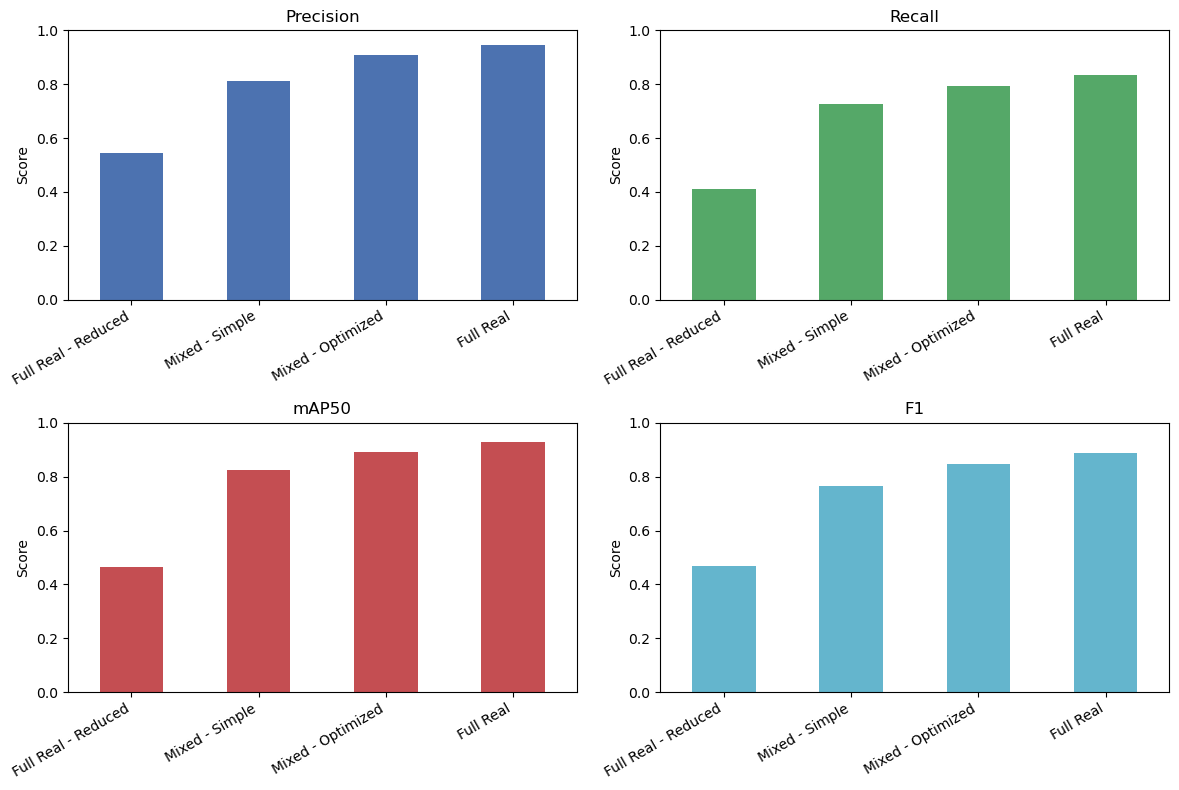

In [182]:
# Ensure that all data is numeric
df_metrics = df_metrics.apply(pd.to_numeric)

# Sort the models for each metric
df_sorted = df_metrics.apply(lambda x: x.sort_values(ascending=True), axis=0)

# Plotting the histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df_sorted['Precision'].plot(kind='bar', ax=axes[0, 0], color='b', title='Precision')
df_sorted['Recall'].plot(kind='bar', ax=axes[0, 1], color='g', title='Recall')
df_sorted['mAP50'].plot(kind='bar', ax=axes[1, 0], color='r', title='mAP50')
df_sorted['F1'].plot(kind='bar', ax=axes[1, 1], color='c', title='F1')

# Set the labels
for ax in axes.flat:
    ax.set_ylabel('Score')
    ax.set_xlabel('')  # Hides the x-axis label name
    ax.set_ylim(0, 1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

The analysis suggested that this mixed approach is quite effective. A model trained solely on CAD images is not adequate for detecting real-world objects. Conversely, a model trained with very few real images provides modest results. However, merging the two approaches leads to a tremendous improvement: with just a few real-world images in the training set, YOLO appears to generalize the main information from the dataset and apply it in an environmental context. The dataset investigated suggested a rule of thumb with a scaling factor of 10 between the number of artificial CAD images and real images. A dataset trained with a total of 60 images (10 per class + 10 background) and 500 CAD images yielded very good results, not far from the best model trained with 600 real-world images.

The analysis has addressed my initial question: `Is it possible to develop an effective image recognizer using a collection of 'synthetic' images produced by CAD software?` **YES**: CAD images have proven to be a very powerful tool for easily developing an image recognition tool. However, they cannot be used alone and will always require a minimum number of real-world images to allow the classifier to correlate the artificial dataset with the real world.

### 9. Suggested Next Steps

This work has been quite challenging in many aspects and required more time than expected in different areas:

- Developing an understanding of the YOLO model and its tools
- Gaining experience with the NERSC Perlmutter system
- Developing reliable tools to produce a CAD dataset
- Finding the right real-world images and learning how to use them effectively
- Understanding how to label the datasets accurately
- Integrating all components into a cohesive and effective process
- Analyzing the results, interpreting the metrics, and optimizing the outcomes

The project turned out to be a true full-stack application of machine learning. Due to time constraints, I couldn't complete the final step: deployment. The plan was to take the most promising mixed model and apply it to a new dataset of completely new images, even in different environments, with the ultimate goal of achieving a real-time video application. I made some progress, but the results weren't yet adequate to be presented here. This is something I will continue working on in the coming weeks/months to further develop this analysis.

Regarding the analysis itself, there are some open points that I couldn't address; I would recommend further development in these areas:

- Understanding YOLO’s auxiliary tools (e.g., tuning). Some of them appear very powerful and could significantly boost results.
- Extending the parameter research. I focused on parameters that interested me, but many other parameters deserve consideration (e.g., number of epochs/batches, size of images).
- Studying the effect of the selected real images. Are some images more effective than others? Is there a criterion for selecting specific images in terms of object position, lighting, distances, etc.?
- Unfortunately, the photo shooting area was not well-organized. In many pictures, there is a magnet in the foreground and many other magnets in the background. Does this affect the model, or is it helpful? I suspect this may have impacted the results: in all the confusion matrices, several backgrounds were interpreted as magnets. This suggests that the -model sometimes detects magnets where there aren’t any. This issue should be further investigated.
- The color in the images. Due to limitations in the CAD image generator, I could only obtain grayscale images. To maintain consistency, I used grayscale real-world images as well. What if I had used color images instead? I made some attempts, and it seems that color models tend to overfit. However, this is another aspect that was only slightly touched upon. More intensive and rigorous work is required.